In [1]:
%matplotlib notebook
import numpy as np
import operator
import scipy
import math
import scipy.ndimage
import matplotlib.patches
from scipy.spatial import distance
import photutils
from photutils import centroid_com
from scipy import ndimage
from scipy import optimize
from scipy.optimize import least_squares
import h5py
import matplotlib
import matplotlib.pyplot as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
import cv2
from scipy.ndimage.morphology import binary_fill_holes
import os, re
import sys
import skimage
from skimage import morphology
sourcepath = '/Users/niloo/Desktop/SwissFel_2019/data_beamtime/SwissFEL_BERNINA_20181820-master/src'
sys.path.insert(0, sourcepath)
import calibrators
from calibrators import *

In [2]:
files = {'r0144':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0144_type1-peaks_with_q.h5',
         'r0145':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0145_type1-peaks_with_q.h5',
         'r0146':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0146_type1-peaks_with_q.h5',
         'r0147':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0147_type1-peaks_with_q.h5',
         'r0151':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0151_type1-peaks_with_q.h5',
         'r0165':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0165_type1-peaks_with_q.h5',
         'r0166':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0166_type1-peaks_with_q.h5',
         'r0167':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0167_type1-peaks_with_q.h5',
         'r0168':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0168_type1-peaks_with_q.h5',
         'r0169':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0169_type1-peaks_with_q.h5',
         'r0170':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0170_type1-peaks_with_q.h5',
         'r0171':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0171_type1-peaks_with_q.h5',
         'r0172':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0172_type1-peaks_with_q.h5',
         'r0173':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0173_type1-peaks_with_q.h5'}

f_tuples = sorted(files.items(), key=operator.itemgetter(1))
runs = sorted(np.array([n[0] for n in f_tuples]))
files_pass = np.array([n[1] for n in sorted(f_tuples)])

### wavelength should be corrected in the files, they are not in Angstrom

In [421]:
def load_runs(run,path=None, lower_bound=None, upper_bound=None):
    '''
    loads data from processed h5
    '''
    
    if path is None:
        h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    else:
        h5path = path+'%s_type1-peaks.h5'%run
    h5file = h5py.File(h5path,'r')
    wavelength = h5file['LCLS/wavelengthInAngstromMean'][()]/1e10
    n_shots = h5file['LCLS/numberOfShots'][()]
    detector_distance = h5file['LCLS/detectorDistanceInMeterMean'][()]
    n_peaks = []
    peak_list = []
    center_mass = []
    radius = []
    q_cm = []
    shots = [x for x in h5file['shots'].keys()]
    if (lower_bound is not None) and (upper_bound is not None):
        shots_in_bounds = []
    else:
        shots_in_bounds = None
    for i,j in enumerate(shots):
        n_peaks.append(h5file['shots'][j]['numberOfPeaks'][()])
        each_shot = [key for key in h5file['shots'][j].keys()]
        for i in each_shot:
            if (len(i) <= 12) & (i.startswith('peak')):
                peak_list.append(h5file['shots'][j][i]['diffraction'][:])
                center_mass.append(h5file['shots'][j][i]['centerOfMassInPixels'][:])
                radius.append(h5file['shots'][j][i]['radiusInPixels'][()])
                q_cm.append(h5file['shots'][j][i]['peakCenterOfMassQMagnitude'][:])
                if (lower_bound is not None) and (upper_bound is not None):
                    if np.any((h5file['shots'][j][i]['peakCenterOfMassQMagnitude'][:] >= lower_bound) & ( h5file['shots'][j][i]['peakCenterOfMassQMagnitude'][:] < upper_bound)):
                        shots_in_bounds.append(j)
    print('run %s: %d shots, %d peaks' % (run, n_shots, sum(n_peaks)))
    h5file.close()    
    return  {'peaks': peak_list,
             'wavelength': wavelength,
             'detector_distance': detector_distance,
             'center_mass': center_mass,
             'q_cm': q_cm,
             'No_of_peaks': n_peaks,
             'shots_bounds': shots_in_bounds,
             'radiusInPixels': radius,
             'No_shots': n_shots}

In [4]:
run_list = {}
for n in files.keys():
    print("---------- %s ----------" % n)
    run_list[n] = load_runs(n)

---------- r0144 ----------
run r0144: 51 shots, 433 peaks
---------- r0145 ----------
run r0145: 42 shots, 369 peaks
---------- r0146 ----------
run r0146: 22 shots, 185 peaks
---------- r0147 ----------
run r0147: 266 shots, 2557 peaks
---------- r0151 ----------
run r0151: 127 shots, 1162 peaks
---------- r0165 ----------
run r0165: 2865 shots, 23205 peaks
---------- r0166 ----------
run r0166: 630 shots, 3160 peaks
---------- r0167 ----------
run r0167: 786 shots, 3378 peaks
---------- r0168 ----------
run r0168: 625 shots, 2728 peaks
---------- r0169 ----------
run r0169: 499 shots, 3408 peaks
---------- r0170 ----------
run r0170: 140 shots, 948 peaks
---------- r0171 ----------
run r0171: 433 shots, 3008 peaks
---------- r0172 ----------
run r0172: 749 shots, 5223 peaks
---------- r0173 ----------
run r0173: 1705 shots, 7462 peaks


In [5]:
T_w = ['r0144','r0145','r0146', 'r0147', 'r0151','r0169','r0170']
T_m = ['r0167', 'r0168', 'r0171', 'r0172', 'r0173']
T_c = ['r0165','r0166']

In [6]:
run_with_lims = {}
for n in T_c:
    print("---------- %s ----------" % n)
    run_with_lims[n] = load_runs(n, lower_bound=0.7, upper_bound=1.0)

---------- r0165 ----------
run r0165: 2865 shots, 23205 peaks
---------- r0166 ----------
run r0166: 630 shots, 3160 peaks


In [7]:
run_lims_w = {}
for n in T_w:
    print("---------- %s ----------" % n)
    run_lims_w[n] = load_runs(n, lower_bound=0.7, upper_bound=0.9)

---------- r0144 ----------
run r0144: 51 shots, 433 peaks
---------- r0145 ----------
run r0145: 42 shots, 369 peaks
---------- r0146 ----------
run r0146: 22 shots, 185 peaks
---------- r0147 ----------
run r0147: 266 shots, 2557 peaks
---------- r0151 ----------
run r0151: 127 shots, 1162 peaks
---------- r0169 ----------
run r0169: 499 shots, 3408 peaks
---------- r0170 ----------
run r0170: 140 shots, 948 peaks


In [8]:
run_lims_w['r0145']['shots_bounds']

[]

In [9]:
len(set(run_with_lims['r0166']['shots_bounds'])), len(set(run_with_lims['r0166']['shots_bounds']))

(7, 7)

In [10]:
os.getcwd()

'/Users/niloo/Desktop/LCLS/14Dec2020'

In [11]:
s = set(run_with_lims['r0166']['shots_bounds'])

In [12]:
s2 = set(run_lims_w['r0145']['shots_bounds'])

In [13]:
'''
textfile = open("r0165_shots_with_low-q_bounds.txt", "w")
for element in s2:
    textfile.write(element + "\n")
textfile.close()
'''

'\ntextfile = open("r0165_shots_with_low-q_bounds.txt", "w")\nfor element in s2:\n    textfile.write(element + "\n")\ntextfile.close()\n'

In [14]:
seen = set()
uniq = [x for x in run_with_lims['r0165']['shots_bounds'] if x in seen or seen.add(x)]    

In [15]:
len(uniq)

2503

In [16]:
'''
f = h5py.File('/Volumes/harddrive/LCLS/CXI/cxi25410/res/iceFinderCampaign/output_r0166/type1/LCLS_2011_Mar01_r0166_000133_103aa_cspad.h5', 'r')
d = f['data/data'][:]
plt.figure(figsize=[10,8])
plt.imshow(d,cmap='jet', vmin=0, vmax=10000, origin = 'lower', aspect='auto')
plt.colorbar();
plt.gca().invert_yaxis()

plt.show()
'''

"\nf = h5py.File('/Volumes/harddrive/LCLS/CXI/cxi25410/res/iceFinderCampaign/output_r0166/type1/LCLS_2011_Mar01_r0166_000133_103aa_cspad.h5', 'r')\nd = f['data/data'][:]\nplt.figure(figsize=[10,8])\nplt.imshow(d,cmap='jet', vmin=0, vmax=10000, origin = 'lower', aspect='auto')\nplt.colorbar();\nplt.gca().invert_yaxis()\n\nplt.show()\n"

In [17]:
q_cm_w = []
for i,n in enumerate(T_w):
    q_cm_w.append(run_list[n]['q_cm'])

In [18]:
q_cm_m = []
for i,n in enumerate(T_m):
    q_cm_m.append(run_list[n]['q_cm'])

In [19]:
q_cm_c = []
for i,n in enumerate(T_c):
    q_cm_c.append(run_list[n]['q_cm'])

In [20]:
import itertools
q_cm_w = np.array(sorted(itertools.chain(*q_cm_w))).T
q_cm_m = np.array(sorted(itertools.chain(*q_cm_m))).T
q_cm_c = np.array(sorted(itertools.chain(*q_cm_c))).T

In [21]:
iceIh_peaks()

array([1.61297476, 1.71327851, 1.8264895 , 2.35318655, 2.79464445,
       3.03451657, 3.22634856, 3.27789344, 3.33837302, 3.6533046 ])

In [22]:
#q_cm_c[np.where(yhist_c == 659)]

<IPython.core.display.Javascript object>


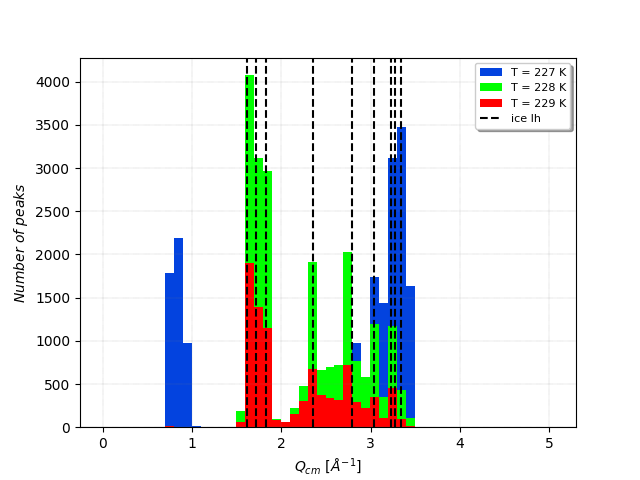

In [349]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.01
binedges = np.arange(0-binwidth/2,5.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(q_cm_w, bins=binedges)
yhist_m, bin_edges_m = np.histogram(q_cm_m, bins=binedges)
yhist_c, bin_edges_c = np.histogram(q_cm_c, bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

T_227 = plt.bar(new_bins, new_q_cm_c,  color='#0343DF', width=binwidth*10, label= 'T = 227 K')
T_228 = plt.bar(new_bins, new_q_cm_m,  color='#00FF00', width=binwidth*10, label = 'T = 228 K')
T_229 = plt.bar(new_bins, new_q_cm_w,  color='r', width=binwidth*10, label = 'T = 229 K')
xposition = iceIh_peaks()
for xc in xposition[:-1]:
    ice_plot = plt.axvline(x=xc, color='k', linestyle='--')

plt.legend(handles=[T_227, T_228, T_229, ice_plot], labels=['T = 227 K', 'T = 228 K', 'T = 229 K', 'ice Ih'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q_{cm}\ [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


In [29]:
#plt.imshow(sphericity_of_peak[265][0],cmap='jet')

In [30]:
def aspect_ratio(run_group):
    sphericity_of_peak = []
    for n, run in enumerate(run_group):
        p = run_list[run]['peaks']
        c_mass = run_list[run]['center_mass']
        for p_i in np.arange(len(p)):
            p_sub = p[p_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    #cnt_string = 'Numbers of contours for peak {} : {}, sphericity: {}'
                    #print(cnt_string.format(p_i, len(contours), sphericity))
                    sphericity_of_peak.append(sphericity)
    return sphericity_of_peak

<IPython.core.display.Javascript object>


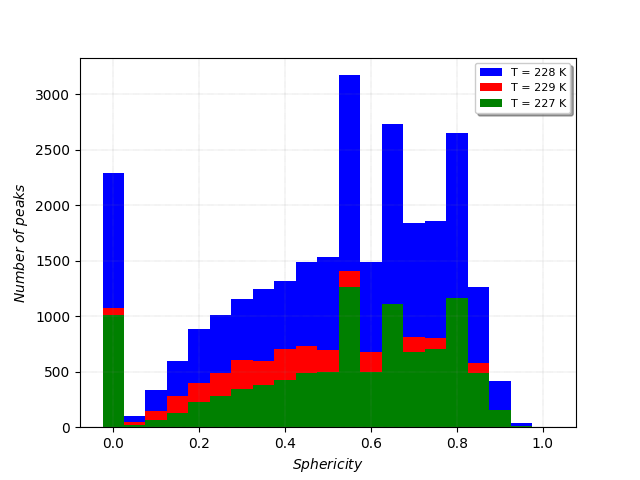

In [33]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.05
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(aspect_ratio(T_w), bins=binedges)
Sp_m, bin_edges = np.histogram(aspect_ratio(T_m), bins=binedges)
Sp_c, bin_edges = np.histogram(aspect_ratio(T_c), bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K')
plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K')
plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [34]:
BG_level = 100
photon_threshold = 2000
sphericity_of_peak = []
for n, run in enumerate(run_list.keys()):
    p = run_list[run]['peaks']
    c_mass = run_list[run]['center_mass']
    for p_i in np.arange(len(p)):
        p_sub = p[p_i] - BG_level
        p_mask = p_sub > photon_threshold
        fill_holes = binary_fill_holes(p_mask)
        contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for cnt in contours:
            perimeter = cv2.arcLength(cnt, True)
            area = cv2.contourArea(cnt)
            if perimeter != 0:
                sphericity = 4*np.pi*area/(perimeter**2)     
                #cnt_string = 'Numbers of contours for peak {} : {}, sphericity: {}'
                #print(cnt_string.format(p_i, len(contours), sphericity))
                sphericity_of_peak.append((p[p_i],len(contours),sphericity))

In [35]:
S_p = np.array([sphericity_of_peak[i][2] for i in range(len(sphericity_of_peak))])

In [36]:
# calculate qx and qy to find distance
wavelength = np.array([run_list[run]['wavelength'] for run in run_list.keys()])
detector_distance = np.array([run_list[run]['detector_distance'] for run in run_list.keys()])
wavelength = np.mean(wavelength)
detector_distance = np.mean(detector_distance)
pixel_size = 109.92*1e-6

center = None
x = np.arange(1760)
y = np.arange(1760)
xx, yy = np.meshgrid(x, y)
if center is None:
    xx = xx.astype(np.float64) - (1760-1)/2
    yy = yy.astype(np.float64) - (1760-1)/2
else:
    xx -= center[1]
    yy -= center[0]
rad = np.sqrt(xx*xx + yy*yy)
 

# calculate qx and qy

qx = 2.*np.pi*2.*np.sin(0.5*np.arctan2(xx*pixel_size, detector_distance))/(wavelength)
qy = 2.*np.pi*2.*np.sin(0.5*np.arctan2(yy*pixel_size, detector_distance))/(wavelength)

In [37]:
# delta_cx = cx2 (old peak center in whole image 1760) - cx1 (old peak local center peak_region) # new_cx
# delta_cy = cy2 (old peak center in whole image 1760) - cy1 (old peak local center peak_region) # new_cx

In [38]:
# new cx cut in whole image 1760 = new_cx(ROI) + delta_cx
# new cy cut in whole image 1760 = new_cy(ROI) + delta_cy

In [39]:
#delta_cx = run_list[run]['peaks'][1] - 

In [40]:
#delta_cy =

In [41]:
def short_all_dist(run, binwidth=0.01, lower_bound=None, upper_bound=None):
    '''
    returns all distances in each shots for one run and also the minimum 
    distance among all distances for a shot
    
    '''
    hist_tot = np.zeros((811))
    hist_min_tot = np.zeros((811))
    binedges = np.arange(0-binwidth/2,8.1+binwidth/2,binwidth)
    run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    run_no = h5py.File(run_path,'r')
    shots = [x for x in run_no['shots'].keys()]
    if (lower_bound is not None) and (upper_bound is not None):
        shots_in_bounds = []
    else:
        shots_in_bounds = None
    for shot_n,each_shot in enumerate(shots):
        n_peaks = run_no['shots'][each_shot]['numberOfPeaks'][()]
        if n_peaks >= 1:
            qcm_x = run_no['shots'][each_shot]['peakCenterOfMassQx'][()]
            qcm_y = run_no['shots'][each_shot]['peakCenterOfMassQy'][()]
            q_cm = list(zip(qcm_x,qcm_y))
            d = distance.cdist(q_cm,q_cm)
            all_dist = [d[np.nonzero(d)]]
            distances = np.array(all_dist).flatten()
            if (lower_bound is not None) and (upper_bound is not None):
                if np.any((distances >= lower_bound) & (distances < upper_bound)):
                    shots_in_bounds.append(each_shot)
            try:
                min_dist = [np.min(d[np.nonzero(d)])]
                min_distances = np.array(min_dist).flatten()
                yhist, bin_edges = np.histogram(distances, bins=binedges)
                minhist, bin_edges = np.histogram(min_distances, bins=binedges)
                yhist = yhist/2
                minhist = minhist/2
                hist_tot += yhist
                hist_min_tot += minhist
            except:
                pass
    return hist_tot, hist_min_tot, shots_in_bounds

<IPython.core.display.Javascript object>


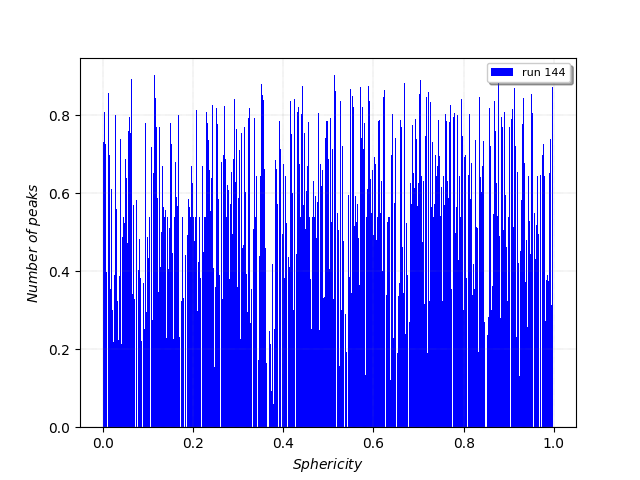

In [42]:
plt.figure()
sp_144 = []
p = run_list['r0144']['peaks']
for p_i in np.arange(len(p)):
    p_sub = p[p_i] - BG_level
    p_mask = p_sub > photon_threshold
    fill_holes = binary_fill_holes(p_mask)
    contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if perimeter != 0:
            sphericity = 4*np.pi*area/(perimeter**2)     
                #cnt_string = 'Numbers of contours for peak {} : {}, sphericity: {}'
                #print(cnt_string.format(p_i, len(contours), sphericity))
            sp_144.append(sphericity)
binwidth = 1.0/len(sp_144)
binedges = np.arange(0-binwidth/2,1.0+binwidth/2,binwidth)
yhist, bin_edges = np.histogram(sp_144, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(sp_144))])
plt.bar(bin_centers, sp_144,  color='b', width=binwidth, label = 'run 144')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

<IPython.core.display.Javascript object>


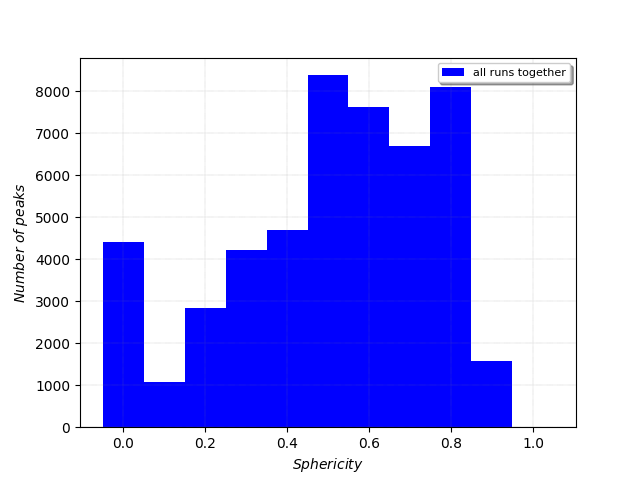

In [43]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.1
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
yhist, bin_edges = np.histogram(S_p, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
plt.bar(bin_centers, yhist,  color='b', width=binwidth, label = 'all runs together')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [44]:
bin_edges, bin_centers, yhist

(array([-0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,
         0.85,  0.95,  1.05]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([4413, 1074, 2851, 4211, 4709, 8385, 7628, 6707, 8113, 1583,    0]))

<IPython.core.display.Javascript object>


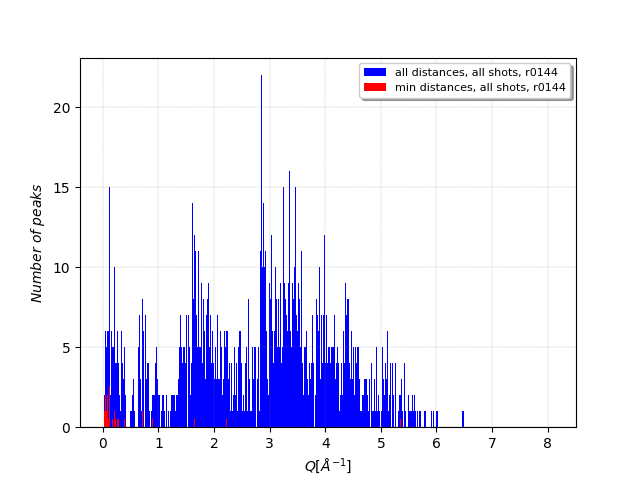

In [135]:
plt.figure()
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
plt.bar(bin_centers, short_all_dist('r0144')[0],  color='b', width=binwidth, label = 'all distances, all shots, r0144')
plt.bar(bin_centers, short_all_dist('r0144')[1], color='r', width=binwidth, label = 'min distances, all shots, r0144')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [46]:
all_distance = np.zeros((14,811))
min_distance = np.zeros((14,811))
for i,n in enumerate(run_list.keys()):
    all_d, min_d,_ = short_all_dist(n)
    all_distance[i] = all_d
    min_distance[i] = min_d

In [47]:
# warm temperatures runs 144 to 170
all_T_w = np.zeros((7,811))
min_T_w = np.zeros((7,811))
for i,n in enumerate(T_w):
    all_d_T_w, min_d_T_w,_ = short_all_dist(n)
    all_T_w[i] = all_d_T_w
    min_T_w[i] = min_d_T_w

In [48]:
# medium temperatures runs 167 to 173
all_T_m = np.zeros((5,811))
min_T_m = np.zeros((5,811))
for i,n in enumerate(T_m):
    all_d_T_m, min_d_T_m,_ = short_all_dist(n)
    all_T_m[i] = all_d_T_m
    min_T_m[i] = min_d_T_m

In [49]:
# cold temperatures runs 165 to 166
all_T_c = np.zeros((2,811))
min_T_c = np.zeros((2,811))
for i,n in enumerate(T_c):
    all_d_T_c, min_d_T_c,_ = short_all_dist(n)
    all_T_c[i] = all_d_T_c
    min_T_c[i] = min_d_T_c

In [50]:
# binsize = 0.1 or 0.2
def downsample(x, y, size=int(2)):
    assert (len(x) == len(y))
    if (len(x)%size != 0):
        print('WARNING: size of %d in input arrays are not dividable with %d, remainder: %d' % (len(x), size, len(x)%size))
    n = np.int(np.ceil(len(x)/size))
    new_x = np.zeros(n)
    new_y = np.zeros(n)
    for i in range(n):
        new_x[i] = np.average(x[i*size:(i+1)*size])
        new_y[i] = np.sum(y[i*size:(i+1)*size])
    return new_x, new_y

In [51]:
#new_bins[16]-binwidth*5, new_bins[18]+binwidth*5, sum_min_dists[16:18], sum_all_dists[16:18]

<IPython.core.display.Javascript object>


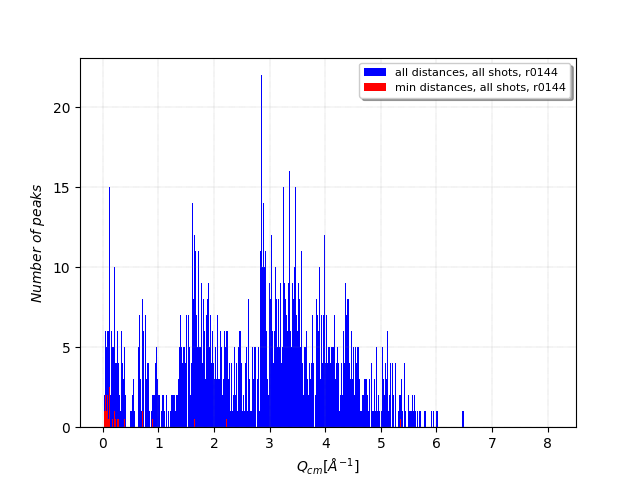

In [134]:
plt.figure()
binwidth = 0.01
hist_tot = np.zeros((811))
hist_min_tot = np.zeros((811))
binedges = np.arange(0-binwidth/2,8.1+binwidth/2,binwidth)
run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0144_type1-peaks_with_q.h5'
run_144 = h5py.File(run_path,'r')
shots = [x for x in run_144['shots'].keys()]
for shot_n,each_shot in enumerate(shots):
    n_peaks = run_144['shots'][each_shot]['numberOfPeaks'][()]
    try:
        qcm_x = run_144['shots'][each_shot]['peakCenterOfMassQx'][()]
        qcm_y = run_144['shots'][each_shot]['peakCenterOfMassQy'][()]
    except:
        pass   
    q_cm = list(zip(qcm_x,qcm_y))
    d = distance.cdist(q_cm,q_cm)
    all_dist = [d[np.nonzero(d)]]
    distances = np.array(all_dist).flatten()
    try:
        min_dist = [np.min(d[np.nonzero(d)])]
    except:
        pass
    min_distances = np.array(min_dist).flatten()
    yhist, bin_edges = np.histogram(distances, bins=binedges)
    minhist, bin_edges = np.histogram(min_distances, bins=binedges)
    yhist = yhist/2
    minhist = minhist/2
    hist_tot += yhist
    hist_min_tot += minhist
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
plt.bar(bin_centers, hist_tot,  color='b', width=binwidth, label = 'all distances, all shots, r0144')
plt.bar(bin_centers, hist_min_tot, color='r', width=binwidth, label = 'min distances, all shots, r0144')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q_{cm} [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

<IPython.core.display.Javascript object>


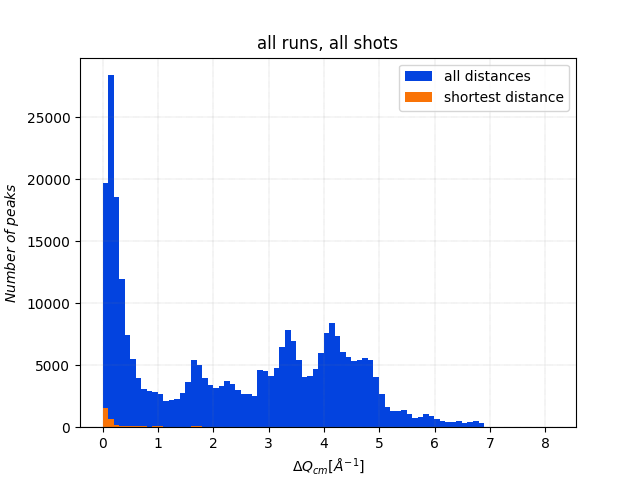

In [136]:
# peak numbers vs q_cm
plt.figure()
binwidth = 0.01
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
for i,run in enumerate(run_list.keys()):
    new_bins, new_all_dists = downsample(bin_centers, all_distance[i], size=10)
    new_bins, new_min_dists = downsample(bin_centers, min_distance[i], size=10)
    if i == 0:
        sum_all_dists = new_all_dists
        sum_min_dists = new_min_dists
    else:
        sum_all_dists += new_all_dists
        sum_min_dists += new_min_dists
    #plt.bar(bin_centers, all_distance[i],  color='#0343DF', width=binwidth)
    #plt.bar(bin_centers, min_distance[i], color='#F97306', width=binwidth)
plt.bar(new_bins, sum_all_dists,  color='#0343DF', width=binwidth*10)
plt.bar(new_bins, sum_min_dists, color='#F97306', width=binwidth*10)
plt.legend(['all distances','shortest distance'])
plt.title('all runs, all shots', loc='center')
plt.xlabel('$\Delta Q_{cm} [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


<IPython.core.display.Javascript object>


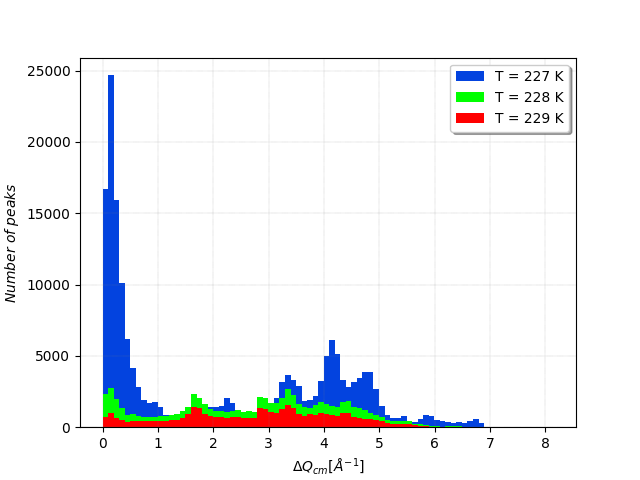

In [137]:
# peak numbers vs q_cm for the warm temperatures
plt.figure()
binwidth = 0.01
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
for i,run in enumerate(T_w):
    new_bins, new_T_w_dists = downsample(bin_centers, all_T_w[i], size=10)
    new_bins, new_min_T_w = downsample(bin_centers, min_T_w[i], size=10)
    if i == 0:
        sum_T_w_dists = new_T_w_dists
        sum_min_T_w = new_min_T_w
    else:
        sum_T_w_dists += new_T_w_dists
        sum_min_T_w += new_min_T_w
        
for i,run in enumerate(T_m):
    new_bins, new_T_m_dists = downsample(bin_centers, all_T_m[i], size=10)
    new_bins, new_min_T_m = downsample(bin_centers, min_T_m[i], size=10)
    if i == 0:
        sum_T_m_dists = new_T_m_dists
        sum_min_T_m = new_min_T_m
    else:
        sum_T_m_dists += new_T_m_dists
        sum_min_T_m += new_min_T_m
        
for i,run in enumerate(T_c):
    new_bins, new_T_c_dists = downsample(bin_centers, all_T_c[i], size=10)
    new_bins, new_min_T_c = downsample(bin_centers, min_T_c[i], size=10)
    if i == 0:
        sum_T_c_dists = new_T_c_dists
        sum_min_T_c = new_min_T_c
    else:
        sum_T_c_dists += new_T_c_dists
        sum_min_T_c += new_min_T_c
        

    #plt.bar(bin_centers, all_distance[i],  color='#0343DF', width=binwidth)
    #plt.bar(bin_centers, min_distance[i], color='#F97306', width=binwidth)
plt.bar(new_bins, sum_T_c_dists, color='#0343DF', width=binwidth*10, label = 'T = 227 K')
plt.bar(new_bins, sum_T_m_dists, color='#00FF00', width=binwidth*10, label = 'T = 228 K')
plt.bar(new_bins, sum_T_w_dists,  color='r', width=binwidth*10, label = 'T = 229 K')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$\Delta Q_{cm} [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


<IPython.core.display.Javascript object>


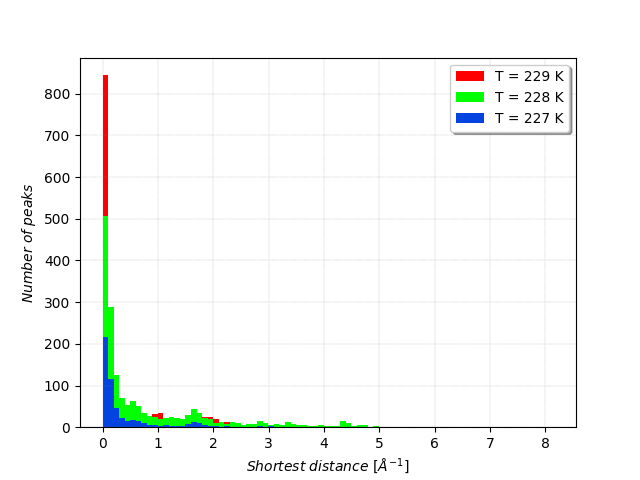

In [55]:
plt.figure()
plt.bar(new_bins, sum_min_T_c,  color='r', width=binwidth*10, label = 'T = 229 K')
plt.bar(new_bins, sum_min_T_m, color='#00FF00', width=binwidth*10, label = 'T = 228 K')
plt.bar(new_bins, sum_min_T_w, color='#0343DF', width=binwidth*10, label = 'T = 227 K')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$Shortest\ distance\ [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


In [56]:
x = run_144['shots']['LCLS_2011_Feb28_r0144_163006_2feb_cspad']['peakCenterOfMassQx'][()]

In [57]:
y = run_144['shots']['LCLS_2011_Feb28_r0144_163006_2feb_cspad']['peakCenterOfMassQy'][()]

In [58]:
list(zip(x,y))

[(0.4129202616777565, -1.8791951968943919),
 (-0.1061886510865614, -1.7555068730843517),
 (-1.5011566055745893, -1.1997693692428788),
 (1.3349837223396062, -1.0429577522031999),
 (1.388212469801472, -1.0723652294081458),
 (-1.5117902525081894, -0.603837080807235),
 (-1.4534390318401775, 0.7423097255451431),
 (1.4034058846930053, 0.8601034558833442),
 (1.4400538365956388, 0.9560856872426438),
 (1.3962670055270654, 1.051083661773669),
 (-0.005267040374824249, 1.6958082694231058)]

In [62]:
def specific_shots(run, shot, path=None):
    '''
    open specific shots in a run and load its keys,
    '''
    if path is None:
        h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    else:
        h5path = path+'%s_type1-peaks.h5'%run
    h5file = h5py.File(h5path,'r')
    n_peaks = h5file['shots'][shot]['numberOfPeaks'][()]
    peak_list = []
    center_mass = []
    radius = []
    q_cm = []
    for i,j in enumerate(shot):
        try:
            peak_list.append(h5file['shots'][shot]['peak%d'%i]['diffraction'][:])
            center_mass.append(h5file['shots'][shot]['peak%d'%i]['centerOfMassInPixels'][:])
            radius.append(h5file['shots'][shot]['peak%d'%i]['radiusInPixels'][()])
            q_cm.append(h5file['shots'][shot]['peak%d'%i]['peakCenterOfMassQMagnitude'][:])
        except:
            pass
    h5file.close()
    return  {'peaks': peak_list,
             'center_mass': center_mass,
             'q_cm': q_cm,
             'No_of_peaks': n_peaks,
             'radiusInPixels': radius}

In [650]:
#min_bound = iceIh_peaks()[0]-0.05
#max_bound = iceIh_peaks()[0]+0.05
filterout_c = Shot_for_sp(T_c, shots_below_c, choice = 'large_peaks', lower_bound = None, upper_bound=None)
filterout_w = Shot_for_sp(T_w, shots_below_w, choice = 'large_peaks', lower_bound = None, upper_bound=None)
filterout_m = Shot_for_sp(T_m, shots_below_m, choice = 'large_peaks', lower_bound = None, upper_bound=None)

In [703]:
large_q_c_blw = [list(d_values(filterout_c, 3))[x]['q_cm'] for x in range(len(list(d_values(filterout_c, 3))))]
large_q_c_blw = np.array(sorted(itertools.chain(*large_q_c_blw))).T

In [704]:
large_q_w_blw = [list(d_values(filterout_w, 3))[t]['q_cm'] for t in range(len(list(d_values(filterout_w, 3))))]
large_q_w_blw = np.array(sorted(itertools.chain(*large_q_w_blw))).T

In [705]:
large_q_m_blw = [list(d_values(filterout_m, 3))[k]['q_cm'] for k in range(len(list(d_values(filterout_m, 3))))]
large_q_m_blw = np.array(sorted(itertools.chain(*large_q_m_blw))).T

In [706]:
zs = [list(filterout_c[run].keys()) for run in T_c]
fg = np.array(sorted(itertools.chain(*zs))).T
rt = np.array([len([s for s in fg if n in s]) for n in T_c])

In [707]:
cv = [list(filterout_w[run].keys()) for run in T_w]
fg = np.array(sorted(itertools.chain(*cv))).T
gt = np.array([len([s for s in fg if n in s]) for n in T_w])

In [708]:
df = [list(filterout_m[run].keys()) for run in T_m]
fg = np.array(sorted(itertools.chain(*df))).T
sl = np.array([len([s for s in fg if n in s]) for n in T_m])

In [63]:
below50ADUs = {}
for n in files.keys():
    paths = 'below50ADUs_%s_common_shots.txt'%n
    with open(paths) as f:
        below50ADUs[n] = set([re.sub('-angavg.h5','',fname) for fname in set([fname.strip('\n') for fname in f.readlines()])])

In [64]:
below50ADUs['r0144']

{'LCLS_2011_Feb28_r0144_163103_7f8f_cspad',
 'LCLS_2011_Feb28_r0144_163149_c0f9_cspad',
 'LCLS_2011_Feb28_r0144_163414_18c1b_cspad',
 'LCLS_2011_Feb28_r0144_163529_1f560_cspad'}

In [65]:

for shot in below50ADUs['r0144']:
    print(shot)

LCLS_2011_Feb28_r0144_163529_1f560_cspad
LCLS_2011_Feb28_r0144_163103_7f8f_cspad
LCLS_2011_Feb28_r0144_163414_18c1b_cspad
LCLS_2011_Feb28_r0144_163149_c0f9_cspad


In [544]:
np.mean(peak_per_shot_blw_c), np.mean(peak_per_shot_blw_m), np.mean(peak_per_shot_blw_w)

(8.151420786298171, 2.428476821192053, 2.912621359223301)

In [529]:
shot_in_run_blw_c = []
peak_per_shot_blw_c = []
q_c_50ADUs = []
for i,run in enumerate(T_c):
    shot = list(below50ADUs[run])
    for el in shot:
        shot_in_run_blw_c.append(el)
        peak_per_shot_blw_c.append(specific_shots(run, el)['No_of_peaks'])
        q_c_50ADUs.append(specific_shots(run, el)['q_cm'])
q_c_50ADUs = np.array(sorted(itertools.chain(*q_c_50ADUs))).T

In [531]:
shot_in_run_blw_m = []
peak_per_shot_blw_m = []
q_m_50ADUs = []
for i,run in enumerate(T_m):
    shot = list(below50ADUs[run])
    for el in shot:
        shot_in_run_blw_m.append(el)
        peak_per_shot_blw_m.append(specific_shots(run, el)['No_of_peaks'])
        q_m_50ADUs.append(specific_shots(run, el)['q_cm'])
        
q_m_50ADUs = np.array(sorted(itertools.chain(*q_m_50ADUs))).T

In [532]:
shot_in_run_blw_w = []
peak_per_shot_blw_w = []
q_w_50ADUs = []
for i,run in enumerate(T_w):
    shot = list(below50ADUs[run])
    for el in shot:
        shot_in_run_blw_w.append(el)
        peak_per_shot_blw_w.append(specific_shots(run, el)['No_of_peaks'])
        q_w_50ADUs.append(specific_shots(run, el)['q_cm'])
        
q_w_50ADUs = np.array(sorted(itertools.chain(*q_w_50ADUs))).T

In [533]:
shot_N_blw_c = np.array([len([s for s in shot_in_run_blw_c if n in s]) for n in T_c])

In [535]:
shot_N_blw_m = np.array([len([s for s in shot_in_run_blw_m if n in s]) for n in T_m])

In [536]:
shot_N_blw_w = np.array([len([s for s in shot_in_run_blw_w if n in s]) for n in T_w])

In [726]:
np.shape(q_w_50ADUs)[1] - np.shape(large_q_w_blw)[0]

11

<IPython.core.display.Javascript object>


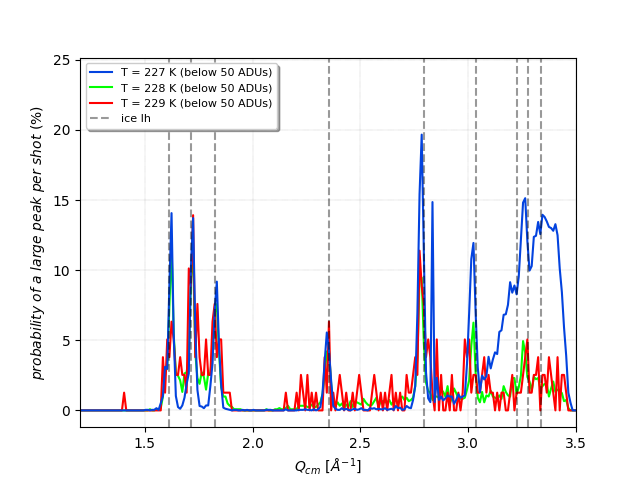

In [728]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.001
binedges = np.arange(0-binwidth/2,5.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(large_q_w_blw, bins=binedges)
yhist_m, bin_edges_m = np.histogram(large_q_m_blw, bins=binedges)
yhist_c, bin_edges_c = np.histogram(large_q_c_blw, bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

#T_227 = plt.bar(new_bins, new_q_cm_c,  color='#0343DF', width=binwidth*10, label= 'T = 227 K')
#T_228 = plt.bar(new_bins, new_q_cm_m,  color='#00FF00', width=binwidth*10, label = 'T = 228 K')
#T_229 = plt.bar(new_bins, new_q_cm_w,  color='r', width=binwidth*10, label = 'T = 229 K')

#T_228, = plt.plot(new_bins, (new_q_cm_m/new_q_cm_m.sum())*100,  color='#00FF00', label = 'T = 228 K')
#T_229, = plt.plot(new_bins, (new_q_cm_w/new_q_cm_w.sum())*100,  color='r', label = 'T = 229 K')
#T_227, = plt.plot(new_bins, (new_q_cm_c/new_q_cm_c.sum())*100,  color='#0343DF', label= 'T = 227 K')

T_228, = plt.plot(new_bins, (new_q_cm_m/sl.sum())*100,  color='#00FF00', label = 'T = 228 K')
T_229, = plt.plot(new_bins, (new_q_cm_w/gt.sum())*100,  color='r', label = 'T = 229 K')
T_227, = plt.plot(new_bins, (new_q_cm_c/rt.sum())*100,  color='#0343DF', label= 'T = 227 K')

xposition = iceIh_peaks()
for x,xc in enumerate(xposition[:-1]):
    ice_plot = plt.axvline(x=xc, color='k', linestyle='--', alpha=0.4)

plt.legend(handles=[T_227, T_228, T_229, ice_plot], labels=['T = 227 K (below 50 ADUs)', 'T = 228 K (below 50 ADUs)', 'T = 229 K (below 50 ADUs)', 'ice Ih'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q_{cm}\ [\AA^{-1}]$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
plt.ylabel('$probability\ of\ a\ large\ peak\ per\ shot\ (\%)$')
plt.xlim(1.2, 3.5)
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


In [91]:
shots_below_w = {}
for i,run in enumerate(T_w):
    shots_below_w[run] = below50ADUs[run]

In [92]:
shots_below_m = {}
for i,run in enumerate(T_m):
    shots_below_m[run] = below50ADUs[run]

In [93]:
shots_below_c = {}
for i,run in enumerate(T_c):
    shots_below_c[run] = below50ADUs[run]

In [94]:
all_shots_w = {}
for i,run in enumerate(T_w):
    h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    h5file = h5py.File(h5path,'r')
    #shots = [x for x in h5file['shots'].keys()]
    all_shots_w[run] = {x for x in h5file['shots'].keys()}

In [95]:
all_shots_m = {}
for i,run in enumerate(T_m):
    h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    h5file = h5py.File(h5path,'r')
    #shots = [x for x in h5file['shots'].keys()]
    all_shots_m[run] = {x for x in h5file['shots'].keys()}

In [96]:
all_shots_c = {}
for i,run in enumerate(T_c):
    h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    h5file = h5py.File(h5path,'r')
    #shots = [x for x in h5file['shots'].keys()]
    all_shots_c[run] = {x for x in h5file['shots'].keys()}

In [475]:
above_50ADUs_w = {}
for i,run in enumerate(T_w):
    above_50ADUs_w[run] = all_shots_w[run].difference(shots_below_w[run])

In [476]:
above_50ADUs_m = {}
for i,run in enumerate(T_m):
    above_50ADUs_m[run] = all_shots_m[run].difference(shots_below_m[run])

In [477]:
above_50ADUs_c = {}
for i,run in enumerate(T_c):
    above_50ADUs_c[run] = all_shots_c[run].difference(shots_below_c[run])

In [501]:
shot_in_run_w = []
q_w_above = []
peak_per_shot_w = []
for i,run in enumerate(T_w):
    shot = list(above_50ADUs_w[run])
    for el in shot:
        shot_in_run_w.append(el)
        peak_per_shot_w.append(specific_shots(run, el)['No_of_peaks'])
        q_w_above.append(specific_shots(run, el)['q_cm'])
        
q_w_above = np.array(sorted(itertools.chain(*q_w_above))).T

In [505]:
np.mean(peak_per_shot_w), np.mean(peak_per_shot_m), np.mean(peak_per_shot_c)

(8.39272030651341, 6.503586800573888, 5.857451403887689)

In [503]:
shot_in_run_m = []
q_m_above = []
peak_per_shot_m = []
for i,run in enumerate(T_m):
    shot = list(above_50ADUs_m[run])
    for el in shot:
        shot_in_run_m.append(el)
        peak_per_shot_m.append(specific_shots(run, el)['No_of_peaks'])
        q_m_above.append(specific_shots(run, el)['q_cm'])

q_m_above = np.array(sorted(itertools.chain(*q_m_above))).T

In [504]:
shot_in_run_c = []
peak_per_shot_c = []
q_c_above = []
for i,run in enumerate(T_c):
    shot = list(above_50ADUs_c[run])
    for el in shot:
        shot_in_run_c.append(el)
        peak_per_shot_c.append(specific_shots(run, el)['No_of_peaks'])
        q_c_above.append(specific_shots(run, el)['q_cm'])
            
q_c_above = np.array(sorted(itertools.chain(*q_c_above))).T

In [492]:
shot_N_w = np.array([len([s for s in shot_in_run_w if n in s]) for n in T_w])

In [493]:
shot_N_m = np.array([len([s for s in shot_in_run_m if n in s]) for n in T_m])

In [494]:
shot_N_c = np.array([len([s for s in shot_in_run_c if n in s]) for n in T_c])

<IPython.core.display.Javascript object>


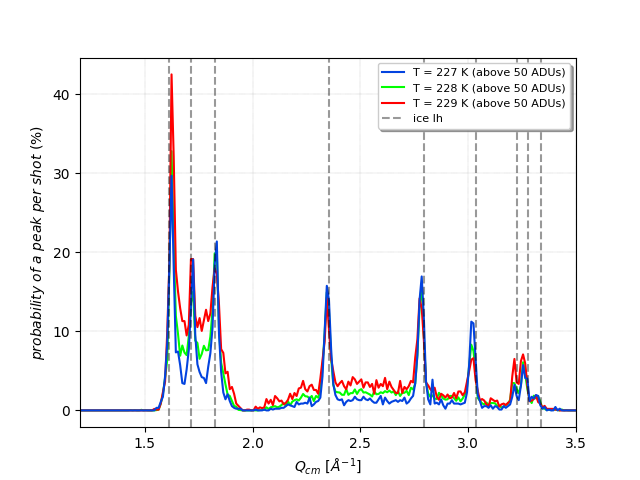

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [528]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.001
binedges = np.arange(0-binwidth/2,5.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(np.array(q_w_above), bins=binedges)
yhist_m, bin_edges_m = np.histogram(np.array(q_m_above), bins=binedges)
yhist_c, bin_edges_c = np.histogram(np.array(q_c_above), bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

#T_228 = plt.bar(new_bins, new_q_cm_m,  color='#00FF00', width=binwidth*10, label = 'T = 228 K')
#T_229 = plt.bar(new_bins, new_q_cm_w,  color='r', width=binwidth*10, label = 'T = 229 K')
#T_227 = plt.bar(new_bins, new_q_cm_c,  color='#0343DF', width=binwidth*10, label= 'T = 227 K')

#T_228, = plt.plot(new_bins, (new_q_cm_m/new_q_cm_m.sum())*100,  color='#00FF00', label = 'T = 228 K')
#T_229, = plt.plot(new_bins, (new_q_cm_w/new_q_cm_w.sum())*100,  color='r', label = 'T = 229 K')
#T_227, = plt.plot(new_bins, (new_q_cm_c/new_q_cm_c.sum())*100,  color='#0343DF', label= 'T = 227 K')

T_228, = plt.plot(new_bins, (new_q_cm_m/shot_N_m.sum())*100,  color='#00FF00', label = 'T = 228 K')
T_229, = plt.plot(new_bins, (new_q_cm_w/shot_N_w.sum())*100,  color='r', label = 'T = 229 K')
T_227, = plt.plot(new_bins, (new_q_cm_c/shot_N_c.sum())*100,  color='#0343DF', label= 'T = 227 K')

xposition = iceIh_peaks()
for x,xc in enumerate(xposition[:-1]):
    ice_plot = plt.axvline(x=xc, color='k', linestyle='--', alpha=0.4)

plt.legend(handles=[T_227, T_228, T_229, ice_plot], labels=['T = 227 K (above 50 ADUs)', 'T = 228 K (above 50 ADUs)', 'T = 229 K (above 50 ADUs)', 'ice Ih'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)

plt.xlabel('$Q_{cm}\ [\AA^{-1}]$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
plt.ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
plt.xlim(1.2, 3.5)
#plt.ylim(0,5.3)
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/test.eps', format='eps')
plt.show()  


In [350]:
iceIh_peaks()[0]+0.05 , (iceIh_peaks()[0]-0.05)

(1.6629747567439563, 1.5629747567439563)

In [107]:
def sp_low_pix(T_group, shots, size_thr = (10,10), choice = 'large_peaks', lower_bound=None, upper_bound=None):
    sp_list = []
    for n, run in enumerate(T_group):
        for shot in shots[run]:
            p_n = specific_shots(run, shot)['peaks']
            for peak_i in np.arange(len(p_n)):
                p_sub = p_n[peak_i] - BG_level
                p_mask = p_sub > photon_threshold
                fill_holes = binary_fill_holes(p_mask)
                labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
                peak_regions = scipy.ndimage.find_objects(labeled_image)
                for p,i in enumerate(peak_regions):
                    if (choice == 'large_peaks') & (np.shape(fill_holes[i]) >= size_thr):
                        contour,_= cv2.findContours(fill_holes[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                        for cnt in contour:
                            perimeter = cv2.arcLength(cnt, True)
                            area = cv2.contourArea(cnt)
                            if perimeter != 0:
                                sphericity = 4*np.pi*area/(perimeter**2)
                                if (lower_bound is not None) and (upper_bound is not None):
                                    if (sphericity >= lower_bound) & (sphericity < upper_bound):
                                        sp_list.append(sphericity)
                                else:
                                    sp_list.append(sphericity)
                    elif (choice == 'small_peaks') & (np.shape(fill_holes[i]) < size_thr):
                        contour,_= cv2.findContours(fill_holes[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                        for cnt in contour:
                            perimeter = cv2.arcLength(cnt, True)
                            area = cv2.contourArea(cnt)
                            if perimeter != 0:
                                sphericity = 4*np.pi*area/(perimeter**2)
                                if (lower_bound is not None) and (upper_bound is not None):
                                    if (sphericity >= lower_bound) & (sphericity < upper_bound):
                                        sp_list.append(sphericity)
                                else:
                                    sp_list.append(sphericity)
    return sp_list

In [108]:
# method 2 thresholding the whole image and set everything below threshold equal to zero
## find peak regions based on the value of the threshold

wavelength = np.array([run_list[run]['wavelength'] for run in run_list.keys()])*1e10
detector_distance = np.array([run_list[run]['detector_distance'] for run in run_list.keys()])
wavelength = np.mean(wavelength)
detector_distance = np.mean(detector_distance)
pixel_size = 109.92*1e-6
center_of_detector_pixels = [(1760-1)/2, (1760-1)/2]

img_shape = 1760
center = None
x = np.arange(img_shape)
y = np.arange(img_shape)
xx, yy = np.meshgrid(x, y)
if center is None:
    xx = xx.astype(np.float64) - (img_shape-1)/2
    yy = yy.astype(np.float64) - (img_shape-1)/2
else:
    xx -= center[1]
    yy -= center[0]
rad = np.sqrt(xx*xx + yy*yy)
qx = 2.*np.pi*2.*np.sin(0.5*np.arctan2(xx*pixel_size, detector_distance))/(wavelength)
qy = 2.*np.pi*2.*np.sin(0.5*np.arctan2(yy*pixel_size, detector_distance))/(wavelength)


In [352]:
'''
def create_dict_levels(Dict, run, shot, peak, region=None):
    try:
        d = Dict[run]
    except KeyError:
        Dict[run] = {}
    try:
        d = Dict[run][shot]
    except KeyError:
        Dict[run][shot] = {}
    try:
        d = Dict[run][shot]['peak%d'%peak]
    except KeyError:
        Dict[run][shot]['peak%d'%peak] = {}
    try:
        if region is not None:
            d = Dict[run][shot]['peak%d'%peak]['region%d'%region]
    except KeyError:
        Dict[run][shot]['peak%d'%peak]['region%d'%region] = {}
    return Dict

def Shot_for_sp(T_group, shots, area_thr = 10, choice = 'large_peaks', lower_bound=None, upper_bound=None):
    Dict = {}
    for n, run in enumerate(T_group):
        #Dict[run] = {}
        for shot in shots[run]:
            #Dict[run][shot] = {}
            p_n = specific_shots(run, shot)['peaks']
            cm = specific_shots(run, shot)['center_mass']
            for peak_i in np.arange(len(p_n)):
                #Dict[run][shot]['peak%d'%peak_i] = {}
                #cm = specific_shots(run, shot)['center_mass']
                #filtered = gaussian_filter(p_n[peak_i], sigma=0, mode='nearest')
                blur = skimage.filters.gaussian(p_n[peak_i], sigma=1)
                t = skimage.filters.threshold_otsu(blur)
                p_mask = blur > t
                #p_sub = filtered - BG_level
                #p_mask = p_sub > photon_threshold
                fill_holes = binary_fill_holes(p_mask)
                #processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
                labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
                peak_regions = scipy.ndimage.find_objects(labeled_image)
                #contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                #for c in contours:
                #    perimeter = cv2.arcLength(cnt, True)
                #    area = cv2.contourArea(cnt)
                #    M = cv2.moments(cnt)
                #    if M['m00'] != 0:
                #        cx = int(M['m10']/M['m00'])
                #        cy = int(M['m01']/M['m00'])
                p_offset = 0
                for p,i in enumerate(peak_regions):
                    contour,_= cv2.findContours(fill_holes[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                    for cnt in range(len(contour)):
                        #Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)] = {}
                        perimeter = cv2.arcLength(contour[cnt], True)
                        area = cv2.contourArea(contour[cnt])
                        if perimeter != 0:
                            sphericity =4*np.pi*area/(perimeter**2)
                        else:
                            sphericity = None
                        #if (choice == 'large_peaks') & (np.shape(fill_holes[i]) >= size_thr):
                        if (choice == 'large_peaks') & (sphericity is not None) & (area >= area_thr):
                            if (lower_bound is not None) and (upper_bound is not None):
                                if (sphericity >= lower_bound) & (sphericity < upper_bound):
                                    Dict = create_dict_levels(Dict, run, shot, peak_i, p+p_offset+cnt)
                                    Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm
                                    Dict[run][shot]['peak%d'%peak_i]['(qx, qy)'] = (qx,qy)
                                    Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['sphericity'] = sphericity
                                    Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['area'] = area
                                    #Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['area2'] = fill_holes[i].sum()
                                    Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['perimeter'] = perimeter
                                    #Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['shape'] = np.shape(fill_holes[i])
                            else:
                                Dict = create_dict_levels(Dict, run, shot, peak_i, p+p_offset+cnt)
                                Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm
                                Dict[run][shot]['peak%d'%peak_i]['(qx, qy)'] = (qx,qy)
                                Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['sphericity'] = sphericity
                                Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['area'] = area
                                #Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['area2'] = fill_holes[i].sum()
                                Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['perimeter'] = perimeter
                                #Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['shape'] = np.shape(fill_holes[i])
                        elif (choice == 'small_peaks') & (sphericity is not None) & (area < area_thr):
                            if (lower_bound is not None) and (upper_bound is not None):
                                if (sphericity >= lower_bound) & (sphericity < upper_bound):
                                    Dict = create_dict_levels(Dict, run, shot, peak_i, p+p_offset+cnt)
                                    Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm
                                    Dict[run][shot]['peak%d'%peak_i]['(qx, qy)'] = (qx,qy)
                                    Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['sphericity'] = sphericity
                                    Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['area'] = area
                                    #Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['area2'] = fill_holes[i].sum()
                                    Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['perimeter'] = perimeter
                                    #Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['shape'] = np.shape(fill_holes[i])
                            else:
                                Dict = create_dict_levels(Dict, run, shot, peak_i, p+p_offset+cnt)
                                Dict[run][shot]['peak%d'%peak_i]['region%d'%(p)]['q_cm'] = q_cm
                                Dict[run][shot]['peak%d'%peak_i]['region%d'%(p)]['(qx, qy)'] = (qx,qy)
                                Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['sphericity'] = sphericity
                                Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['area'] = area
                                #Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['area2'] = fill_holes[i].sum()
                                Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['perimeter'] = perimeter
                                #Dict[run][shot]['peak%d'%peak_i]['region%d'%(p+p_offset+cnt)]['shape'] = np.shape(fill_holes[i])  
                    if cnt > 0:
                        p_offset += cnt
                        #print('%s, %s: %d contours in one peak region %d of peak %d:' % (run, shot, cnt+1, p, peak_i))
                        #print(run, shot, p_n[peak_i], fill_holes[i])
                        #print(contour, contour[cnt])
                        #sys.exit()
    return Dict
'''

In [255]:
def create_dict_levels(Dict, run, shot, peak, region=None):
    try:
        d = Dict[run]
    except KeyError:
        Dict[run] = {}
    try:
        d = Dict[run][shot]
    except KeyError:
        Dict[run][shot] = {}
    try:
        d = Dict[run][shot]['peak%d'%peak]
    except KeyError:
        Dict[run][shot]['peak%d'%peak] = {}
    try:
        if region is not None:
            d = Dict[run][shot]['peak%d'%peak]['region%d'%region]
    except KeyError:
        Dict[run][shot]['peak%d'%peak]['region%d'%region] = {}
    return Dict

def Shot_for_sp(T_group, shots, area_thr = 10, choice = 'large_peaks', lower_bound=None, upper_bound=None):
    Dict = {}
    for n, run in enumerate(T_group):
        #Dict[run] = {}
        for shot in shots[run]:
            #Dict[run][shot] = {}
            p_n = specific_shots(run, shot)['peaks']
            q_cm = specific_shots(run, shot)['q_cm']
            for peak_i in np.arange(len(p_n)):
                #Dict[run][shot]['peak%d'%peak_i] = {}
                #cm = specific_shots(run, shot)['center_mass']
                #filtered = gaussian_filter(p_n[peak_i], sigma=0, mode='nearest')
                blur = skimage.filters.gaussian(p_n[peak_i], sigma=1)
                t = skimage.filters.threshold_otsu(blur)
                p_mask = blur > t
                #p_sub = filtered - BG_level
                #p_mask = p_sub > photon_threshold
                fill_holes = binary_fill_holes(p_mask)
                labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
                peak_regions = scipy.ndimage.find_objects(labeled_image)
                contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                # remove peak regions
                lst_intensities = []
                for cnt in range(len(contours)):
                    cimg = np.zeros_like(p_n[peak_i])
                    cv2.drawContours(cimg, contours, cnt, color=255, thickness=-1)
                    # Access the image pixels and create a 1D numpy array then add to list
                    pts = np.where(cimg == 255)
                    lst_intensities.append(p_n[peak_i][pts].sum())
                local_maxima = len(lst_intensities)
                rel_intens = np.array([lst_intensities[z]/p_n[peak_i].sum() for z in range(len(lst_intensities))])
                desired_peak_inx = np.argmax(lst_intensities)
                perimeter = cv2.arcLength(contours[desired_peak_inx], True)
                area = cv2.contourArea(contours[desired_peak_inx])
                if perimeter != 0:
                    sphericity =4*np.pi*area/(perimeter**2)
                else:
                    sphericity = None 
                #if (choice == 'large_peaks') & (np.shape(fill_holes[i]) >= size_thr):
                if (choice == 'large_peaks') & (sphericity is not None) & (area >= area_thr):
                    if (lower_bound is not None) and (upper_bound is not None):
                        if (q_cm[peak_i] >= lower_bound) & (q_cm[peak_i] < upper_bound):
                            Dict = create_dict_levels(Dict, run, shot, peak_i)
                            Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm[peak_i]
                            Dict[run][shot]['peak%d'%peak_i]['sphericity'] = sphericity
                            Dict[run][shot]['peak%d'%peak_i]['area'] = area
                            Dict[run][shot]['peak%d'%peak_i]['perimeter'] = perimeter
                            Dict[run][shot]['peak%d'%peak_i]['rel_intensities'] = rel_intens
                            Dict[run][shot]['peak%d'%peak_i]['Number_of_maxima'] = local_maxima
                            #Dict[run][shot]['peak%d'%peak_i]['shape'] = np.shape(fill_holes[i])
                    else:
                        Dict = create_dict_levels(Dict, run, shot, peak_i)
                        Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm[peak_i]
                        Dict[run][shot]['peak%d'%peak_i]['sphericity'] = sphericity
                        Dict[run][shot]['peak%d'%peak_i]['area'] = area
                        Dict[run][shot]['peak%d'%peak_i]['perimeter'] = perimeter
                        Dict[run][shot]['peak%d'%peak_i]['rel_intensities'] = rel_intens
                        Dict[run][shot]['peak%d'%peak_i]['Number_of_maxima'] = local_maxima
                elif (choice == 'small_peaks') & (sphericity is not None) & (area < area_thr):
                    if (lower_bound is not None) and (upper_bound is not None):
                        if (q_cm[peak_i] >= lower_bound) & (q_cm[peak_i] < upper_bound):
                            Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm[peak_i]
                            Dict[run][shot]['peak%d'%peak_i]['sphericity'] = sphericity
                            Dict[run][shot]['peak%d'%peak_i]['area'] = area
                            Dict[run][shot]['peak%d'%peak_i]['perimeter'] = perimeter
                            Dict[run][shot]['peak%d'%peak_i]['rel_intensities'] = rel_intens
                            Dict[run][shot]['peak%d'%peak_i]['Number_of_maxima'] = local_maxima
                    else:
                        Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm[peak_i]
                        Dict[run][shot]['peak%d'%peak_i]['sphericity'] = sphericity
                        Dict[run][shot]['peak%d'%peak_i]['area'] = area
                        Dict[run][shot]['peak%d'%peak_i]['perimeter'] = perimeter
                        Dict[run][shot]['peak%d'%peak_i]['rel_intensities'] = rel_intens
                        Dict[run][shot]['peak%d'%peak_i]['Number_of_maxima'] = local_maxima
    return Dict

In [110]:
s_m_above = []
for n, run in enumerate(T_m):
    for shot in above_50ADUs_m[run]:
        p_n = specific_shots(run, shot)['peaks']
        for peak_i in np.arange(len(p_n)):
            p_sub = p_n[peak_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    s_m_above.append(sphericity)

In [111]:
s_c_above = []
for n, run in enumerate(T_c):
    for shot in above_50ADUs_c[run]:
        p_n = specific_shots(run, shot)['peaks']
        for peak_i in np.arange(len(p_n)):
            p_sub = p_n[peak_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    s_c_above.append(sphericity)

In [112]:
s_w_above = []
for n, run in enumerate(T_w):
    for shot in above_50ADUs_w[run]:
        p_n = specific_shots(run, shot)['peaks']
        for peak_i in np.arange(len(p_n)):
            p_sub = p_n[peak_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    s_w_above.append(sphericity)

In [113]:
s_w_below = []
for n, run in enumerate(T_w):
    for shot in shots_below_w[run]:
        p_n = specific_shots(run, shot)['peaks']
        for peak_i in np.arange(len(p_n)):
            p_sub = p_n[peak_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    s_w_below.append(sphericity)

In [114]:
s_m_below = []
for n, run in enumerate(T_m):
    for shot in shots_below_m[run]:
        p_n = specific_shots(run, shot)['peaks']
        for peak_i in np.arange(len(p_n)):
            p_sub = p_n[peak_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    s_m_below.append(sphericity)

In [115]:
s_c_below = []
for n, run in enumerate(T_c):
    for shot in shots_below_c[run]:
        p_n = specific_shots(run, shot)['peaks']
        for peak_i in np.arange(len(p_n)):
            p_sub = p_n[peak_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    s_c_below.append(sphericity)

<IPython.core.display.Javascript object>


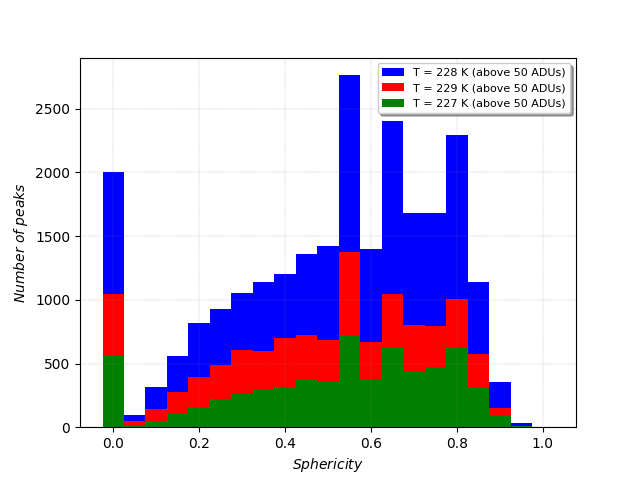

In [116]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.05
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(s_w_above, bins=binedges)
Sp_m, bin_edges = np.histogram(s_m_above, bins=binedges)
Sp_c, bin_edges = np.histogram(s_c_above, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K (above 50 ADUs)')
plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K (above 50 ADUs)')
plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K (above 50 ADUs)')

plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

<IPython.core.display.Javascript object>


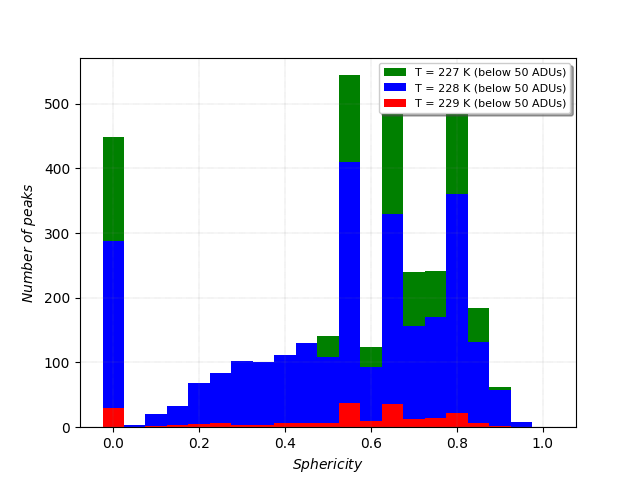

In [117]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.05
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(s_w_below, bins=binedges)
Sp_m, bin_edges = np.histogram(s_m_below, bins=binedges)
Sp_c, bin_edges = np.histogram(s_c_below, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K (below 50 ADUs)')
plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K (below 50 ADUs)')
plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K (below 50 ADUs)')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [118]:
def short_all_dist(run, binwidth=0.01, lower_bound=None, upper_bound=None):
    '''
    returns all distances in each shots for one run and also the minimum 
    distance among all distances for a shot
    
    '''
    hist_tot = np.zeros((811))
    hist_min_tot = np.zeros((811))
    binedges = np.arange(0-binwidth/2,8.1+binwidth/2,binwidth)
    run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    run_no = h5py.File(run_path,'r')
    shots = [x for x in run_no['shots'].keys()]
    if (lower_bound is not None) and (upper_bound is not None):
        shots_in_bounds = []
    else:
        shots_in_bounds = None
    for shot_n,each_shot in enumerate(shots):
        n_peaks = run_no['shots'][each_shot]['numberOfPeaks'][()]
        try:
            qcm_x = run_no['shots'][each_shot]['peakCenterOfMassQx'][()]
            qcm_y = run_no['shots'][each_shot]['peakCenterOfMassQy'][()]
        except:
            pass
        q_cm = list(zip(qcm_x,qcm_y))
        d = distance.cdist(q_cm,q_cm)
        all_dist = [d[np.nonzero(d)]]
        distances = np.array(all_dist).flatten()
        if (lower_bound is not None) and (upper_bound is not None):
            if np.any((distances >= lower_bound) & (distances < upper_bound)):
                shots_in_bounds.append(each_shot)
        try:
            min_dist = [np.min(d[np.nonzero(d)])]
        except:
            pass
        min_distances = np.array(min_dist).flatten()
        yhist, bin_edges = np.histogram(distances, bins=binedges)
        minhist, bin_edges = np.histogram(min_distances, bins=binedges)
        yhist = yhist/2
        minhist = minhist/2
        hist_tot += yhist
        hist_min_tot += minhist
    return hist_tot, hist_min_tot, shots_in_bounds

In [119]:
def dist_for_shot(run, shots, binwidth=0.01, lower_bound=None, upper_bound=None):
    '''
    returns all distances in each shots for one run and also the minimum 
    distance among all distances for a shot
    '''
    hist_tot = np.zeros((811))
    hist_min_tot = np.zeros((811))
    binedges = np.arange(0-binwidth/2,8.1+binwidth/2,binwidth)
    run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    run_no = h5py.File(run_path,'r')
    if (lower_bound is not None) and (upper_bound is not None):
        shots_in_bounds = []
    else:
        shots_in_bounds = None
    for shot_n,each_shot in enumerate(list(shots[run])):
        n_peaks = run_no['shots'][each_shot]['numberOfPeaks'][()]
        if n_peaks >= 1:
            qcm_x = run_no['shots'][each_shot]['peakCenterOfMassQx'][()]
            qcm_y = run_no['shots'][each_shot]['peakCenterOfMassQy'][()]
            q_cm = list(zip(qcm_x,qcm_y))
            d = distance.cdist(q_cm,q_cm)
            all_dist = [d[np.nonzero(d)]]
            distances = np.array(all_dist).flatten()
            if (lower_bound is not None) and (upper_bound is not None):
                if np.any((distances >= lower_bound) & (distances < upper_bound)):
                    shots_in_bounds.append(each_shot)
            try:
                min_dist = [np.min(d[np.nonzero(d)])]
                min_distances = np.array(min_dist).flatten()
                yhist, bin_edges = np.histogram(distances, bins=binedges)
                minhist, bin_edges = np.histogram(min_distances, bins=binedges)
                yhist = yhist/2
                minhist = minhist/2
                hist_tot += yhist
                hist_min_tot += minhist
            except:
                pass
    return hist_tot, hist_min_tot, shots_in_bounds

In [120]:
# warm temperatures runs 144 to 170
d_w_below = np.zeros((7,811))
min_dw_below = np.zeros((7,811))
for i,n in enumerate(T_w):
    T_w_below, min_Tw_below, _ = dist_for_shot(n, shots_below_w)
    d_w_below[i] = T_w_below
    min_dw_below[i] = min_Tw_below

In [121]:
d_m_below = np.zeros((5,811))
min_dm_below = np.zeros((5,811))
for i,n in enumerate(T_m):
    T_m_below, min_Tm_below, _ = dist_for_shot(n, shots_below_m)
    d_m_below[i] = T_m_below
    min_dm_below[i] = min_Tm_below

In [122]:
d_c_below = np.zeros((2,811))
min_dc_below = np.zeros((2,811))
for i,n in enumerate(T_c):
    T_c_below, min_Tc_below, _ = dist_for_shot(n, shots_below_c)
    d_c_below[i] = T_c_below
    min_dc_below[i] = min_Tc_below

<IPython.core.display.Javascript object>


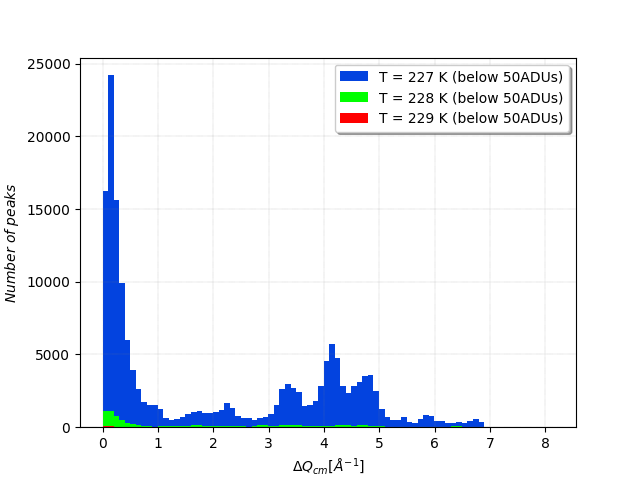

In [138]:
plt.figure()
binwidth = 0.01
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
for i,run in enumerate(T_w):
    new_bins, new_T_w_dists = downsample(bin_centers, d_w_below[i], size=10)
    new_bins, new_min_T_w = downsample(bin_centers, min_dw_below[i], size=10)
    if i == 0:
        sum_T_w_dists = new_T_w_dists
        sum_min_T_w = new_min_T_w
    else:
        sum_T_w_dists += new_T_w_dists
        sum_min_T_w += new_min_T_w
        
for i,run in enumerate(T_m):
    new_bins, new_T_m_dists = downsample(bin_centers, d_m_below[i], size=10)
    new_bins, new_min_T_m = downsample(bin_centers, min_dm_below[i], size=10)
    if i == 0:
        sum_T_m_dists = new_T_m_dists
        sum_min_T_m = new_min_T_m
    else:
        sum_T_m_dists += new_T_m_dists
        sum_min_T_m += new_min_T_m
        
for i,run in enumerate(T_c):
    new_bins, new_T_c_dists = downsample(bin_centers, d_c_below[i], size=10)
    new_bins, new_min_T_c = downsample(bin_centers, min_dc_below[i], size=10)
    if i == 0:
        sum_T_c_dists = new_T_c_dists
        sum_min_T_c = new_min_T_c
    else:
        sum_T_c_dists += new_T_c_dists
        sum_min_T_c += new_min_T_c
        

    #plt.bar(bin_centers, all_distance[i],  color='#0343DF', width=binwidth)
    #plt.bar(bin_centers, min_distance[i], color='#F97306', width=binwidth)
plt.bar(new_bins, sum_T_c_dists, color='#0343DF', width=binwidth*10, label = 'T = 227 K (below 50ADUs)')
plt.bar(new_bins, sum_T_m_dists, color='#00FF00', width=binwidth*10, label = 'T = 228 K (below 50ADUs)')
plt.bar(new_bins, sum_T_w_dists,  color='r', width=binwidth*10, label = 'T = 229 K (below 50ADUs)')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$\Delta Q_{cm} [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  

<IPython.core.display.Javascript object>


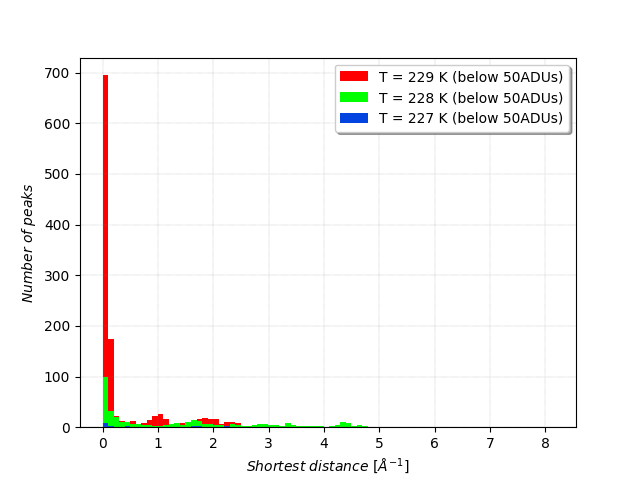

In [139]:
plt.figure()
plt.bar(new_bins, sum_min_T_c,  color='r', width=binwidth*10, label = 'T = 229 K (below 50ADUs)')
plt.bar(new_bins, sum_min_T_m, color='#00FF00', width=binwidth*10, label = 'T = 228 K (below 50ADUs)')
plt.bar(new_bins, sum_min_T_w, color='#0343DF', width=binwidth*10, label = 'T = 227 K (below 50ADUs)')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$Shortest\ distance\ [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  

In [140]:
# third one should be shot numbers
# the second one is peak numbers
len(shots_below_c['r0165']), sum(d_c_below[0]), sum(min_dc_below[0])

(2402, 166788.0, 1147.0)

In [141]:
# warm temperatures runs 144 to 170
d_w_above = np.zeros((7,811))
min_dw_above = np.zeros((7,811))
for i,n in enumerate(T_w):
    T_w_above, min_Tw_above, _ = dist_for_shot(n, above_50ADUs_w)
    d_w_above[i] = T_w_above
    min_dw_above[i] = min_Tw_above

In [142]:
d_m_above = np.zeros((5,811))
min_dm_above = np.zeros((5,811))
for i,n in enumerate(T_m):
    T_m_above, min_Tm_above, _ = dist_for_shot(n, above_50ADUs_m)
    d_m_above[i] = T_m_above
    min_dm_above[i] = min_Tm_above

In [143]:
d_c_above = np.zeros((2,811))
min_dc_above = np.zeros((2,811))
for i,n in enumerate(T_c):
    T_c_above, min_Tc_above, _ = dist_for_shot(n, above_50ADUs_c)
    d_c_above[i] = T_c_above
    min_dc_above[i] = min_Tc_above

<IPython.core.display.Javascript object>


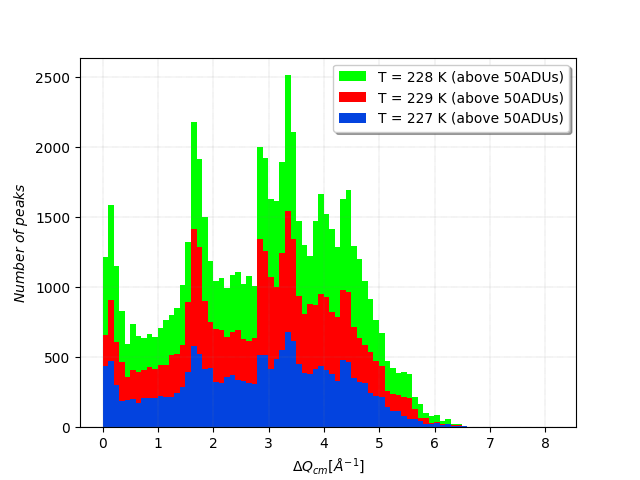

In [144]:
plt.figure()
binwidth = 0.01
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
for i,run in enumerate(T_w):
    new_bins, new_T_w_dists = downsample(bin_centers, d_w_above[i], size=10)
    new_bins, new_min_T_w = downsample(bin_centers, min_dw_above[i], size=10)
    if i == 0:
        sum_T_w_dists = new_T_w_dists
        sum_min_T_w = new_min_T_w
    else:
        sum_T_w_dists += new_T_w_dists
        sum_min_T_w += new_min_T_w
        
for i,run in enumerate(T_m):
    new_bins, new_T_m_dists = downsample(bin_centers, d_m_above[i], size=10)
    new_bins, new_min_T_m = downsample(bin_centers, min_dm_above[i], size=10)
    if i == 0:
        sum_T_m_dists = new_T_m_dists
        sum_min_T_m = new_min_T_m
    else:
        sum_T_m_dists += new_T_m_dists
        sum_min_T_m += new_min_T_m
        
for i,run in enumerate(T_c):
    new_bins, new_T_c_dists = downsample(bin_centers, d_c_above[i], size=10)
    new_bins, new_min_T_c = downsample(bin_centers, min_dc_above[i], size=10)
    if i == 0:
        sum_T_c_dists = new_T_c_dists
        sum_min_T_c = new_min_T_c
    else:
        sum_T_c_dists += new_T_c_dists
        sum_min_T_c += new_min_T_c
        

    #plt.bar(bin_centers, all_distance[i],  color='#0343DF', width=binwidth)
    #plt.bar(bin_centers, min_distance[i], color='#F97306', width=binwidth)
plt.bar(new_bins, sum_T_m_dists, color='#00FF00', width=binwidth*10, label = 'T = 228 K (above 50ADUs)')
plt.bar(new_bins, sum_T_w_dists,  color='r', width=binwidth*10, label = 'T = 229 K (above 50ADUs)')
plt.bar(new_bins, sum_T_c_dists, color='#0343DF', width=binwidth*10, label = 'T = 227 K (above 50ADUs)')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$\Delta Q_{cm} [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  

<IPython.core.display.Javascript object>


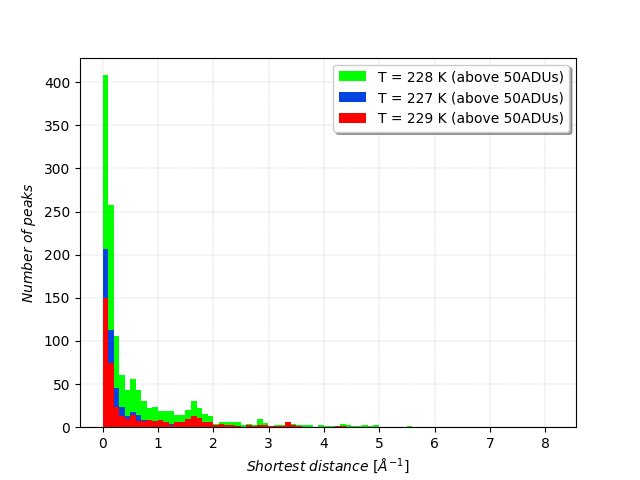

In [145]:
plt.figure()
plt.bar(new_bins, sum_min_T_m, color='#00FF00', width=binwidth*10, label = 'T = 228 K (above 50ADUs)')
plt.bar(new_bins, sum_min_T_w, color='#0343DF', width=binwidth*10, label = 'T = 227 K (above 50ADUs)')
plt.bar(new_bins, sum_min_T_c,  color='r', width=binwidth*10, label = 'T = 229 K (above 50ADUs)')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$Shortest\ distance\ [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show() 

In [146]:
_,_, peak_1 = dist_for_shot('r0171', above_50ADUs_m, lower_bound=4.3, upper_bound=4.4)

In [150]:
dd = dist_one_shot('r0144','LCLS_2011_Feb28_r0144_163006_2feb_cspad')[0][0][3]

In [151]:
#p = fill_holes[peak_regions[0]]
p = fill_holes[peak_regions[2]]
plt.figure()
plt.imshow(p, vmin=0, vmax=1)
plt.show()
contours,_= cv2.findContours(p.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
x_con = [contours[0][i][0][0] for i in range(len(contours[0]))]
y_con = [contours[0][i][0][1] for i in range(len(contours[0]))]
x_con.append(int(contours[0][0][0][0]))
y_con.append(int(contours[0][0][0][1]))
plt.plot(x_con, y_con, 'r-')
area2 = p.sum()
i = 0
for cnt in contours:
    #print(cnt)
    perimeter = cv2.arcLength(cnt, True)
    area = cv2.contourArea(cnt)
    print(i, perimeter, area, 4*np.pi*area/(perimeter**2), area2, 4*np.pi*area2/(perimeter**2))
    i += 1

NameError: name 'peak_regions' is not defined

In [ ]:
x_con = [contours[0][i][0][0] for i in range(len(contours[0]))]
y_con = [contours[0][i][0][1] for i in range(len(contours[0]))]
x_con.append(int(contours[0][0][0][0]))
y_con.append(int(contours[0][0][0][1]))

In [ ]:
x_con1= [contours[1][i][0][0] for i in range(len(contours[1]))]
y_con1= [contours[1][i][0][1] for i in range(len(contours[1]))]
x_con2 = [contours[3][i][0][0] for i in range(len(contours[3]))]
y_con2 = [contours[3][i][0][1] for i in range(len(contours[3]))]
x_con3= [contours[2][i][0][0] for i in range(len(contours[2]))]
y_con3= [contours[2][i][0][1] for i in range(len(contours[2]))]
x_con2.append(int(contours[3][0][0][0]))
x_con3.append(int(contours[2][0][0][0]))
y_con2.append(int(contours[3][0][0][1]))
y_con3.append(int(contours[2][0][0][1]))
x_con1.append(int(contours[1][0][0][0]))
y_con1.append(int(contours[1][0][0][1]))

In [123]:
#peak_diff = Shot_for_sp(T_m, above_50ADUs_m)['r0167']['LCLS_2011_Mar01_r0167_002412_7b2d_cspad']['peak0'][0][0]

In [ ]:
#fill_holes.astype(np.float32) - np.zeros(np.shape(peak_diff), dtype=bool)

In [152]:
def d_values(d, depth):
    if depth == 1:
        for i in d.values():
            yield i
    else:
        for v in d.values():
            if isinstance(v, dict):
                for i in d_values(v, depth-1):
                    yield i

<IPython.core.display.Javascript object>


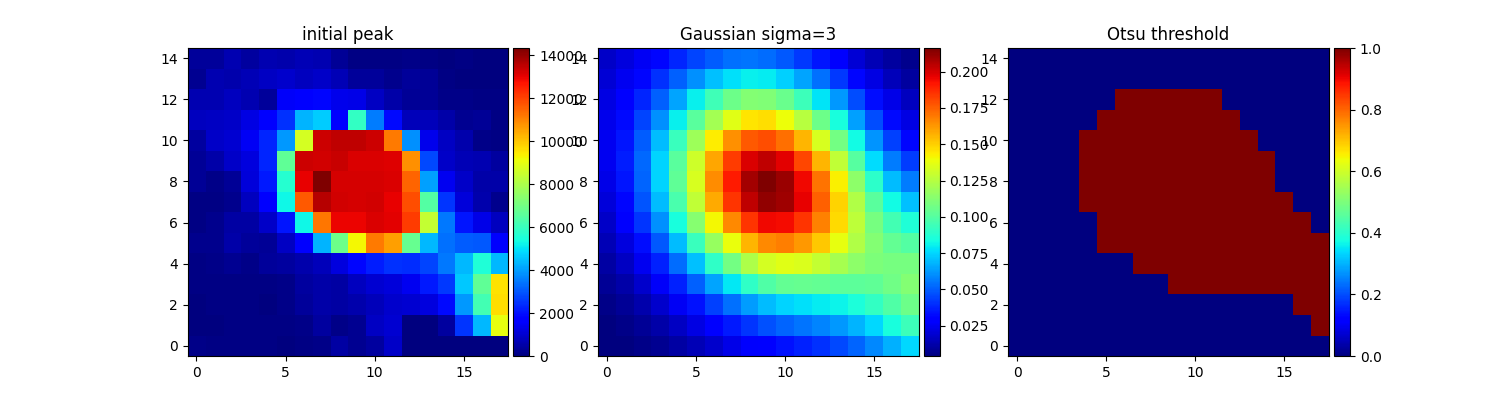

In [155]:
regionx = specific_shots('r0165', 'LCLS_2011_Feb28_r0165_232445_e106_cspad')['peaks'][2]
blur = skimage.filters.gaussian(regionx, sigma=3)
t = skimage.filters.threshold_otsu(blur)
mask = blur > t
fill_holes = binary_fill_holes(mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
#p = fill_holes[peak_regions[0]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133) 

im1 = ax1.imshow(regionx,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask, cmap='jet', origin = 'lower', aspect='auto')

divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)

cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')

ax1.set_title('initial peak')
ax2.set_title('Gaussian sigma=3')
ax3.set_title('Otsu threshold')
#plt.clim(vmin=0,vmax=400)
plt.show()

<IPython.core.display.Javascript object>


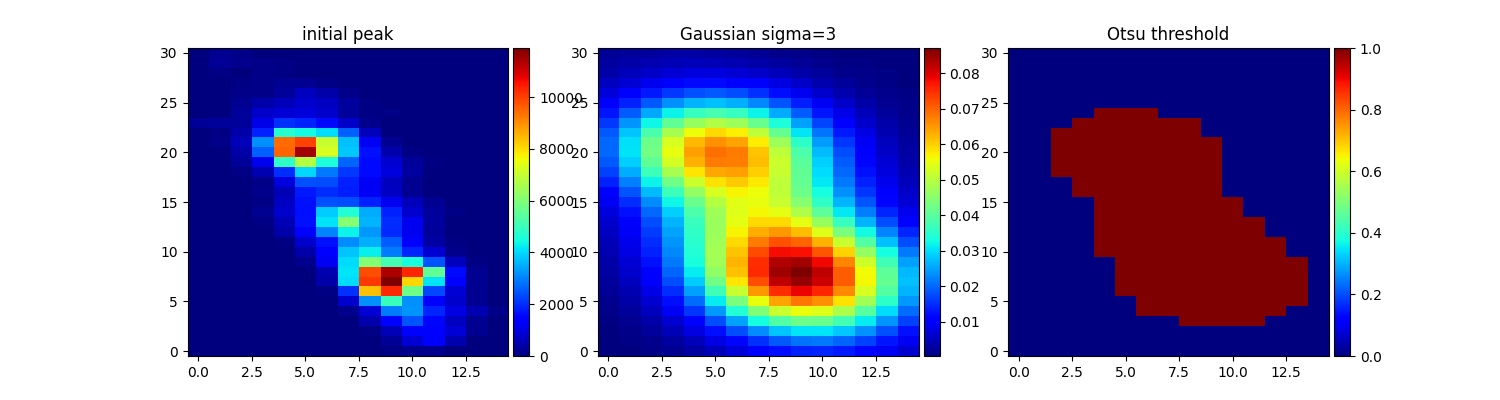

In [156]:
regionx = specific_shots('r0165', 'LCLS_2011_Feb28_r0165_232535_12792_cspad')['peaks'][2]
blur = skimage.filters.gaussian(regionx, sigma=3)
t = skimage.filters.threshold_otsu(blur)
mask = blur > t
fill_holes = binary_fill_holes(mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
#p = fill_holes[peak_regions[0]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133) 

im1 = ax1.imshow(regionx,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask, cmap='jet', origin = 'lower', aspect='auto')

divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)

cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')

ax1.set_title('initial peak')
ax2.set_title('Gaussian sigma=3')
ax3.set_title('Otsu threshold')
#plt.clim(vmin=0,vmax=400)
plt.show()

<IPython.core.display.Javascript object>


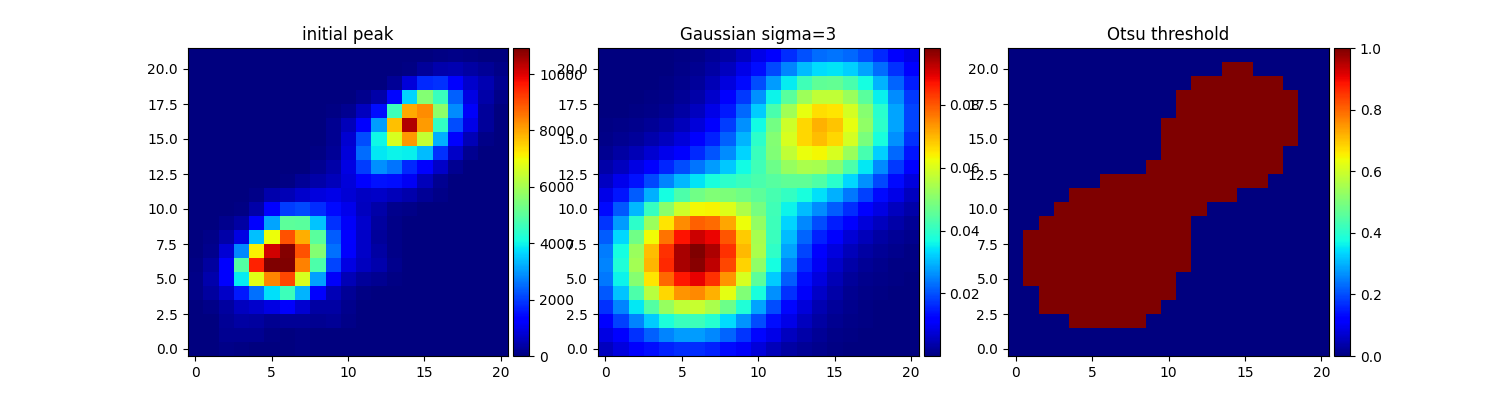

In [157]:
regionx = specific_shots('r0165', 'LCLS_2011_Feb28_r0165_232519_1115a_cspad')['peaks'][0]
blur = skimage.filters.gaussian(regionx, sigma=3)
t = skimage.filters.threshold_otsu(blur)
mask = blur > t
fill_holes = binary_fill_holes(mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
#p = fill_holes[peak_regions[0]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133) 

im1 = ax1.imshow(regionx,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask, cmap='jet', origin = 'lower', aspect='auto')

divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)

cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')

ax1.set_title('initial peak')
ax2.set_title('Gaussian sigma=3')
ax3.set_title('Otsu threshold')
#plt.clim(vmin=0,vmax=400)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


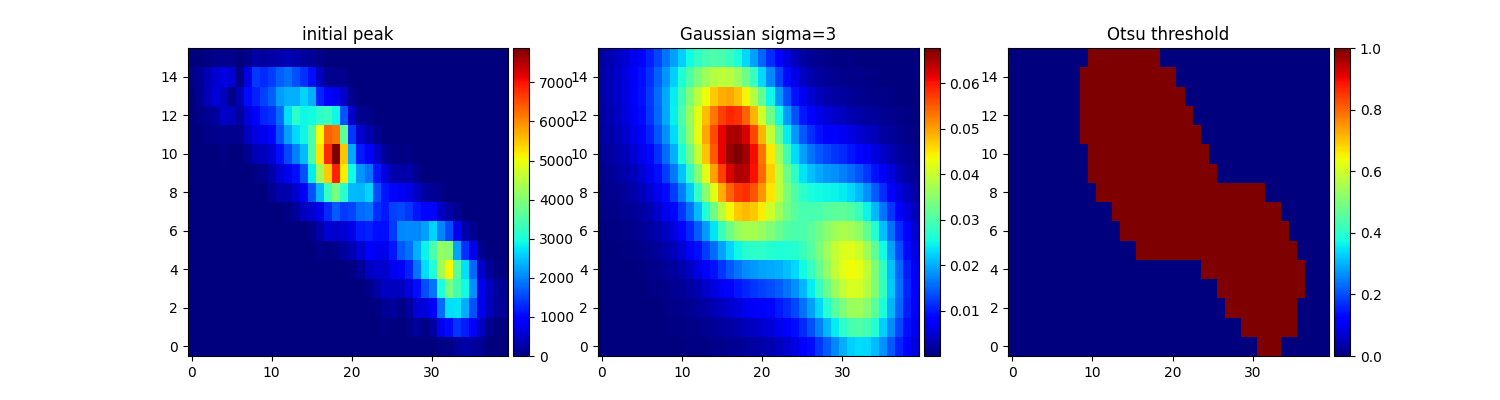

In [158]:
regionx = specific_shots('r0165', 'LCLS_2011_Feb28_r0165_232514_109a7_cspad')['peaks'][1]
blur = skimage.filters.gaussian(regionx, sigma=3)
t = skimage.filters.threshold_otsu(blur)
mask = blur > t
fill_holes = binary_fill_holes(mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
#p = fill_holes[peak_regions[0]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133) 

im1 = ax1.imshow(regionx,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask, cmap='jet', origin = 'lower', aspect='auto')

divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)

cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')

ax1.set_title('initial peak')
ax2.set_title('Gaussian sigma=3')
ax3.set_title('Otsu threshold')
#plt.clim(vmin=0,vmax=400)
plt.show()

<IPython.core.display.Javascript object>


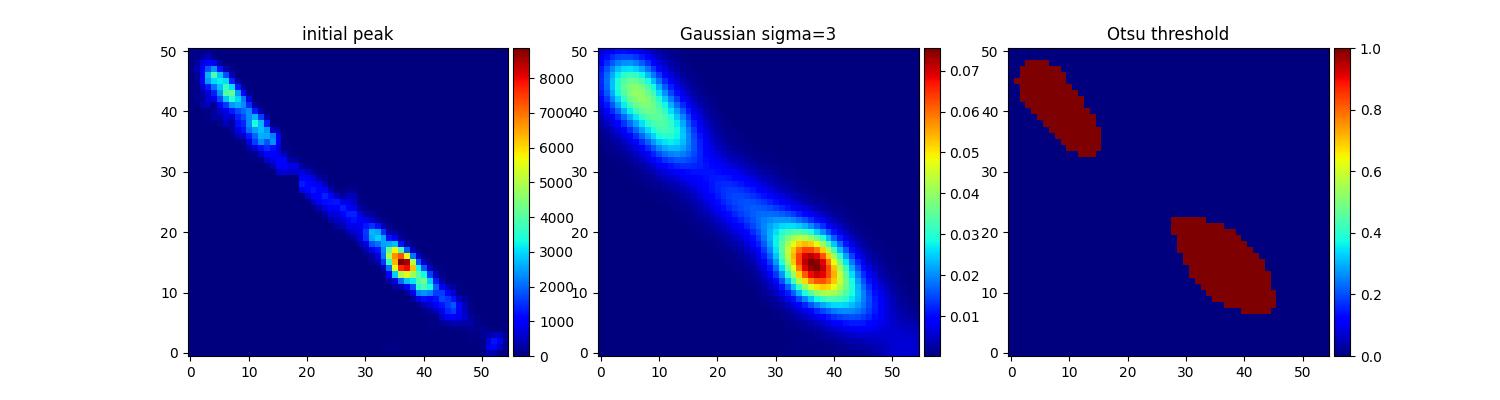

In [235]:
regionx = specific_shots('r0165', 'LCLS_2011_Feb28_r0165_232538_12b4c_cspad')['peaks'][0]
blur = skimage.filters.gaussian(regionx, sigma=3)
t = skimage.filters.threshold_otsu(blur)
mask = blur > t
fill_holes = binary_fill_holes(mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
#p = fill_holes[peak_regions[0]]
contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# remove peak regions
lst_intensities = []
for cnt in range(len(contours)):
    cimg = np.zeros_like(regionx)
    cv2.drawContours(cimg, contours, cnt, color=255, thickness=-1)
    # Access the image pixels and create a 1D numpy array then add to list
    pts = np.where(cimg == 255)
    lst_intensities.append(regionx[pts].sum())
local_maxima = len(lst_intensities)
    #perimeter = cv2.arcLength(contours[cnt], True)
                    #area = cv2.contourArea(contours[cnt])
                        #if perimeter != 0:
                            #sphericity =4*np.pi*area/(perimeter**2)
                        #else:
                            #sphericity = None
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133) 

im1 = ax1.imshow(regionx,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask, cmap='jet', origin = 'lower', aspect='auto')

divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)

cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')

ax1.set_title('initial peak')
ax2.set_title('Gaussian sigma=3')
ax3.set_title('Otsu threshold')
#plt.clim(vmin=0,vmax=400)
plt.show()

In [238]:
np.max(lst_intensities)

274614

<IPython.core.display.Javascript object>


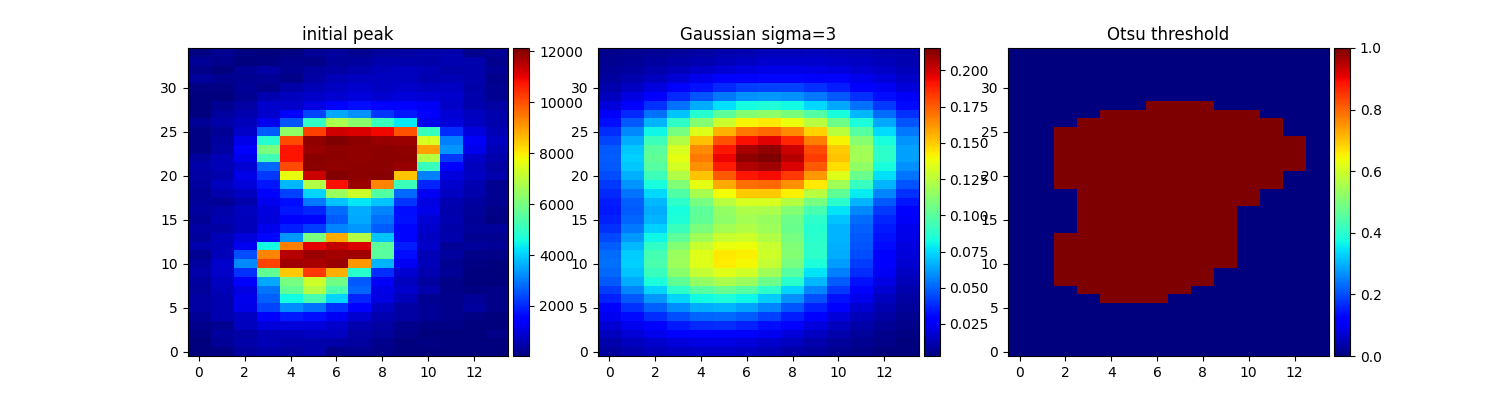

In [162]:
regionx = specific_shots('r0165', 'LCLS_2011_Feb28_r0165_233138_1268d_cspad')['peaks'][5]
blur = skimage.filters.gaussian(regionx, sigma=3)
t = skimage.filters.threshold_otsu(blur)
mask = blur > t
fill_holes = binary_fill_holes(mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
#p = fill_holes[peak_regions[0]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133) 

im1 = ax1.imshow(regionx,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask, cmap='jet', origin = 'lower', aspect='auto')

divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)

cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')

ax1.set_title('initial peak')
ax2.set_title('Gaussian sigma=3')
ax3.set_title('Otsu threshold')
#plt.clim(vmin=0,vmax=400)
plt.show()

<IPython.core.display.Javascript object>


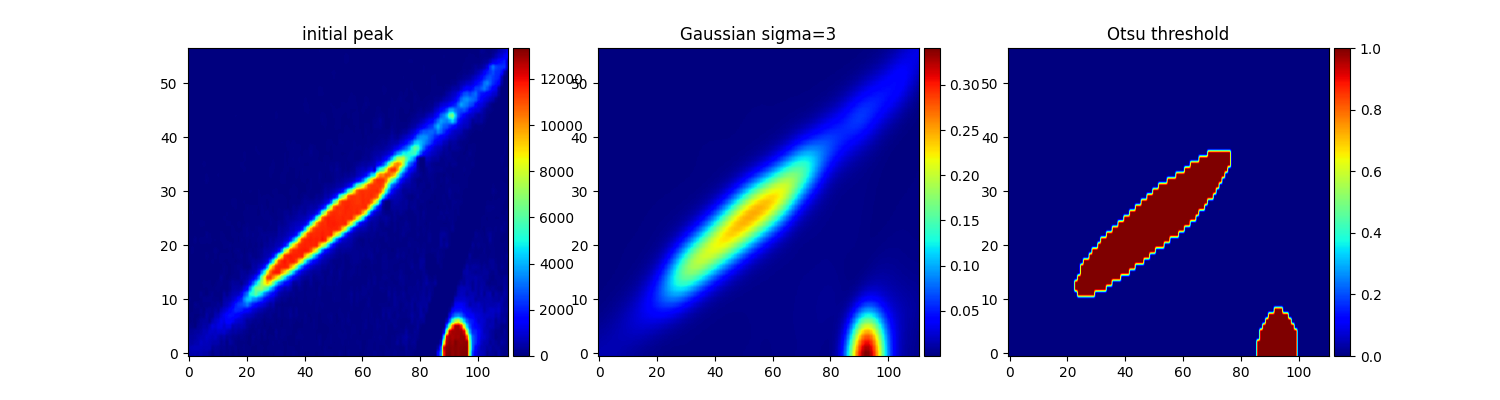

In [163]:
regionx = specific_shots('r0165', 'LCLS_2011_Feb28_r0165_232514_10a1f_cspad')['peaks'][5]
blur = skimage.filters.gaussian(regionx, sigma=3)
t = skimage.filters.threshold_otsu(blur)
mask = blur > t
fill_holes = binary_fill_holes(mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
#p = fill_holes[peak_regions[0]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133) 

im1 = ax1.imshow(regionx,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask, cmap='jet', origin = 'lower', aspect='auto')

divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)

cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')

ax1.set_title('initial peak')
ax2.set_title('Gaussian sigma=3')
ax3.set_title('Otsu threshold')
#plt.clim(vmin=0,vmax=400)
plt.show()

In [443]:
#min_bound = 1.6
#max_bound = 1.68
min_bound = iceIh_peaks()[0]-0.05
max_bound = iceIh_peaks()[0]+0.05
test = Shot_for_sp(T_c, above_50ADUs_c, choice = 'large_peaks', lower_bound = min_bound, upper_bound=max_bound)
#large_pix_c = [list(d_values(x, 1))[0]['sphericity'] for x in list(d_values(test, 3))]
#large_pix_c = [list(d_values(test, 4))[x]['sphericity'] for x in range(len(list(d_values(test, 4))))]
large_pix_c = [list(d_values(test, 3))[x]['sphericity'] for x in range(len(list(d_values(test, 3))))]
large_q_c = [list(d_values(test, 3))[x]['q_cm'] for x in range(len(list(d_values(test, 3))))]
large_intens_c = [list(d_values(test, 3))[x]['rel_intensities'] for x in range(len(list(d_values(test, 3))))]

In [446]:
large_maxima_c = [list(d_values(test, 3))[x]['Number_of_maxima'] for x in range(len(list(d_values(test, 3))))]
large_maxima_m = [list(d_values(test1, 3))[x]['Number_of_maxima'] for x in range(len(list(d_values(test1, 3))))]
large_maxima_w = [list(d_values(test2, 3))[x]['Number_of_maxima'] for x in range(len(list(d_values(test2, 3))))]

In [447]:
large_intens_c = np.array(sorted(itertools.chain(*large_intens_c))).T

In [444]:
test1 = Shot_for_sp(T_m, above_50ADUs_m, choice = 'large_peaks', lower_bound = min_bound, upper_bound=max_bound)
large_pix_m = [list(d_values(test1, 3))[x]['sphericity'] for x in range(len(list(d_values(test1, 3))))]
large_intens_m = [list(d_values(test1, 3))[x]['rel_intensities'] for x in range(len(list(d_values(test1, 3))))]
#large_pix_m = [list(d_values(test1, 4))[x]['sphericity'] for x in range(len(list(d_values(test1, 4))))]
large_q_m = [list(d_values(test1, 3))[x]['q_cm'] for x in range(len(list(d_values(test1, 3))))]

In [448]:
large_intens_m = np.array(sorted(itertools.chain(*large_intens_m))).T

In [445]:
test2 = Shot_for_sp(T_w, above_50ADUs_w, choice = 'large_peaks',lower_bound = min_bound, upper_bound=max_bound)
large_pix_w = [list(d_values(test2, 3))[x]['sphericity'] for x in range(len(list(d_values(test2, 3))))]
#large_pix_w = [list(d_values(test2, 4))[x]['sphericity'] for x in range(len(list(d_values(test2, 4))))]
large_q_w = [list(d_values(test2, 3))[x]['q_cm'] for x in range(len(list(d_values(test2, 3))))]
large_intens_w = [list(d_values(test2, 3))[x]['rel_intensities'] for x in range(len(list(d_values(test2, 3))))]

In [449]:
large_intens_w = np.array(sorted(itertools.chain(*large_intens_w))).T

<IPython.core.display.Javascript object>


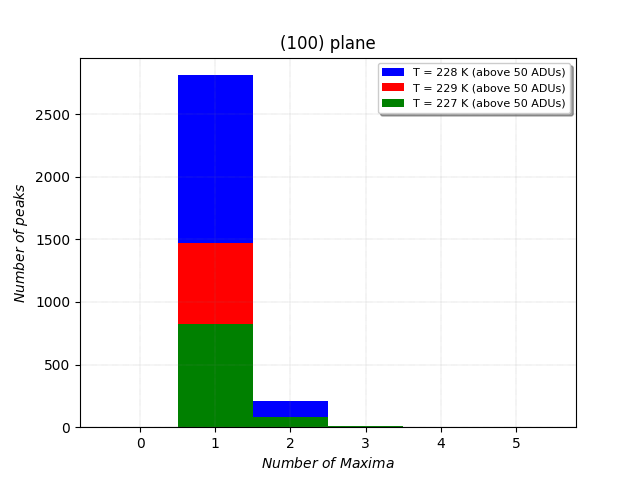

In [450]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 1
binedges = np.arange(0-binwidth/2,5+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(large_maxima_w, bins=binedges)
Sp_m, bin_edges = np.histogram(large_maxima_m, bins=binedges)
Sp_c, bin_edges = np.histogram(large_maxima_c, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K (above 50 ADUs)')
plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K (above 50 ADUs)')
plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K (above 50 ADUs)')
plt.title('(100) plane')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Number\ of\ Maxima$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

<IPython.core.display.Javascript object>


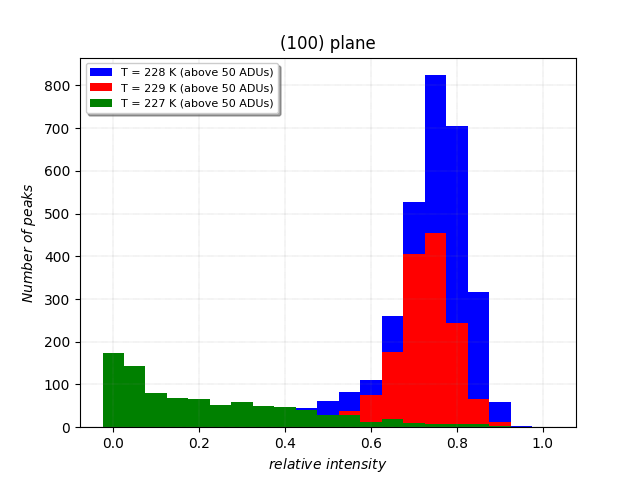

In [451]:
plt.figure()
binwidth = 0.05
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(large_intens_w, bins=binedges)
Sp_m, bin_edges = np.histogram(large_intens_m, bins=binedges)
Sp_c, bin_edges = np.histogram(large_inten_c, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K (above 50 ADUs)')
plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K (above 50 ADUs)')

plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K (above 50 ADUs)')
plt.title('(100) plane')
plt.legend(loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$relative\ intensity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [324]:
Sp_m, bin_centers

(array([ 0,  0,  2,  1,  4,  4,  9, 10,  7,  9, 20, 20, 24, 29, 31, 61, 44,
        36, 16,  2,  0]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]))

<IPython.core.display.Javascript object>


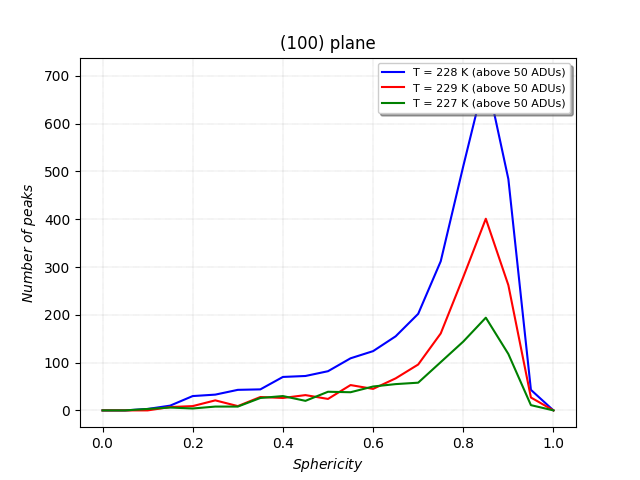

In [452]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.05
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(large_pix_w, bins=binedges)
Sp_m, bin_edges = np.histogram(large_pix_m, bins=binedges)
Sp_c, bin_edges = np.histogram(large_pix_c, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
plt.plot(bin_centers, Sp_m, 'b-', label = 'T = 228 K (above 50 ADUs)')
plt.plot(bin_centers, Sp_w, 'r-', label = 'T = 229 K (above 50 ADUs)')
plt.plot(bin_centers, Sp_c, 'g-', label = 'T = 227 K (above 50 ADUs)')
#plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K (above 50 ADUs)')
#plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K (above 50 ADUs)')
#plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K (above 50 ADUs)')
plt.title('(100) plane')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [168]:
# sphericity s = 0.73 to 0.76

rert = Shot_for_sp(T_w, above_50ADUs_w, choice = 'large_peaks', lower_bound=0.24, upper_bound=0.36)

In [172]:

range_2to3 = []
for i,n in enumerate(T_w):
    _,_, sh_list = dist_for_shot(n, above_50ADUs_w, lower_bound=2.8, upper_bound=3.)
    range_2to3.append(sh_list)

In [252]:
flat_list = [item for sublist in range_2to3 for item in sublist]
random.sample(flat_list, k=10)

['LCLS_2011_Feb28_r0151_182332_19341_cspad',
 'LCLS_2011_Feb28_r0147_180632_1f8b1_cspad',
 'LCLS_2011_Feb28_r0147_181419_8958_cspad',
 'LCLS_2011_Mar01_r0169_014658_1c392_cspad',
 'LCLS_2011_Feb28_r0145_164636_19f6e_cspad',
 'LCLS_2011_Feb28_r0147_181053_1682d_cspad',
 'LCLS_2011_Mar01_r0170_020301_10d76_cspad',
 'LCLS_2011_Feb28_r0151_183127_2e50_cspad',
 'LCLS_2011_Feb28_r0151_182059_bc25_cspad',
 'LCLS_2011_Feb28_r0146_173203_9afb_cspad']

In [173]:
import random
for run in rert.keys():
    suit = random.choice(list(rert[run]))
    print(suit)

LCLS_2011_Feb28_r0144_163900_11e86_cspad
LCLS_2011_Feb28_r0145_170956_1513e_cspad
LCLS_2011_Feb28_r0146_173200_973e_cspad
LCLS_2011_Feb28_r0147_175234_15ddd_cspad
LCLS_2011_Feb28_r0151_182723_d827_cspad
LCLS_2011_Mar01_r0169_013616_3cc3_cspad
LCLS_2011_Mar01_r0170_015914_1ce6c_cspad


In [588]:
#Shot_for_sp(T_w, above_50ADUs_w, choice = 'large_peaks', lower_bound=0.24, upper_bound=0.36)

In [171]:
peak_diff = specific_shots('r0170', 'LCLS_2011_Mar01_r0170_015917_1d2f2_cspad')['peaks'][6]

In [172]:
#peak_diff = Shot_for_sp(T_m, above_50ADUs_m)['r0167']['LCLS_2011_Mar01_r0167_002412_7b2d_cspad']['peak0'][0][0]
sphericity = []
p_sub = peak_diff - BG_level
p_mask = p_sub > photon_threshold
fill_holes = binary_fill_holes(p_mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
for i in peak_regions:
    contours,_= cv2.findContours(fill_holes[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    #for cnt in contours:
        #perimeter = cv2.arcLength(cnt, True)
        #area = cv2.contourArea(cnt)
        #if perimeter != 0:
            #sphericity.append(4*np.pi*area/(perimeter**2))

In [174]:
p_sub = peak_diff - BG_level
p_mask = p_sub > photon_threshold
fill_holes = binary_fill_holes(p_mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
#p = fill_holes[peak_regions[2]]

contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
'''
sphericity = []
for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if perimeter != 0:
            sphericity.append(4*np.pi*area/(perimeter**2))
'''
x_con = [contours[0][i][0][0] for i in range(len(contours[0]))]
y_con = [contours[0][i][0][1] for i in range(len(contours[0]))]
x_con1 = [contours[1][i][0][0] for i in range(len(contours[1]))]
y_con1 = [contours[1][i][0][1] for i in range(len(contours[1]))]
x_con2 = [contours[2][i][0][0] for i in range(len(contours[2]))]
y_con2 = [contours[2][i][0][1] for i in range(len(contours[2]))]
x_con3 = [contours[3][i][0][0] for i in range(len(contours[3]))]
y_con3 = [contours[3][i][0][1] for i in range(len(contours[3]))]

x_con2.append(int(contours[2][0][0][0]))
y_con2.append(int(contours[2][0][0][1]))
x_con.append(int(contours[0][0][0][0]))
y_con.append(int(contours[0][0][0][1]))
x_con1.append(int(contours[1][0][0][0]))
y_con1.append(int(contours[1][0][0][1]))
x_con3.append(int(contours[3][0][0][0]))
y_con3.append(int(contours[3][0][0][1]))

fig = plt.figure(figsize=[8,8])

ax = fig.gca()
#plt.plot(x_con, y_con, 'y-')
#plt.plot(x_con1, y_con1, 'y-')
#plt.plot(x_con2, y_con2, 'y-')
#plt.plot(x_con3, y_con3, 'y-')
#plt.text(contours[0][0][0][0]-1.5, contours[0][0][0][1]-1.5, sphericity[0], color = 'y', fontsize = 20)
#plt.text(contours[1][0][0][0]-1.5, contours[1][0][0][1]-1.5, sphericity[1], color = 'y', fontsize = 20)
#plt.text(contours[2][0][0][0]-1.5, contours[2][0][0][1]-1.5, sphericity[2], color = 'y', fontsize = 20)
#plt.text(contours[3][0][0][0]-1.5, contours[3][0][0][1]-1.5, sphericity[3], color = 'y', fontsize = 20)
#im = ax.imshow(fill_holes, cmap='jet', origin = 'lower', aspect='auto')
im = ax.imshow(peak_diff, cmap='jet', origin = 'lower', aspect='auto')
#ax.contour(p_mask, extend='both',linewidths=2)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
#plt.clim(vmin=0,vmax=400)
plt.show()
print(sphericity)

IndexError: list index out of range

<IPython.core.display.Javascript object>


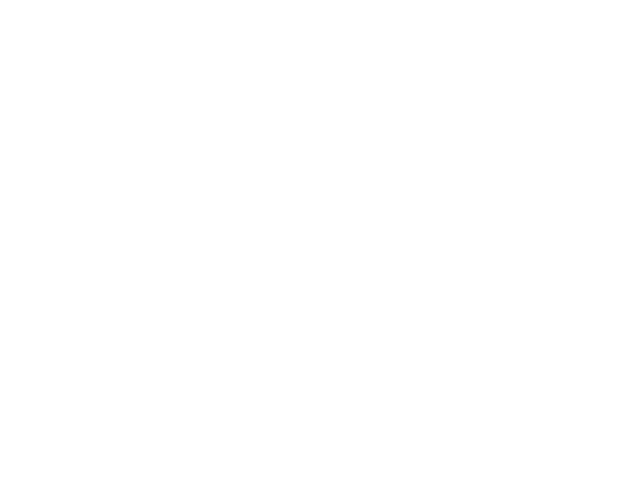

NameError: name 'large_pix_w' is not defined

In [175]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.05
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(large_pix_w, bins=binedges)
Sp_m, bin_edges = np.histogram(large_pix_m, bins=binedges)
Sp_c, bin_edges = np.histogram(large_pix_c, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K (above 50 ADUs)')
plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K (above 50 ADUs)')
plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K (above 50 ADUs)')

plt.legend(loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.title('larger or equal to 10 pixel size')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [193]:
t1 = Shot_for_sp(T_c, above_50ADUs_c, choice = 'small_peaks')
#small_pix_c = [list(d_values(t1, 4))[x]['sphericity'] for x in range(len(list(d_values(t1, 4))))]
small_pix_c = [list(d_values(x, 1))[0]['sphericity'] for x in list(d_values(t1, 3))]
small_q_c = [list(d_values(test, 3))[x]['q_cm'] for x in range(len(list(d_values(t1, 3))))]

In [150]:
t2 = Shot_for_sp(T_m, above_50ADUs_m, choice = 'small_peaks')
small_pix_m = [list(d_values(t2, 4))[x]['sphericity'] for x in range(len(list(d_values(t2, 4))))]

r0167, LCLS_2011_Mar01_r0167_002437_9d5f_cspad: 2 contours in one peak region 1 of peak 4:
r0167, LCLS_2011_Mar01_r0167_004356_fcd5_cspad: 2 contours in one peak region 0 of peak 7:
r0167, LCLS_2011_Mar01_r0167_001538_1a784_cspad: 2 contours in one peak region 0 of peak 1:
r0167, LCLS_2011_Mar01_r0167_001711_2aff_cspad: 2 contours in one peak region 1 of peak 0:
r0167, LCLS_2011_Mar01_r0167_002854_7aa_cspad: 3 contours in one peak region 1 of peak 0:
r0167, LCLS_2011_Mar01_r0167_004136_370b_cspad: 2 contours in one peak region 1 of peak 6:
r0167, LCLS_2011_Mar01_r0167_003641_97c8_cspad: 2 contours in one peak region 0 of peak 6:
r0167, LCLS_2011_Mar01_r0167_002655_16023_cspad: 2 contours in one peak region 0 of peak 0:
r0167, LCLS_2011_Mar01_r0167_003320_17d0c_cspad: 2 contours in one peak region 0 of peak 5:
r0167, LCLS_2011_Mar01_r0167_003045_a380_cspad: 2 contours in one peak region 0 of peak 3:
r0167, LCLS_2011_Mar01_r0167_003045_a380_cspad: 2 contours in one peak region 0 of peak 

r0171, LCLS_2011_Mar01_r0171_022818_1640d_cspad: 2 contours in one peak region 0 of peak 1:
r0171, LCLS_2011_Mar01_r0171_022818_1640d_cspad: 3 contours in one peak region 1 of peak 2:
r0171, LCLS_2011_Mar01_r0171_022818_1640d_cspad: 3 contours in one peak region 0 of peak 5:
r0171, LCLS_2011_Mar01_r0171_022818_1640d_cspad: 2 contours in one peak region 1 of peak 5:
r0171, LCLS_2011_Mar01_r0171_023604_1f326_cspad: 2 contours in one peak region 0 of peak 2:
r0171, LCLS_2011_Mar01_r0171_023842_d1c4_cspad: 3 contours in one peak region 1 of peak 3:
r0171, LCLS_2011_Mar01_r0171_023700_429f_cspad: 4 contours in one peak region 0 of peak 10:
r0171, LCLS_2011_Mar01_r0171_022935_1cfb0_cspad: 2 contours in one peak region 0 of peak 1:
r0171, LCLS_2011_Mar01_r0171_023532_1c5b1_cspad: 2 contours in one peak region 0 of peak 8:
r0171, LCLS_2011_Mar01_r0171_022925_1c1a9_cspad: 2 contours in one peak region 1 of peak 10:
r0171, LCLS_2011_Mar01_r0171_023249_e0fa_cspad: 2 contours in one peak region 2 

r0172, LCLS_2011_Mar01_r0172_024754_1d9a3_cspad: 2 contours in one peak region 2 of peak 1:
r0172, LCLS_2011_Mar01_r0172_025046_cb2e_cspad: 2 contours in one peak region 0 of peak 10:
r0172, LCLS_2011_Mar01_r0172_025434_c06_cspad: 2 contours in one peak region 0 of peak 1:
r0172, LCLS_2011_Mar01_r0172_025138_11412_cspad: 2 contours in one peak region 1 of peak 1:
r0172, LCLS_2011_Mar01_r0172_025138_11412_cspad: 2 contours in one peak region 0 of peak 5:
r0172, LCLS_2011_Mar01_r0172_030101_2c3a_cspad: 2 contours in one peak region 1 of peak 0:
r0172, LCLS_2011_Mar01_r0172_024311_4c08_cspad: 2 contours in one peak region 0 of peak 2:
r0172, LCLS_2011_Mar01_r0172_030359_126f3_cspad: 2 contours in one peak region 0 of peak 1:
r0172, LCLS_2011_Mar01_r0172_030557_1cd4f_cspad: 2 contours in one peak region 0 of peak 2:
r0172, LCLS_2011_Mar01_r0172_025649_ca7d_cspad: 2 contours in one peak region 0 of peak 0:
r0172, LCLS_2011_Mar01_r0172_025919_19cf5_cspad: 2 contours in one peak region 0 of p

r0173, LCLS_2011_Mar01_r0173_033114_2220_cspad: 2 contours in one peak region 1 of peak 4:
r0173, LCLS_2011_Mar01_r0173_031538_fe8b_cspad: 3 contours in one peak region 3 of peak 3:
r0173, LCLS_2011_Mar01_r0173_031538_fe8b_cspad: 2 contours in one peak region 5 of peak 3:
r0173, LCLS_2011_Mar01_r0173_033254_aede_cspad: 2 contours in one peak region 1 of peak 0:
r0173, LCLS_2011_Mar01_r0173_033157_5e41_cspad: 2 contours in one peak region 0 of peak 5:
r0173, LCLS_2011_Mar01_r0173_033157_5e41_cspad: 2 contours in one peak region 1 of peak 5:
r0173, LCLS_2011_Mar01_r0173_032837_144fc_cspad: 2 contours in one peak region 0 of peak 8:
r0173, LCLS_2011_Mar01_r0173_032837_144fc_cspad: 2 contours in one peak region 2 of peak 8:
r0173, LCLS_2011_Mar01_r0173_032127_e937_cspad: 2 contours in one peak region 1 of peak 1:
r0173, LCLS_2011_Mar01_r0173_031114_18b0d_cspad: 2 contours in one peak region 1 of peak 4:
r0173, LCLS_2011_Mar01_r0173_033427_13212_cspad: 2 contours in one peak region 1 of pea

In [151]:
t3 = Shot_for_sp(T_w, above_50ADUs_w, choice = 'small_peaks')
small_pix_w = [list(d_values(t3, 4))[x]['sphericity'] for x in range(len(list(d_values(t3, 4))))]

r0144, LCLS_2011_Feb28_r0144_163146_bba4_cspad: 2 contours in one peak region 0 of peak 4:
r0144, LCLS_2011_Feb28_r0144_162957_2322_cspad: 2 contours in one peak region 0 of peak 7:
r0144, LCLS_2011_Feb28_r0144_162957_2322_cspad: 2 contours in one peak region 0 of peak 9:
r0144, LCLS_2011_Feb28_r0144_163742_b196_cspad: 2 contours in one peak region 0 of peak 2:
r0144, LCLS_2011_Feb28_r0144_163742_b196_cspad: 2 contours in one peak region 1 of peak 2:
r0145, LCLS_2011_Feb28_r0145_165347_1fd34_cspad: 2 contours in one peak region 0 of peak 6:
r0145, LCLS_2011_Feb28_r0145_165347_1fd34_cspad: 2 contours in one peak region 1 of peak 7:
r0145, LCLS_2011_Feb28_r0145_164714_1d56b_cspad: 4 contours in one peak region 0 of peak 0:
r0145, LCLS_2011_Feb28_r0145_164619_18798_cspad: 2 contours in one peak region 1 of peak 0:
r0145, LCLS_2011_Feb28_r0145_170956_1513e_cspad: 2 contours in one peak region 1 of peak 2:
r0145, LCLS_2011_Feb28_r0145_170956_1513e_cspad: 2 contours in one peak region 0 of p

r0147, LCLS_2011_Feb28_r0147_175601_81fc_cspad: 2 contours in one peak region 1 of peak 0:
r0147, LCLS_2011_Feb28_r0147_175236_16077_cspad: 2 contours in one peak region 0 of peak 1:
r0147, LCLS_2011_Feb28_r0147_175236_16077_cspad: 4 contours in one peak region 1 of peak 1:
r0147, LCLS_2011_Feb28_r0147_173737_70d4_cspad: 2 contours in one peak region 0 of peak 0:
r0147, LCLS_2011_Feb28_r0147_174619_14efb_cspad: 4 contours in one peak region 2 of peak 4:
r0147, LCLS_2011_Feb28_r0147_174619_14efb_cspad: 2 contours in one peak region 1 of peak 5:
r0147, LCLS_2011_Feb28_r0147_173436_171e4_cspad: 2 contours in one peak region 0 of peak 14:
r0147, LCLS_2011_Feb28_r0147_181546_10458_cspad: 7 contours in one peak region 2 of peak 5:
r0147, LCLS_2011_Feb28_r0147_180826_9924_cspad: 2 contours in one peak region 0 of peak 8:
r0147, LCLS_2011_Feb28_r0147_180826_9924_cspad: 2 contours in one peak region 0 of peak 9:
r0147, LCLS_2011_Feb28_r0147_174424_ada9_cspad: 2 contours in one peak region 1 of 

r0169, LCLS_2011_Mar01_r0169_014402_cbca_cspad: 4 contours in one peak region 1 of peak 9:
r0169, LCLS_2011_Mar01_r0169_014340_ad31_cspad: 3 contours in one peak region 0 of peak 1:
r0169, LCLS_2011_Mar01_r0169_014739_1fcd1_cspad: 2 contours in one peak region 0 of peak 1:
r0169, LCLS_2011_Mar01_r0169_014739_1fcd1_cspad: 2 contours in one peak region 1 of peak 1:
r0169, LCLS_2011_Mar01_r0169_013656_748b_cspad: 2 contours in one peak region 1 of peak 2:
r0169, LCLS_2011_Mar01_r0169_013345_168b4_cspad: 2 contours in one peak region 1 of peak 3:
r0169, LCLS_2011_Mar01_r0169_013231_10041_cspad: 2 contours in one peak region 2 of peak 1:
r0169, LCLS_2011_Mar01_r0169_013215_e9f7_cspad: 2 contours in one peak region 1 of peak 3:
r0169, LCLS_2011_Mar01_r0169_014018_190cb_cspad: 2 contours in one peak region 1 of peak 0:
r0169, LCLS_2011_Mar01_r0169_014703_1ca91_cspad: 3 contours in one peak region 0 of peak 9:
r0169, LCLS_2011_Mar01_r0169_014703_1ca91_cspad: 2 contours in one peak region 2 of 

<IPython.core.display.Javascript object>


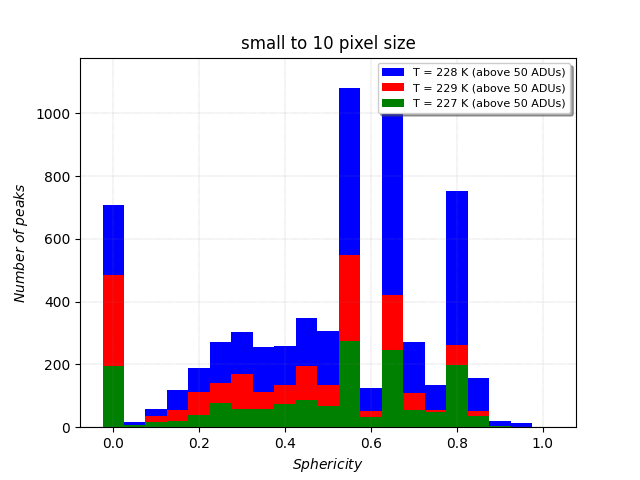

In [288]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.05
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(small_pix_w, bins=binedges)
Sp_m, bin_edges = np.histogram(small_pix_m, bins=binedges)
Sp_c, bin_edges = np.histogram(small_pix_c, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K (above 50 ADUs)')
plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K (above 50 ADUs)')
plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K (above 50 ADUs)')

plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.title('small than 10 pixel size')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [306]:
t1_below = Shot_for_sp(T_c, shots_below_c, choice = 'small_peaks')
small_below_c = [list(d_values(t1_below, 4))[x]['sphericity'] for x in range(len(list(d_values(t1_below, 4))))]

In [307]:
t2_below = Shot_for_sp(T_m, shots_below_m, choice = 'small_peaks')
small_below_m = [list(d_values(t2_below, 4))[x]['sphericity'] for x in range(len(list(d_values(t2_below, 4))))]

In [308]:
t3_below = Shot_for_sp(T_w, shots_below_w, choice = 'small_peaks')
small_below_w = [list(d_values(t3_below, 4))[x]['sphericity'] for x in range(len(list(d_values(t3_below, 4))))]

<IPython.core.display.Javascript object>


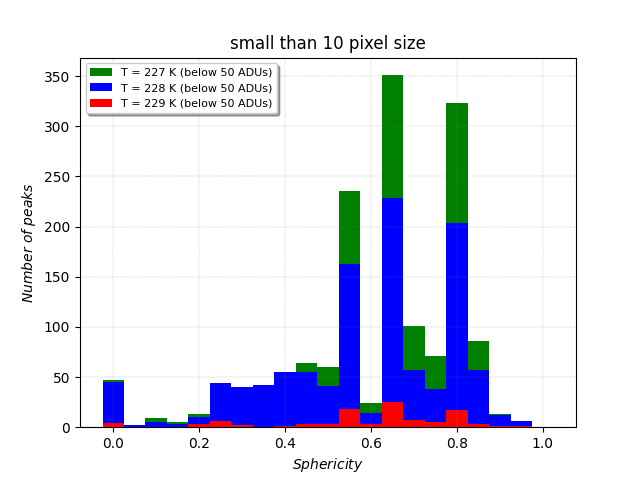

In [309]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.05
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(small_below_w, bins=binedges)
Sp_m, bin_edges = np.histogram(small_below_m, bins=binedges)
Sp_c, bin_edges = np.histogram(small_below_c, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K (below 50 ADUs)')
plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K (below 50 ADUs)')
plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K (below 50 ADUs)')

plt.legend(loc='best', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.title('small than 10 pixel size')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [310]:
t1_below_1 = Shot_for_sp(T_c, shots_below_c, choice = 'large_peaks')
large_below_c = [list(d_values(t1_below_1, 4))[x]['sphericity'] for x in range(len(list(d_values(t1_below_1, 4))))]

In [311]:
t2_below_1 = Shot_for_sp(T_m, shots_below_m, choice = 'large_peaks')
large_below_m = [list(d_values(t2_below_1, 4))[x]['sphericity'] for x in range(len(list(d_values(t2_below_1, 4))))]

In [312]:
t3_below_1 = Shot_for_sp(T_w, shots_below_w, choice = 'large_peaks')
large_below_w = [list(d_values(t3_below_1, 4))[x]['sphericity'] for x in range(len(list(d_values(t3_below_1, 4))))]

<IPython.core.display.Javascript object>


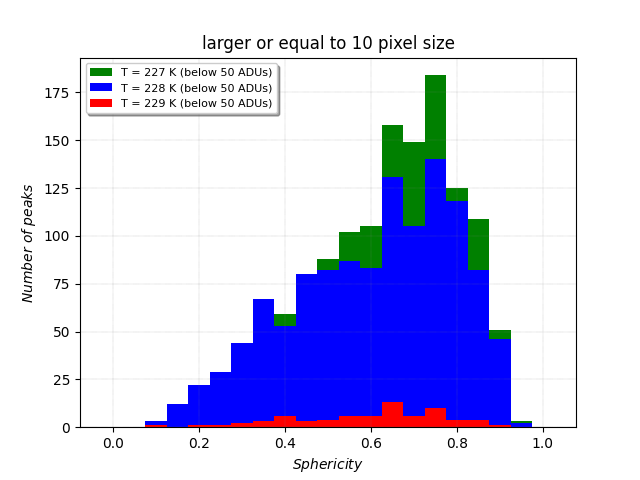

In [297]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.05
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(large_below_w, bins=binedges)
Sp_m, bin_edges = np.histogram(large_below_m, bins=binedges)
Sp_c, bin_edges = np.histogram(large_below_c, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K (below 50 ADUs)')
plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K (below 50 ADUs)')
plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K (below 50 ADUs)')

plt.legend(loc='best', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.title('larger or equal to 10 pixel size')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

<IPython.core.display.Javascript object>


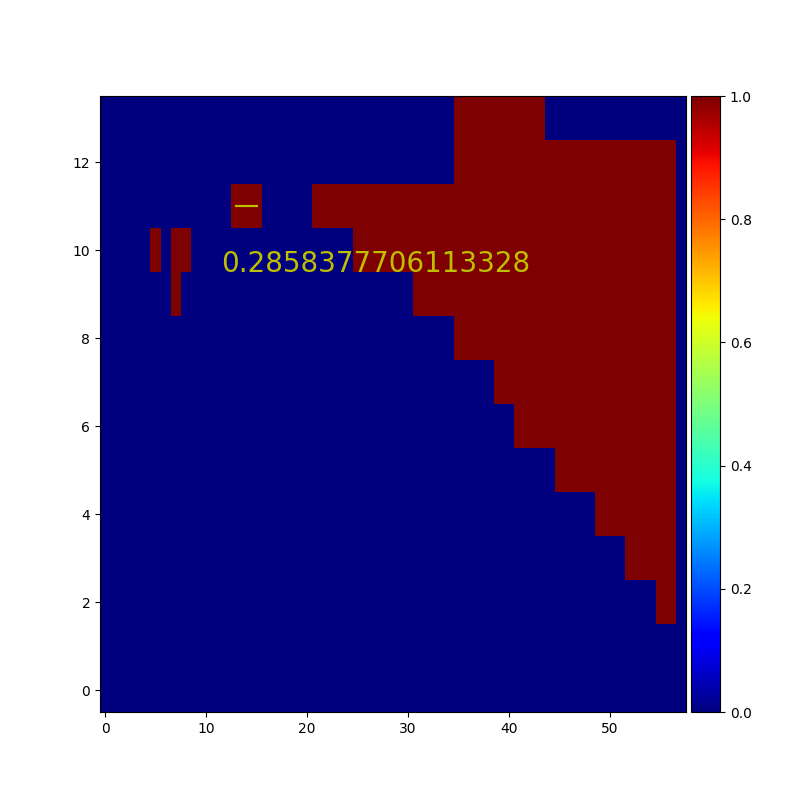

In [198]:
#peak_diff = np.array()
fig = plt.figure(figsize=[8,8])
ax = fig.gca()
plt.plot(x_con, y_con, 'y-')
#plt.plot(x_con1, y_con1, 'y-')
#plt.plot(x_con2, y_con2, 'y-')
#plt.plot(x_con3, y_con3, 'y-')
plt.text(contours[0][0][0][0]-1.5, contours[0][0][0][1]-1.5, sphericity[0], color = 'y', fontsize = 20)
#plt.text(contours[1][0][0][0]-1.5, contours[1][0][0][1]-1.5, sphericity[1], color = 'y', fontsize = 20)
#plt.text(contours[2][0][0][0]-1.5, contours[2][0][0][1]-1.5, sphericity[2], color = 'y', fontsize = 20)
#plt.text(contours[3][0][0][0]-1.5, contours[3][0][0][1]-1.5, sphericity[3], bbox=dict(color='y', linewidth=2, alpha=0.8))
im = ax.imshow(fill_holes,cmap='jet', origin = 'lower', aspect='auto')
#ax.contour(p_mask, extend='both',linewidths=2)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
#plt.clim(vmin=0,vmax=400)
plt.show()


In [202]:
textfile = open('lower_bound=0.78_upper_bound=0.82.txt', 'w')
for key, value in Shot_for_sp(T_m, above_50ADUs_m, lower_bound=0.78, upper_bound=0.82).items(): 
    textfile.write('%s:%s\n' % (key, value))
textfile.close()

In [149]:
def dist_one_shot(run, shot):
    '''
    calculate peak distances for a shot
    '''
    run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    run_no = h5py.File(run_path,'r')
    n_peaks = run_no['shots'][shot]['numberOfPeaks'][()]
    if n_peaks >= 1:
        qcm_x = run_no['shots'][shot]['peakCenterOfMassQx'][()]
        qcm_y = run_no['shots'][shot]['peakCenterOfMassQy'][()]
        centre = run_no['shots'][shot]['peakCenterOfMassInPixels'][:]
        q_cm = list(zip(qcm_x,qcm_y))
        distances = distance.cdist(q_cm,q_cm) 
        try:
            min_dist = [np.min(distances[np.nonzero(distances)])]
            min_distances = np.array(min_dist)
        except:
            pass
    return distances, min_distances, centre

In [218]:
selected_shot = dist_one_shot('r0168', 'LCLS_2011_Mar01_r0168_004818_6ca8_cspad')

# this dictionary determines which distance corresponds to which points
array_of_tuples = map(tuple, Center)
Center = list(array_of_tuples)
dict_ex = {}
for i,j in enumerate(Center):
    dict_ex[j] = {}
    for m,k in enumerate(Center):
        dict_ex[j][k] = {}
        dict_ex[j][k] = selected_shot[0][i][m]

<IPython.core.display.Javascript object>


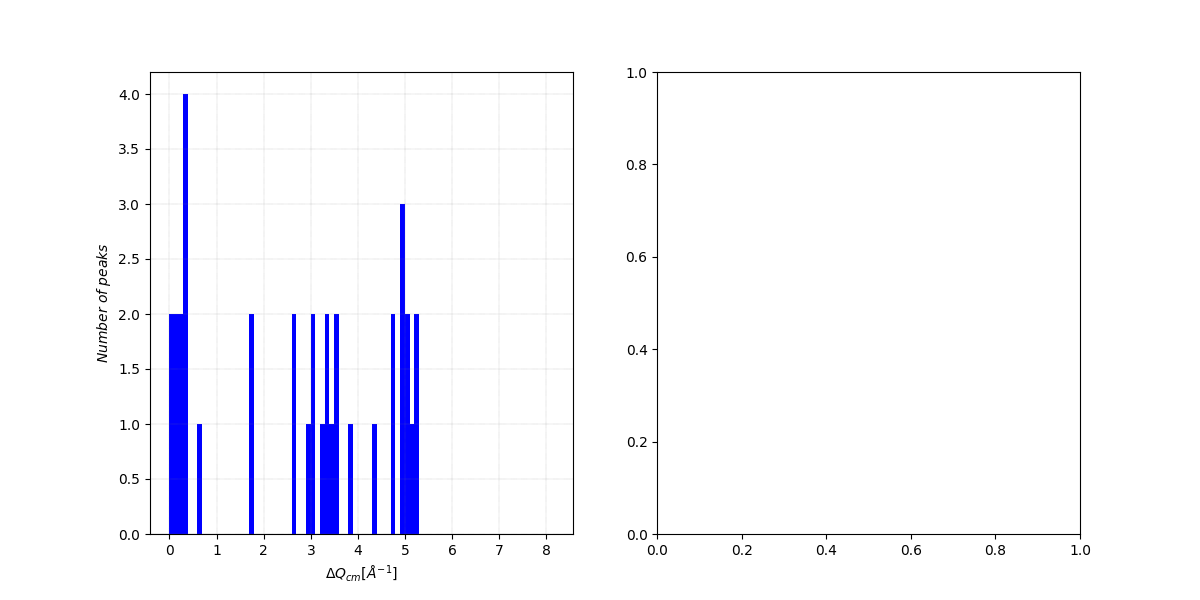

OSError: Unable to open file (unable to open file: name = '/Volumes/harddrive/LCLS/CXI/cxi25410/res/iceFinderCampaign/output_r0169/type1/LCLS_2011_Mar01_r0169_015125_13b27_cspad.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [219]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
binwidth = 0.01
binedges = np.arange(0-binwidth/2,8.1+binwidth/2,binwidth)
ds = dist_one_shot('r0169', 'LCLS_2011_Mar01_r0169_015125_13b27_cspad')[0]
yhist_w, bin_edges_w = np.histogram(ds[np.nonzero(ds)], bins=binedges)
yhist_w = yhist_w/2                              
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
new_bins, new_hist_w = downsample(bin_centers1, yhist_w, size=10)
ax1.bar(new_bins, new_hist_w, color='b', width=binwidth*10)
ax1.set_xlabel('$\Delta Q_{cm} [\AA^{-1}]$')
ax1.set_ylabel('$Number$ $of$ $peaks$')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

selected_shot = dist_one_shot('r0169', 'LCLS_2011_Mar01_r0169_015125_13b27_cspad')
peak_number =specific_shots('r0169', 'LCLS_2011_Mar01_r0169_015125_13b27_cspad')['No_of_peaks']
Center = specific_shots('r0169', 'LCLS_2011_Mar01_r0169_015125_13b27_cspad')['center_mass']
Radius = specific_shots('r0169', 'LCLS_2011_Mar01_r0169_015125_13b27_cspad')['radiusInPixels']
# this dictionary determines which distance corresponds to which points
array_of_tuples = map(tuple, Center)
Center_t = list(array_of_tuples)
dict_ex = {}
for i,j in enumerate(Center_t):
    dict_ex[j] = {}
    for m,k in enumerate(Center_t):
        dict_ex[j][k] = {}
        dict_ex[j][k] = selected_shot[0][i][m]


f = h5py.File('/Volumes/harddrive/LCLS/CXI/cxi25410/res/iceFinderCampaign/output_r0169/type1/LCLS_2011_Mar01_r0169_015125_13b27_cspad.h5', 'r')
d = f['data/data'][:]
fig = plt.gcf()
ax = fig.gca()

circle1 = plt.Circle(Center[2], Radius[2], color='r')
circle1.set_fill(False)
circle2 = plt.Circle(Center[5], radius=Radius[5], color='r')
circle2.set_fill(False)
ax2.add_patch(circle2)
ax2.text(Center[0][0]+10, Center[0][1]+10, round(dict_ex[Center_t[2]][Center_t[5]],2), color = 'y', fontsize = 14)

remove_2peaks = [Center_t[2], Center_t[5]]
Center = [ele for ele in Center_t if ele not in remove_2peaks]
Radius_remove = [Radius[2], Radius[5]]
Radius = [ele for ele in Radius if ele not in Radius_remove]


for peak in range(len(Radius)):
        circle3 = plt.Circle(Center[peak], radius=Radius[peak], color='w')
        circle3.set_fill(False)
        ax2.add_patch(circle3)
        #plt.text(Center[peak][0]+10, Center[peak][1]+10, round(dict_ex[tuple(Center[0])][tuple(Center[peak])],2), color = 'y', fontsize = 14)

im = ax2.imshow(d,cmap='jet', origin = 'lower', aspect='auto')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax2.add_patch(circle1)

fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()


In [220]:
for peak in range(len(Radius)):
    print(peak,Radius[peak])

0 7.5
1 10.0
2 38.5
3 6.0
4 14.0
5 8.0
6 11.5
7 11.0
8 8.5


In [221]:
dict_ex[tuple(Center[2])][tuple(Center[peak])]

5.120640312859816

In [222]:
dict_ex[(332.8326581280511,93.2640737198433)][(1146.0839475949313,519.9481520946666)]

2.9449692664092697

In [223]:
distances = []
min_distances = []
run ='r0144'
shot ='LCLS_2011_Feb28_r0144_163006_2feb_cspad'
run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
run_no = h5py.File(run_path,'r')
n_peaks = run_no['shots'][shot]['numberOfPeaks'][()]
dict_q = {}
centre = run_no['shots'][shot]['peakCenterOfMassInPixels'][:]
qcm_x = run_no['shots'][shot]['peakCenterOfMassQx'][()]
qcm_y = run_no['shots'][shot]['peakCenterOfMassQy'][()]
q_cm = list(zip(qcm_x,qcm_y))
dict_q = distance.cdist(q_cm,q_cm)
    #all_dist = [d[np.nonzero(d)]]
    #distances.append(np.array(all_dist).flatten())   
    #try:
    #    min_dist = [np.min(d[np.nonzero(d)])]
    #    min_distances.append(np.array(min_dist).flatten())
    #except:
    #    pass

In [224]:
qcm_x

array([ 0.41292026, -0.10618865, -1.50115661,  1.33498372,  1.38821247,
       -1.51179025, -1.45343903,  1.40340588,  1.44005384,  1.39626701,
       -0.00526704])

In [225]:
q_cm_total =[]
for i in range(len(qcm_x)):
    q_cm_t = np.sqrt(qcm_x[i]**2 + qcm_y[i]**2)
    q_cm_total.append(q_cm_t)
q_cm_t = q_cm_total.sort()

<IPython.core.display.Javascript object>


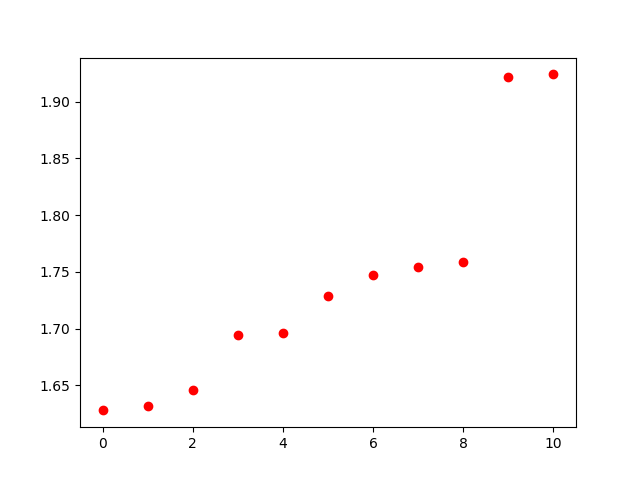

In [226]:
plt.figure()
plt.plot(q_cm_total, 'ro')

In [227]:
# this dictionary determines which distance corresponds to which points
dict_ex = {}
for i,j in enumerate(q_cm):
    dict_ex[j] = {}
    for m,k in enumerate(q_cm):
        dict_ex[j][k] = {}
        dict_ex[j][k] = dict_q[i][m]

<IPython.core.display.Javascript object>


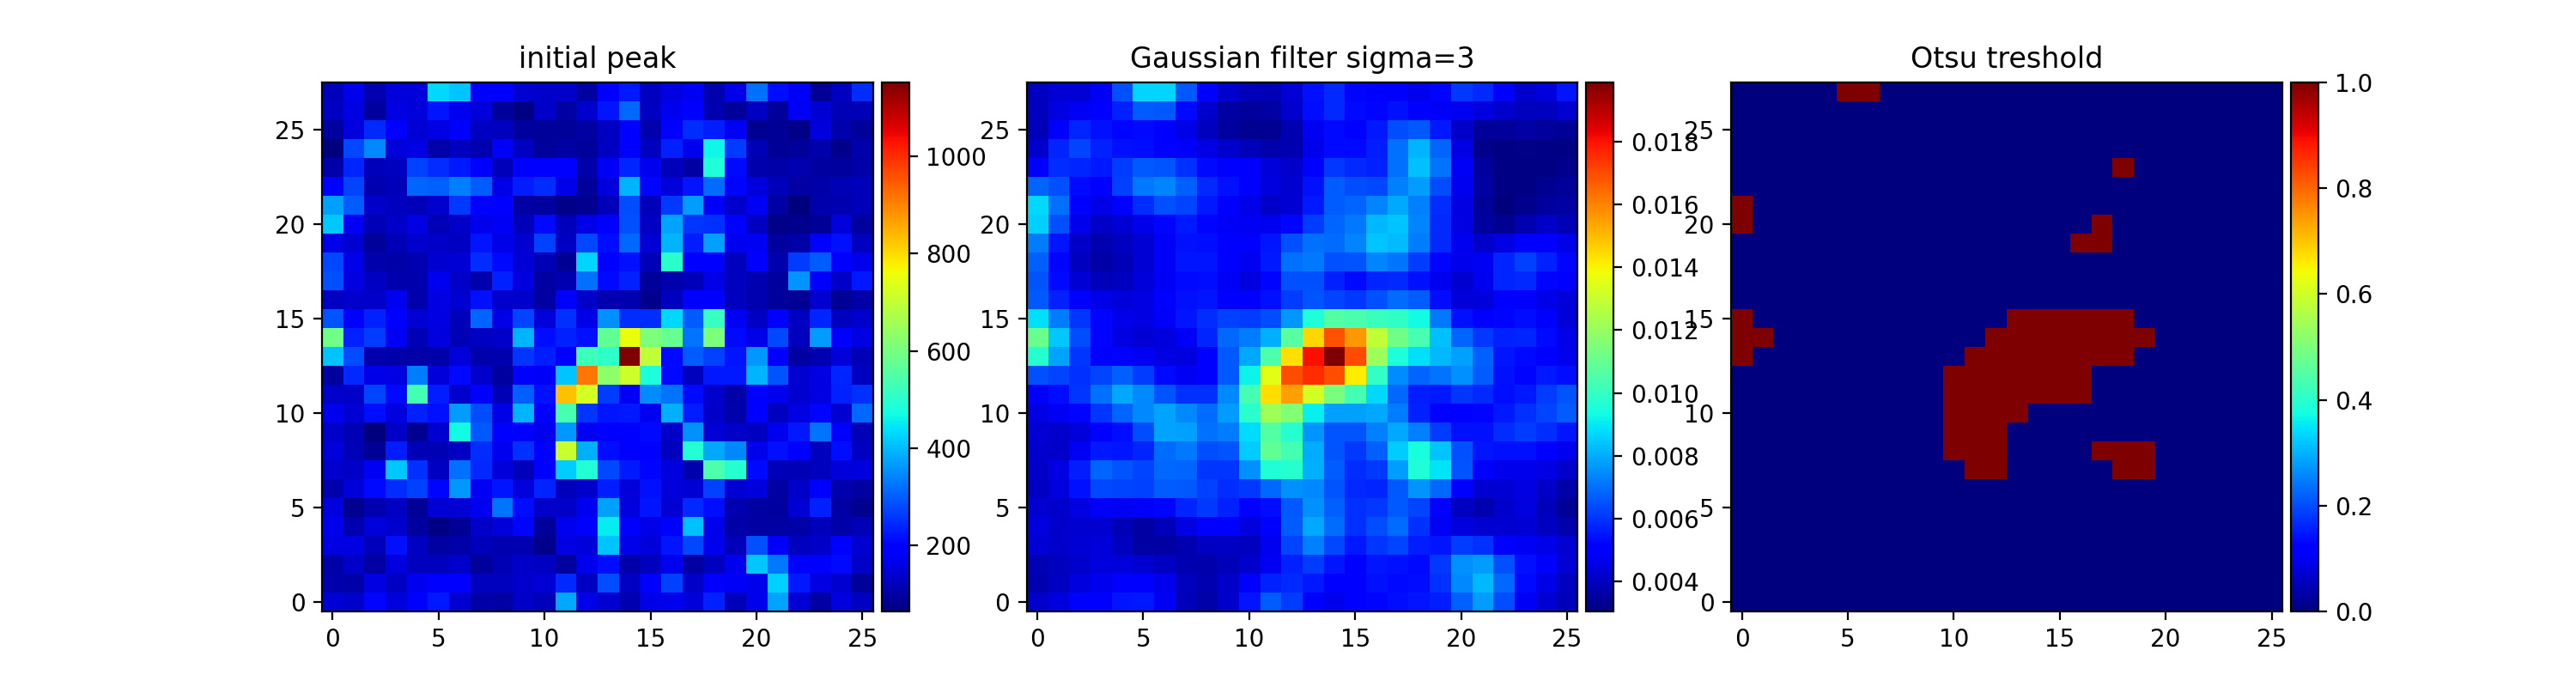

In [516]:
xc = specific_shots('r0173', 'LCLS_2011_Mar01_r0173_032111_d1af_cspad')['peaks'][2]

blur2 = skimage.filters.gaussian(xc, sigma=1)

# perform adaptive thresholding
t2 = skimage.filters.threshold_otsu(blur2)
mask2 = blur2 > t2
fill_holes2 = binary_fill_holes(mask2)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image2, number_of_peaks2 = scipy.ndimage.label(fill_holes2.astype(np.float32))
peak_regions2 = scipy.ndimage.find_objects(labeled_image2)
#p = fill_holes[peak_regions[4]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)  # right side

im1 = ax1.imshow(xc,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur2, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask2, cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax1.set_title('initial peak')
ax2.set_title('Gaussian filter sigma=3')
ax3.set_title('Otsu treshold')
#for contour in contours:
#    ax3.plot(contour[:, 1], contour[:, 0], linewidth=2)


#plt.clim(vmin=0,vmax=400)
plt.show()

In [514]:
from skimage import measure
contours = measure.find_contours(fill_holes2, level=0)

<IPython.core.display.Javascript object>


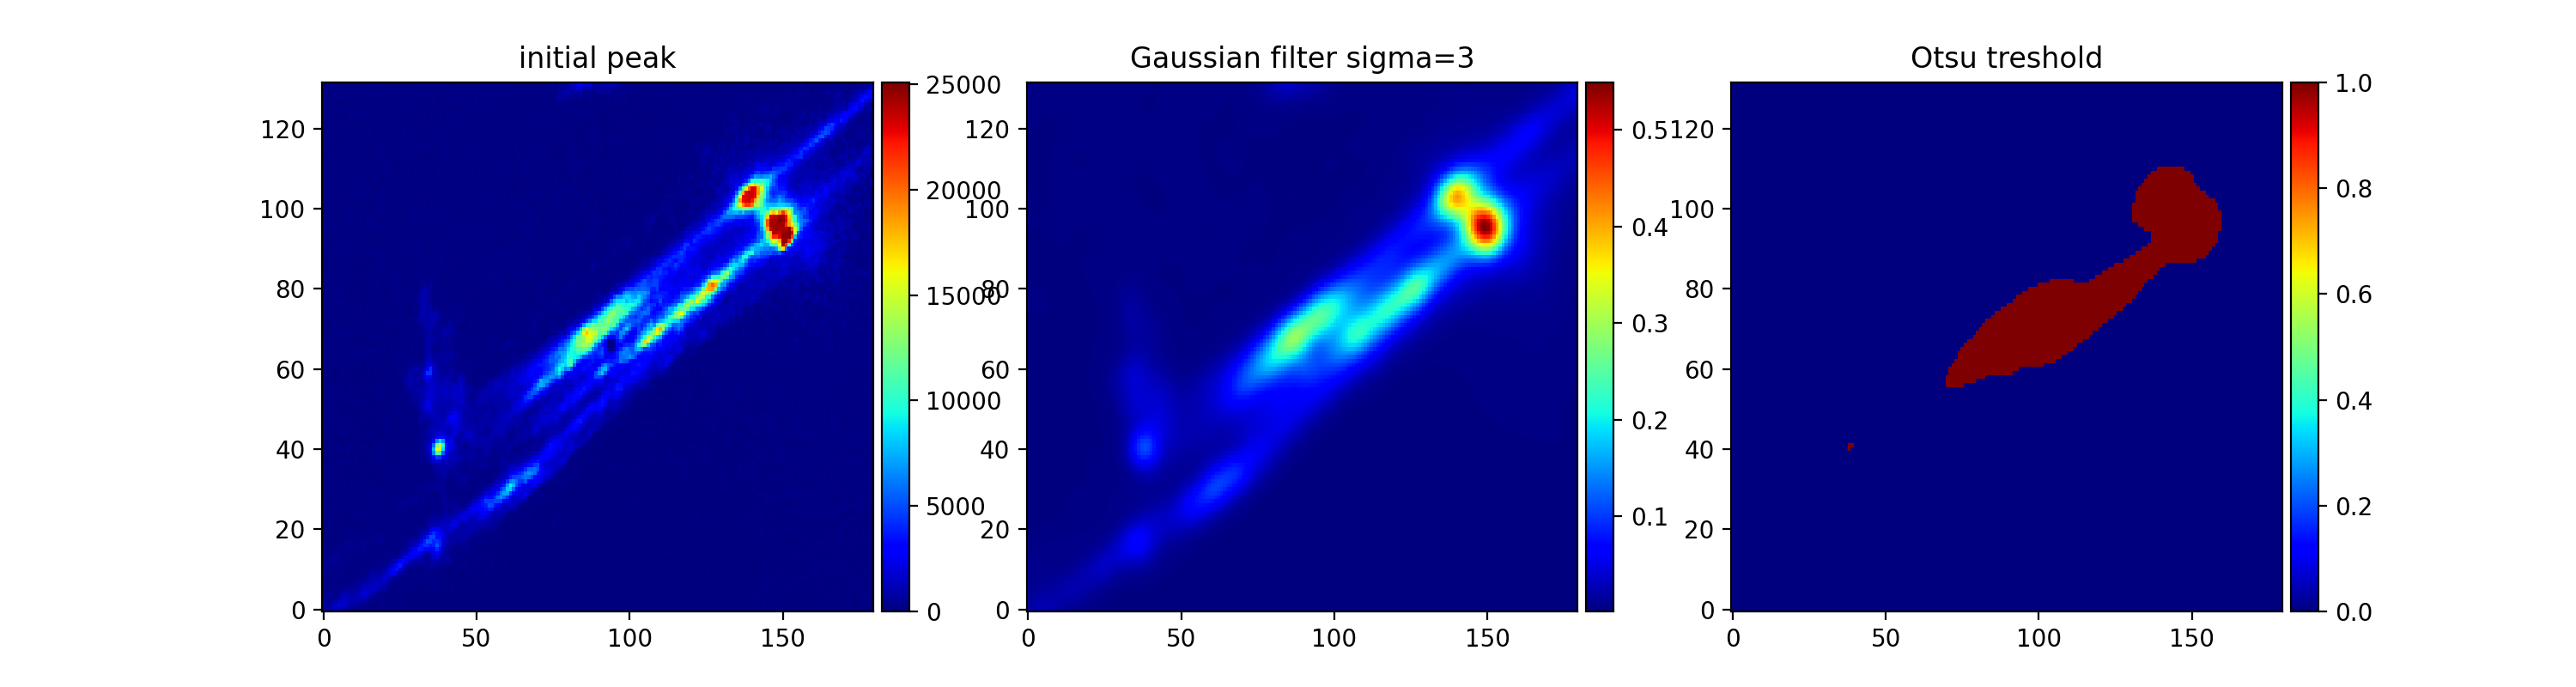

In [515]:
xc = specific_shots('r0173', 'LCLS_2011_Mar01_r0173_031538_fe8b_cspad')['peaks'][3]

blur2 = skimage.filters.gaussian(xc, sigma=3)

# perform adaptive thresholding
t2 = skimage.filters.threshold_otsu(blur2)

mask2 = blur2 > t2
fill_holes2 = binary_fill_holes(mask2)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image2, number_of_peaks2 = scipy.ndimage.label(fill_holes2.astype(np.float32))
peak_regions2 = scipy.ndimage.find_objects(labeled_image2)
#p = fill_holes[peak_regions[4]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)  # right side

im1 = ax1.imshow(xc,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur2, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask2, cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')

ax1.set_title('initial peak')
ax2.set_title('Gaussian filter sigma=3')
ax3.set_title('Otsu treshold')
#plt.clim(vmin=0,vmax=400)
plt.show()


<IPython.core.display.Javascript object>


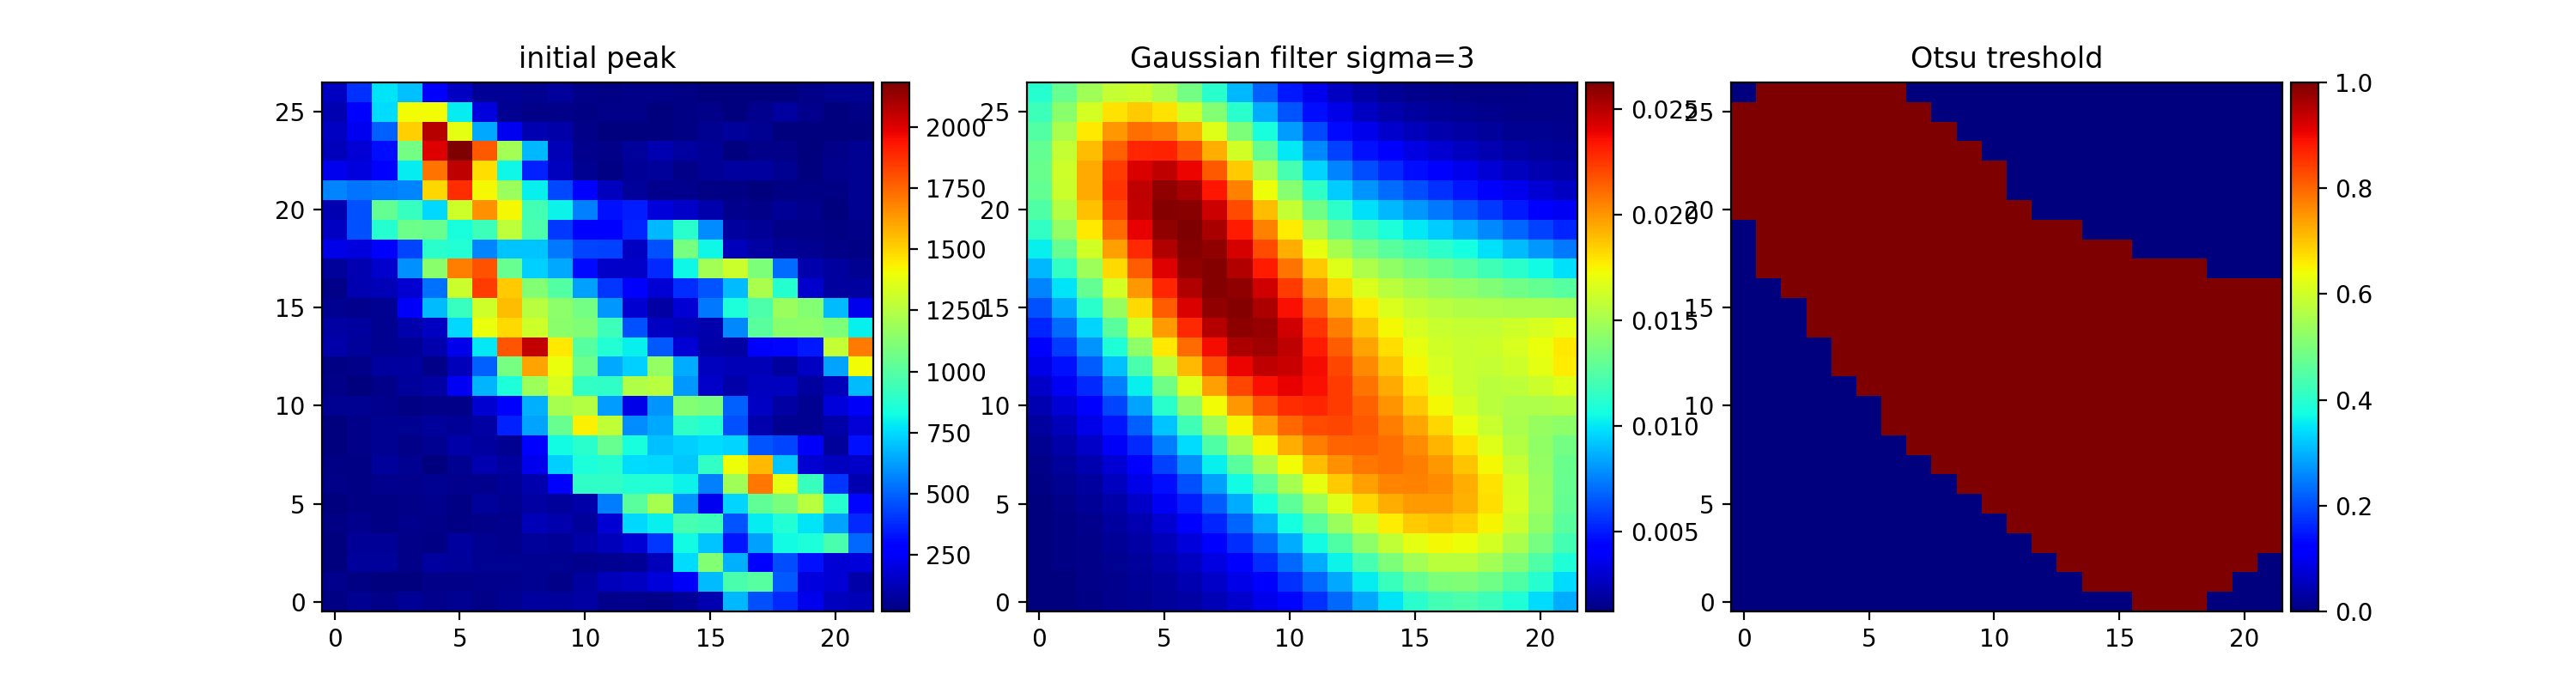

In [571]:
xc = specific_shots('r0173', 'LCLS_2011_Mar01_r0173_031540_1015b_cspad')['peaks'][6]
blur2 = skimage.filters.gaussian(xc, sigma=3)

# perform adaptive thresholding
t2 = skimage.filters.threshold_otsu(blur2)
mask2 = blur2 > t2
fill_holes2 = binary_fill_holes(mask2)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image2, number_of_peaks2 = scipy.ndimage.label(fill_holes2.astype(np.float32))
peak_regions2 = scipy.ndimage.find_objects(labeled_image2)
#p = fill_holes[peak_regions[4]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)  # right side

im1 = ax1.imshow(xc,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur2, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask2, cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')


ax1.set_title('initial peak')
ax2.set_title('Gaussian filter sigma=3')
ax3.set_title('Otsu treshold')
#plt.clim(vmin=0,vmax=400)
plt.show()


<IPython.core.display.Javascript object>


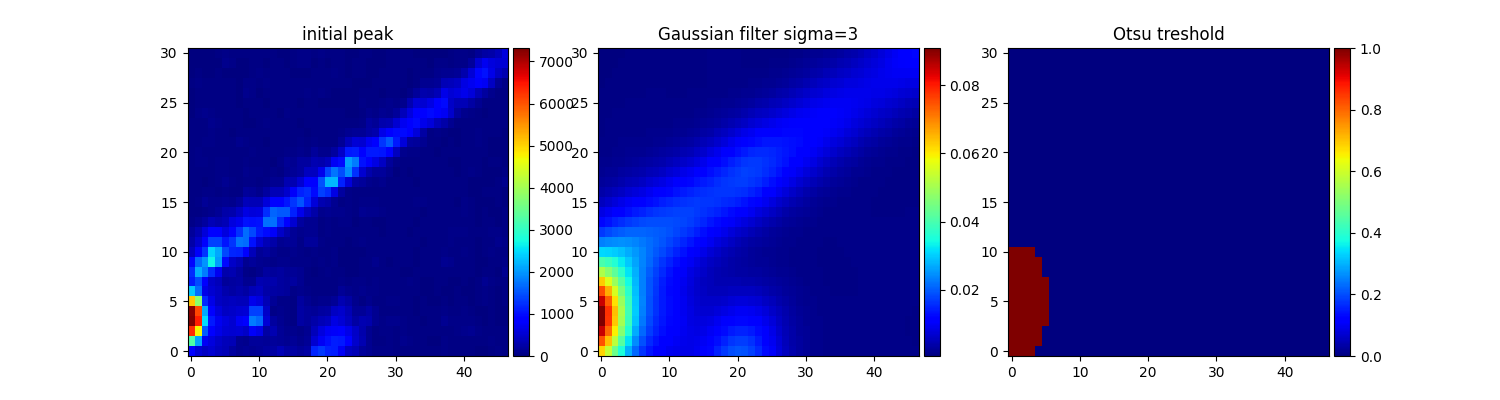

In [468]:
xc = specific_shots('r0173', 'LCLS_2011_Mar01_r0173_033219_7db2_cspad')['peaks'][10]

blur2 = skimage.filters.gaussian(xc, sigma=3)

# perform adaptive thresholding
t2 = skimage.filters.threshold_otsu(blur2)
mask2 = blur2 > t2
fill_holes2 = binary_fill_holes(mask2)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image2, number_of_peaks2 = scipy.ndimage.label(fill_holes2.astype(np.float32))
peak_regions2 = scipy.ndimage.find_objects(labeled_image2)
#p = fill_holes[peak_regions[4]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)  # right side

im1 = ax1.imshow(xc,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur2, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask2, cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax1.set_title('initial peak')
ax2.set_title('Gaussian filter sigma=3')
ax3.set_title('Otsu treshold')
#plt.clim(vmin=0,vmax=400)
plt.show()

In [231]:
np.shape(specific_shots('r0173', 'LCLS_2011_Mar01_r0173_032559_6696_cspad')['peaks'][5])

(74, 28)

<IPython.core.display.Javascript object>


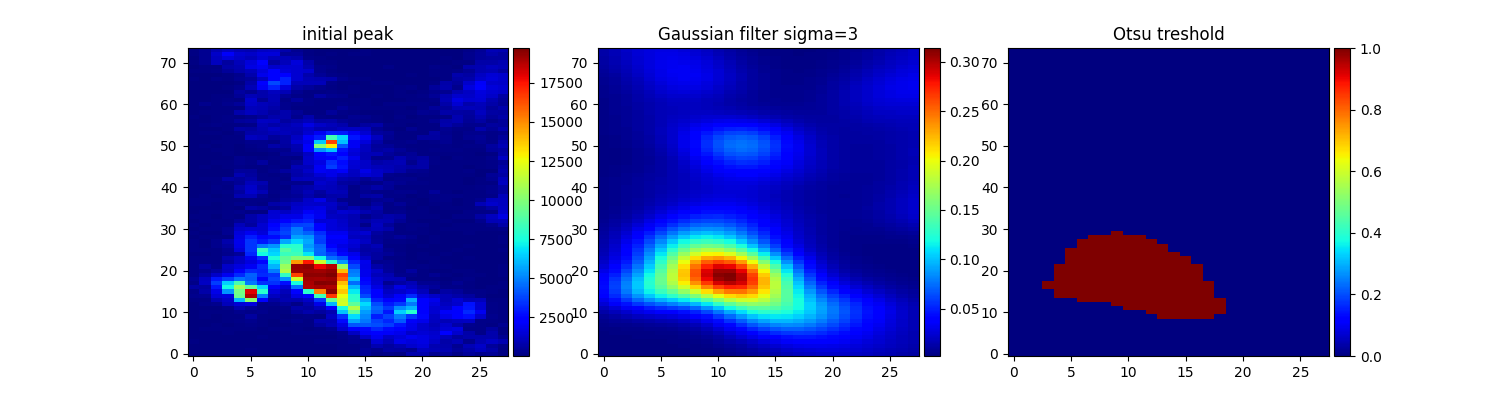

In [466]:
xc = specific_shots('r0173', 'LCLS_2011_Mar01_r0173_032559_6696_cspad')['peaks'][5]

blur2 = skimage.filters.gaussian(xc, sigma=3)

# perform adaptive thresholding
t2 = skimage.filters.threshold_otsu(blur2)
mask2 = blur2 > t2
fill_holes2 = binary_fill_holes(mask2)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image2, number_of_peaks2 = scipy.ndimage.label(fill_holes2.astype(np.float32))
peak_regions2 = scipy.ndimage.find_objects(labeled_image2)
#p = fill_holes[peak_regions[4]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)  # right side

im1 = ax1.imshow(xc,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur2, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask2, cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax1.set_title('initial peak')
ax2.set_title('Gaussian filter sigma=3')
ax3.set_title('Otsu treshold')
#plt.clim(vmin=0,vmax=400)
plt.show()

<IPython.core.display.Javascript object>


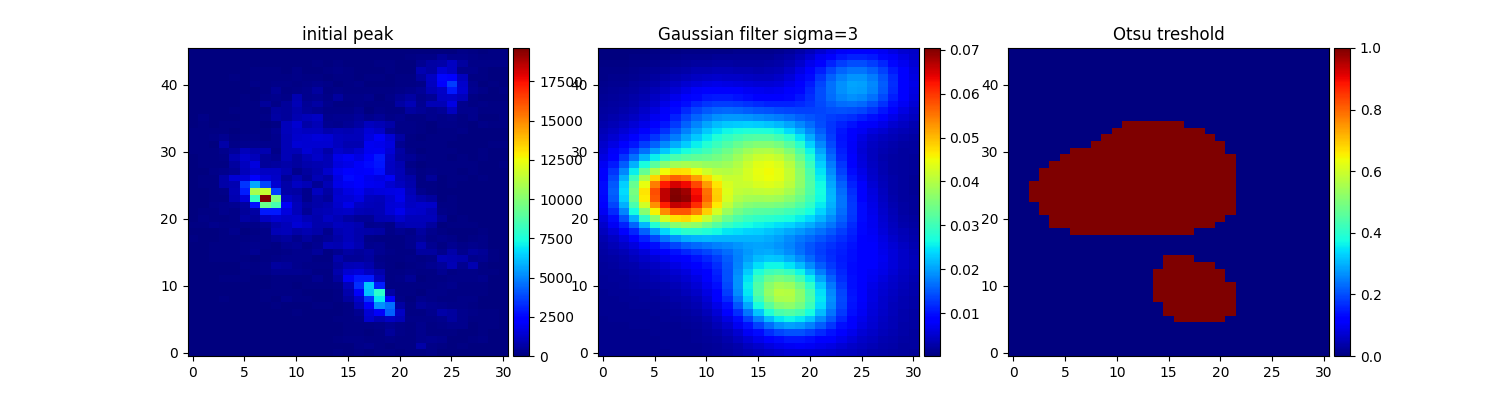

In [465]:
xc = specific_shots('r0173', 'LCLS_2011_Mar01_r0173_031018_13c3b_cspad')['peaks'][1]

blur2 = skimage.filters.gaussian(xc, sigma=3)

# perform adaptive thresholding
t2 = skimage.filters.threshold_otsu(blur2)
mask2 = blur2 > t2
fill_holes2 = binary_fill_holes(mask2)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image2, number_of_peaks2 = scipy.ndimage.label(fill_holes2.astype(np.float32))
peak_regions2 = scipy.ndimage.find_objects(labeled_image2)
#p = fill_holes[peak_regions[4]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)  # right side

im1 = ax1.imshow(xc,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur2, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask2, cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax1.set_title('initial peak')
ax2.set_title('Gaussian filter sigma=3')
ax3.set_title('Otsu treshold')
#plt.clim(vmin=0,vmax=400)
plt.show()

<IPython.core.display.Javascript object>


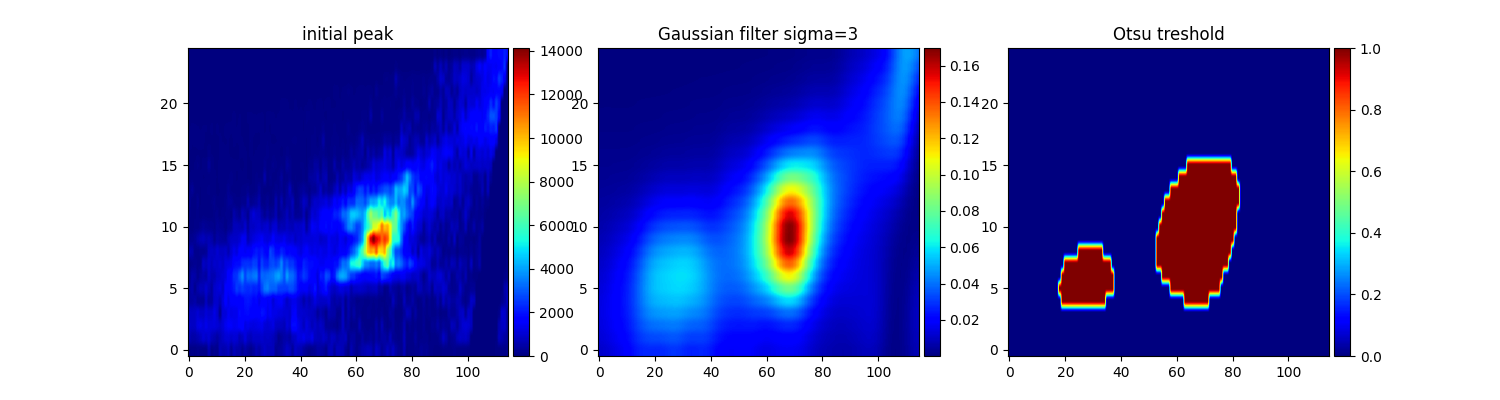

In [251]:
xc = specific_shots('r0173', 'LCLS_2011_Mar01_r0173_032107_ccfc_cspad')['peaks'][5]

blur2 = skimage.filters.gaussian(xc, sigma=3)

# perform adaptive thresholding
t2 = skimage.filters.threshold_otsu(blur2)
mask2 = blur2 > t2
fill_holes2 = binary_fill_holes(mask2)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image2, number_of_peaks2 = scipy.ndimage.label(fill_holes2.astype(np.float32))
peak_regions2 = scipy.ndimage.find_objects(labeled_image2)

# Initialize empty list
lst_intensities = []
contours,_= cv2.findContours(fill_holes2.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#cimg = np.zeros_like(xc)
#cv2.drawContours(cimg, contours, 0, color=255, thickness=-1)
#pts = np.where(cimg == 255)
# For each list of contour points...
#for i,j in enumerate(peak_regions2):
#    contours,_= cv2.findContours(fill_holes2[j].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
for x in range(len(contours)):
        # Create a mask image that contains the contour filled in
        cimg = np.zeros_like(xc)
        cv2.drawContours(cimg, contours, x, color=255, thickness=-1)
        # Access the image pixels and create a 1D numpy array then add to list
        pts = np.where(cimg == 255)
        lst_intensities.append(xc[pts].sum())
rel_intens = np.array([lst_intensities[i]/xc.sum() for i in range(len(lst_intensities))])
desired_peak_inx = np.argmax(lst_intensities)
perimeter = cv2.arcLength(contours[desired_peak_inx], True)
area = cv2.contourArea(contours[desired_peak_inx])
if perimeter != 0:
    sphericity =4*np.pi*area/(perimeter**2)
else:
    sphericity = None

fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)  # right side

im1 = ax1.imshow(xc,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur2, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask2, cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax1.set_title('initial peak')
ax2.set_title('Gaussian filter sigma=3')
ax3.set_title('Otsu treshold')
#plt.clim(vmin=0,vmax=400)
plt.show()


In [250]:
np.argmax(lst_intensities)

0

In [243]:
rel_intens

array([0.39546231, 0.08571531])

In [225]:
np.shape(pts), xc[pts].sum(),xc.sum()

((2, 81), 206524, 2409418)

In [228]:
lst_intensities[1]/xc.sum()

0.08571530552191442

In [619]:
sum(lst_intensities[0])/sum(map(sum, xc)), sum(lst_intensities[1])/sum(map(sum, xc))

(0.39546230666492904, 0.08571530552191442)

In [617]:
sum(lst_intensities[0])/sum(map(sum, xc)), sum(lst_intensities[1])/sum(map(sum, xc))

(0.030733978081013757, 0.1357265530514008)

<IPython.core.display.Javascript object>


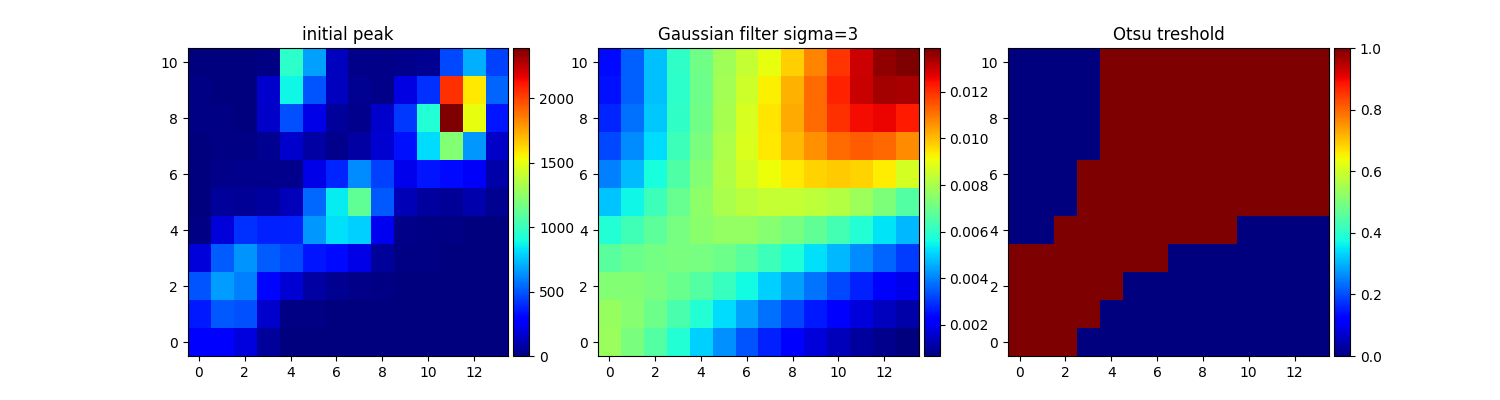

0


In [464]:
xc = specific_shots('r0173', 'LCLS_2011_Mar01_r0173_033709_15d2_cspad')['peaks'][0]

blur2 = skimage.filters.gaussian(xc, sigma=3)

# perform adaptive thresholding
t2 = skimage.filters.threshold_otsu(blur2)
mask2 = blur2 > t2
fill_holes2 = binary_fill_holes(mask2)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image2, number_of_peaks2 = scipy.ndimage.label(fill_holes2.astype(np.float32))
peak_regions2 = scipy.ndimage.find_objects(labeled_image2)
#p = fill_holes[peak_regions[4]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)  # right side

for p,i in enumerate(peak_regions2):
    print(p)
    #img_peak = np.zeros_like(zx)
    #img_peak[i] = zx[i]
    #cy_L,cx_L = centroid_com(img_peak)
    #cy_t,cx_t = centroid_com(zx)
    #diff_center = (cm[0] - cy_t, cm[1] - cx_t)
    #new_center = np.array([(cy_L,cx_L)])+diff_center
    #shifted.append(new_center)
    #plt.plot(cy_L, cx_L, 'ko') 
    #r,theta = convert_coordinates(new_center[0][0], new_center[0][1], center_of_detector_pixels)
    #q_cm = pos2q(r,wavelength,detector_distance,pixel_size)
    #qy, qx = pol2cart(q_cm, theta)

im1 = ax1.imshow(xc,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur2, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask2, cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax1.set_title('initial peak')
ax2.set_title('Gaussian filter sigma=3')
ax3.set_title('Otsu treshold')
#plt.clim(vmin=0,vmax=400)
plt.show()

<IPython.core.display.Javascript object>


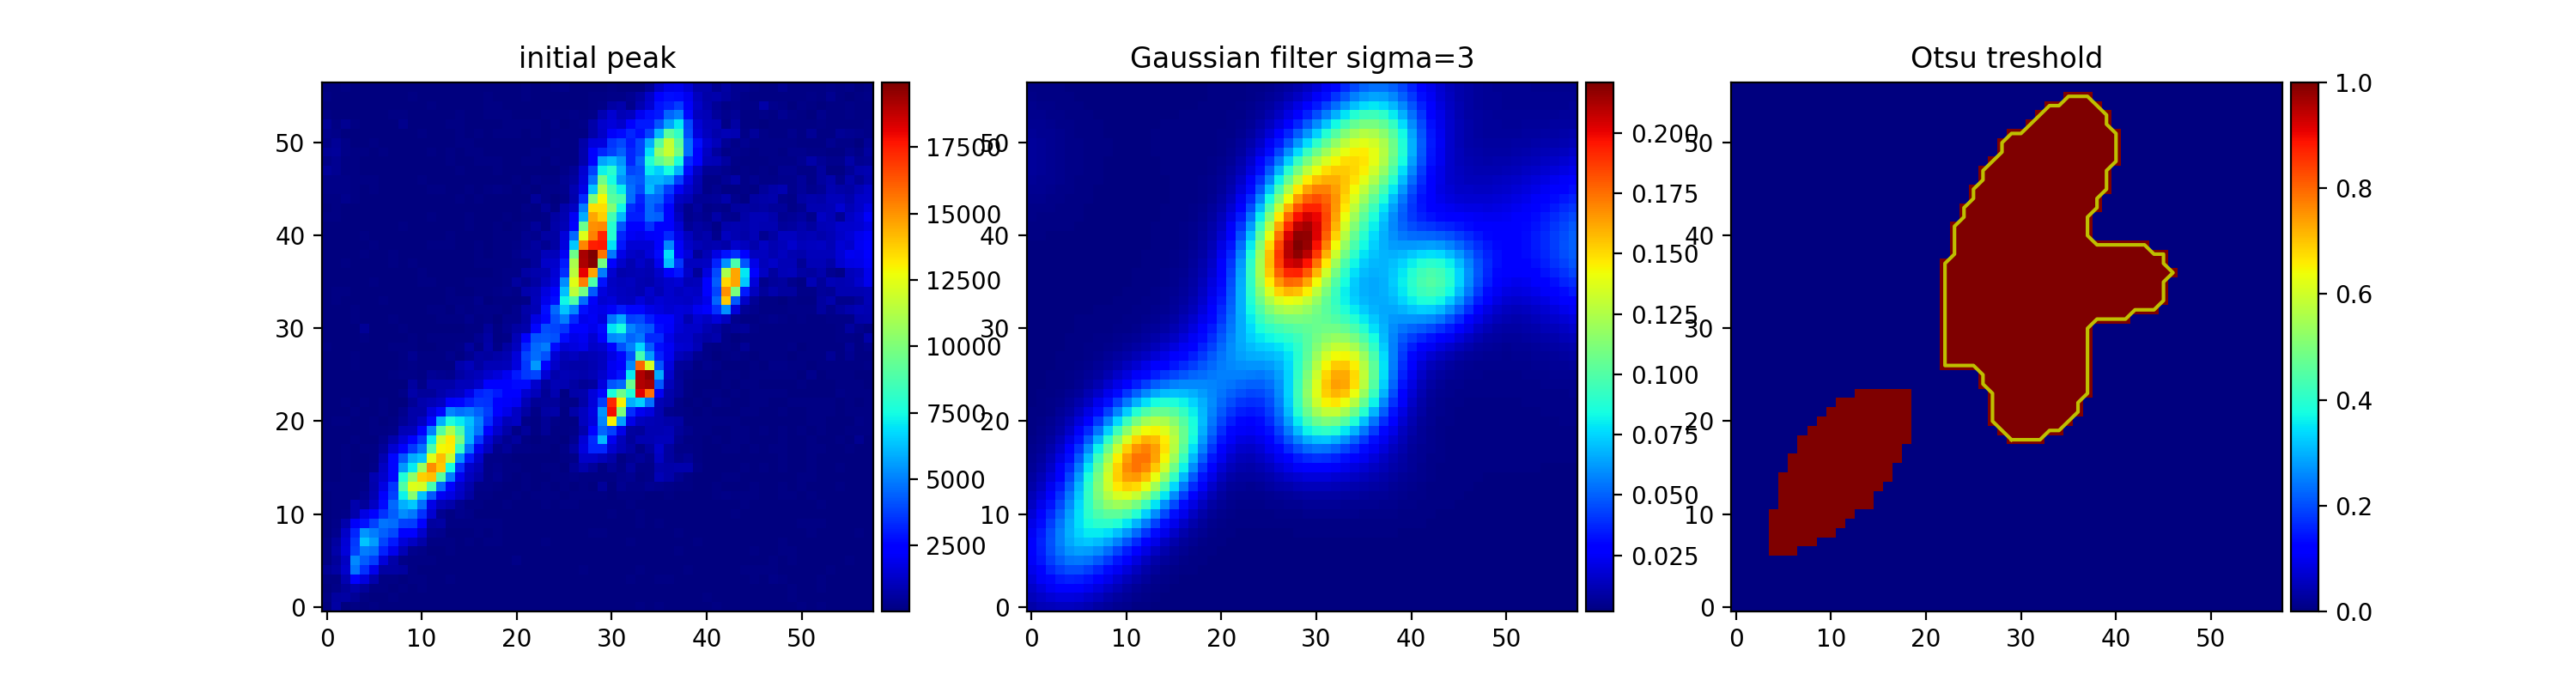

(1, 2)

In [604]:
xc = specific_shots('r0168', 'LCLS_2011_Mar01_r0168_010725_b985_cspad')['peaks'][5]

blur2 = skimage.filters.gaussian(xc, sigma=3)

# perform adaptive thresholding
t2 = skimage.filters.threshold_otsu(blur2)
mask2 = blur2 > t2
fill_holes2 = binary_fill_holes(mask2)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image2, number_of_peaks2 = scipy.ndimage.label(fill_holes2.astype(np.float32))
peak_regions2 = scipy.ndimage.find_objects(labeled_image2)

x_con = [contours[0][i][0][0] for i in range(len(contours[0]))]
y_con = [contours[0][i][0][1] for i in range(len(contours[0]))]
x_con.append(int(contours[0][0][0][0]))
y_con.append(int(contours[0][0][0][1]))

fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)  # right side

im1 = ax1.imshow(xc,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur2, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask2, cmap='jet', origin = 'lower', aspect='auto')
ax3.plot(x_con,y_con, 'y-')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax1.set_title('initial peak')
ax2.set_title('Gaussian filter sigma=3')
ax3.set_title('Otsu treshold')
#plt.clim(vmin=0,vmax=400)
plt.show()
len(contour), len(peak_regions2)

In [581]:
sum(lst_intensities[0])/sum(map(sum, xc)), sum(lst_intensities[1])/sum(map(sum, xc))

IndexError: list index out of range

<IPython.core.display.Javascript object>


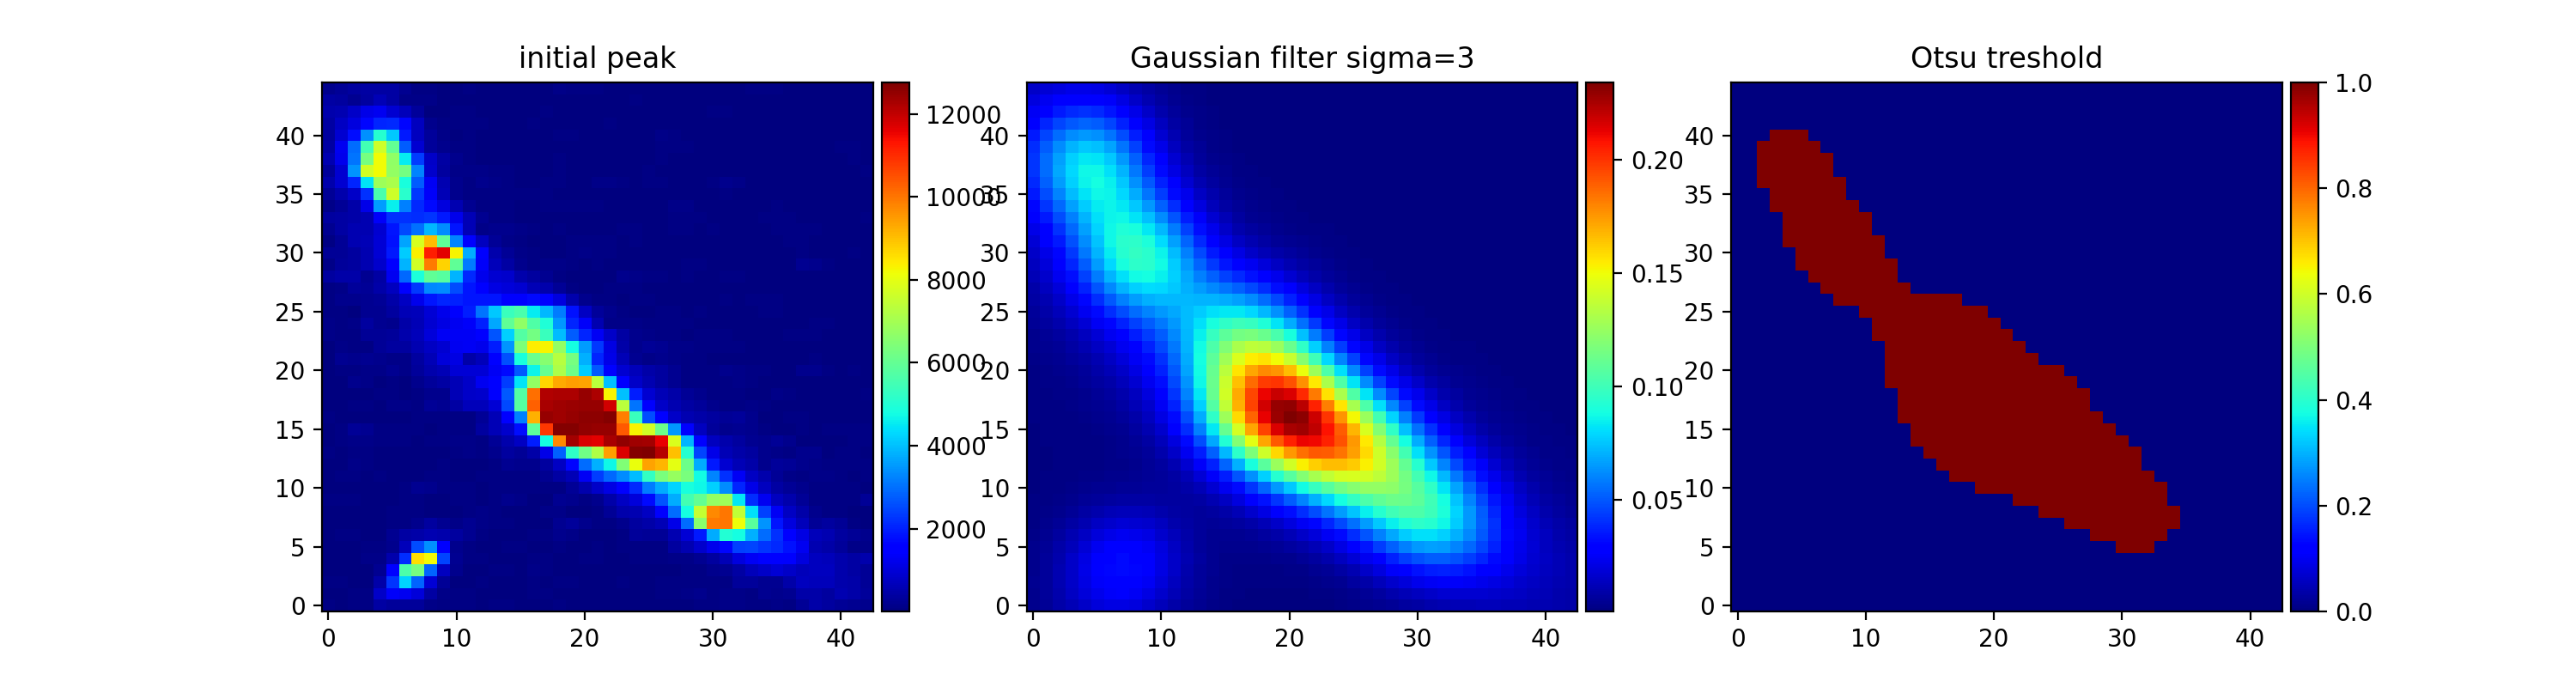

In [576]:
xc = specific_shots('r0167', 'LCLS_2011_Mar01_r0167_004242_94d7_cspad')['peaks'][6]

blur2 = skimage.filters.gaussian(xc, sigma=3)

# perform adaptive thresholding
t2 = skimage.filters.threshold_otsu(blur2)
mask2 = blur2 > t2
fill_holes2 = binary_fill_holes(mask2)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image2, number_of_peaks2 = scipy.ndimage.label(fill_holes2.astype(np.float32))
peak_regions2 = scipy.ndimage.find_objects(labeled_image2)
#p = fill_holes[peak_regions[4]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)  # right side

contours,_= cv2.findContours(fill_holes2.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Initialize empty list
lst_intensities = []

# For each list of contour points...
for i in range(len(contours)):
    # Create a mask image that contains the contour filled in
    cimg = np.zeros_like(xc)
    cv2.drawContours(cimg, contours, i, color=255, thickness=-1)

    # Access the image pixels and create a 1D numpy array then add to list
    pts = np.where(cimg == 255)
    lst_intensities.append(xc[pts[0], pts[1]])


im1 = ax1.imshow(xc,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur2, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask2, cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax1.set_title('initial peak')
ax2.set_title('Gaussian filter sigma=3')
ax3.set_title('Otsu treshold')
#plt.clim(vmin=0,vmax=400)
plt.show()

In [578]:
sum(lst_intensities[0])/sum(map(sum, xc))

0.8338511836790095

<IPython.core.display.Javascript object>


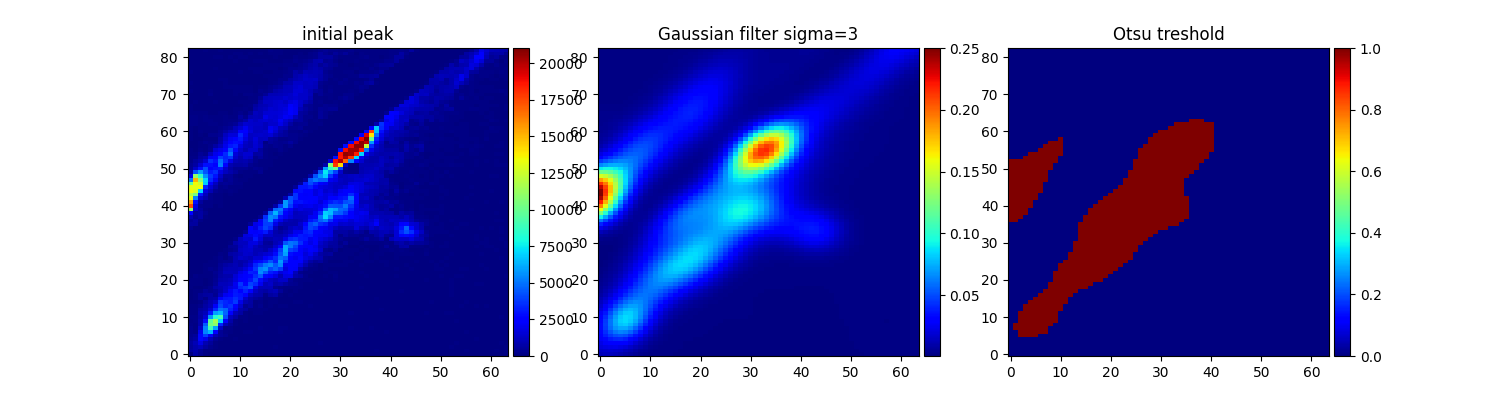

In [490]:
xc = specific_shots('r0172', 'LCLS_2011_Mar01_r0172_030102_2d93_cspad')['peaks'][6]

blur2 = skimage.filters.gaussian(xc, sigma=3)

# perform adaptive thresholding
t2 = skimage.filters.threshold_otsu(blur2)
mask2 = blur2 > t2
fill_holes2 = binary_fill_holes(mask2)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image2, number_of_peaks2 = scipy.ndimage.label(fill_holes2.astype(np.float32))
peak_regions2 = scipy.ndimage.find_objects(labeled_image2)
#p = fill_holes[peak_regions[4]]
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)  # right side

im1 = ax1.imshow(xc,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(blur2, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(mask2, cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax1.set_title('initial peak')
ax2.set_title('Gaussian filter sigma=3')
ax3.set_title('Otsu treshold')
#plt.clim(vmin=0,vmax=400)
plt.show()

<IPython.core.display.Javascript object>


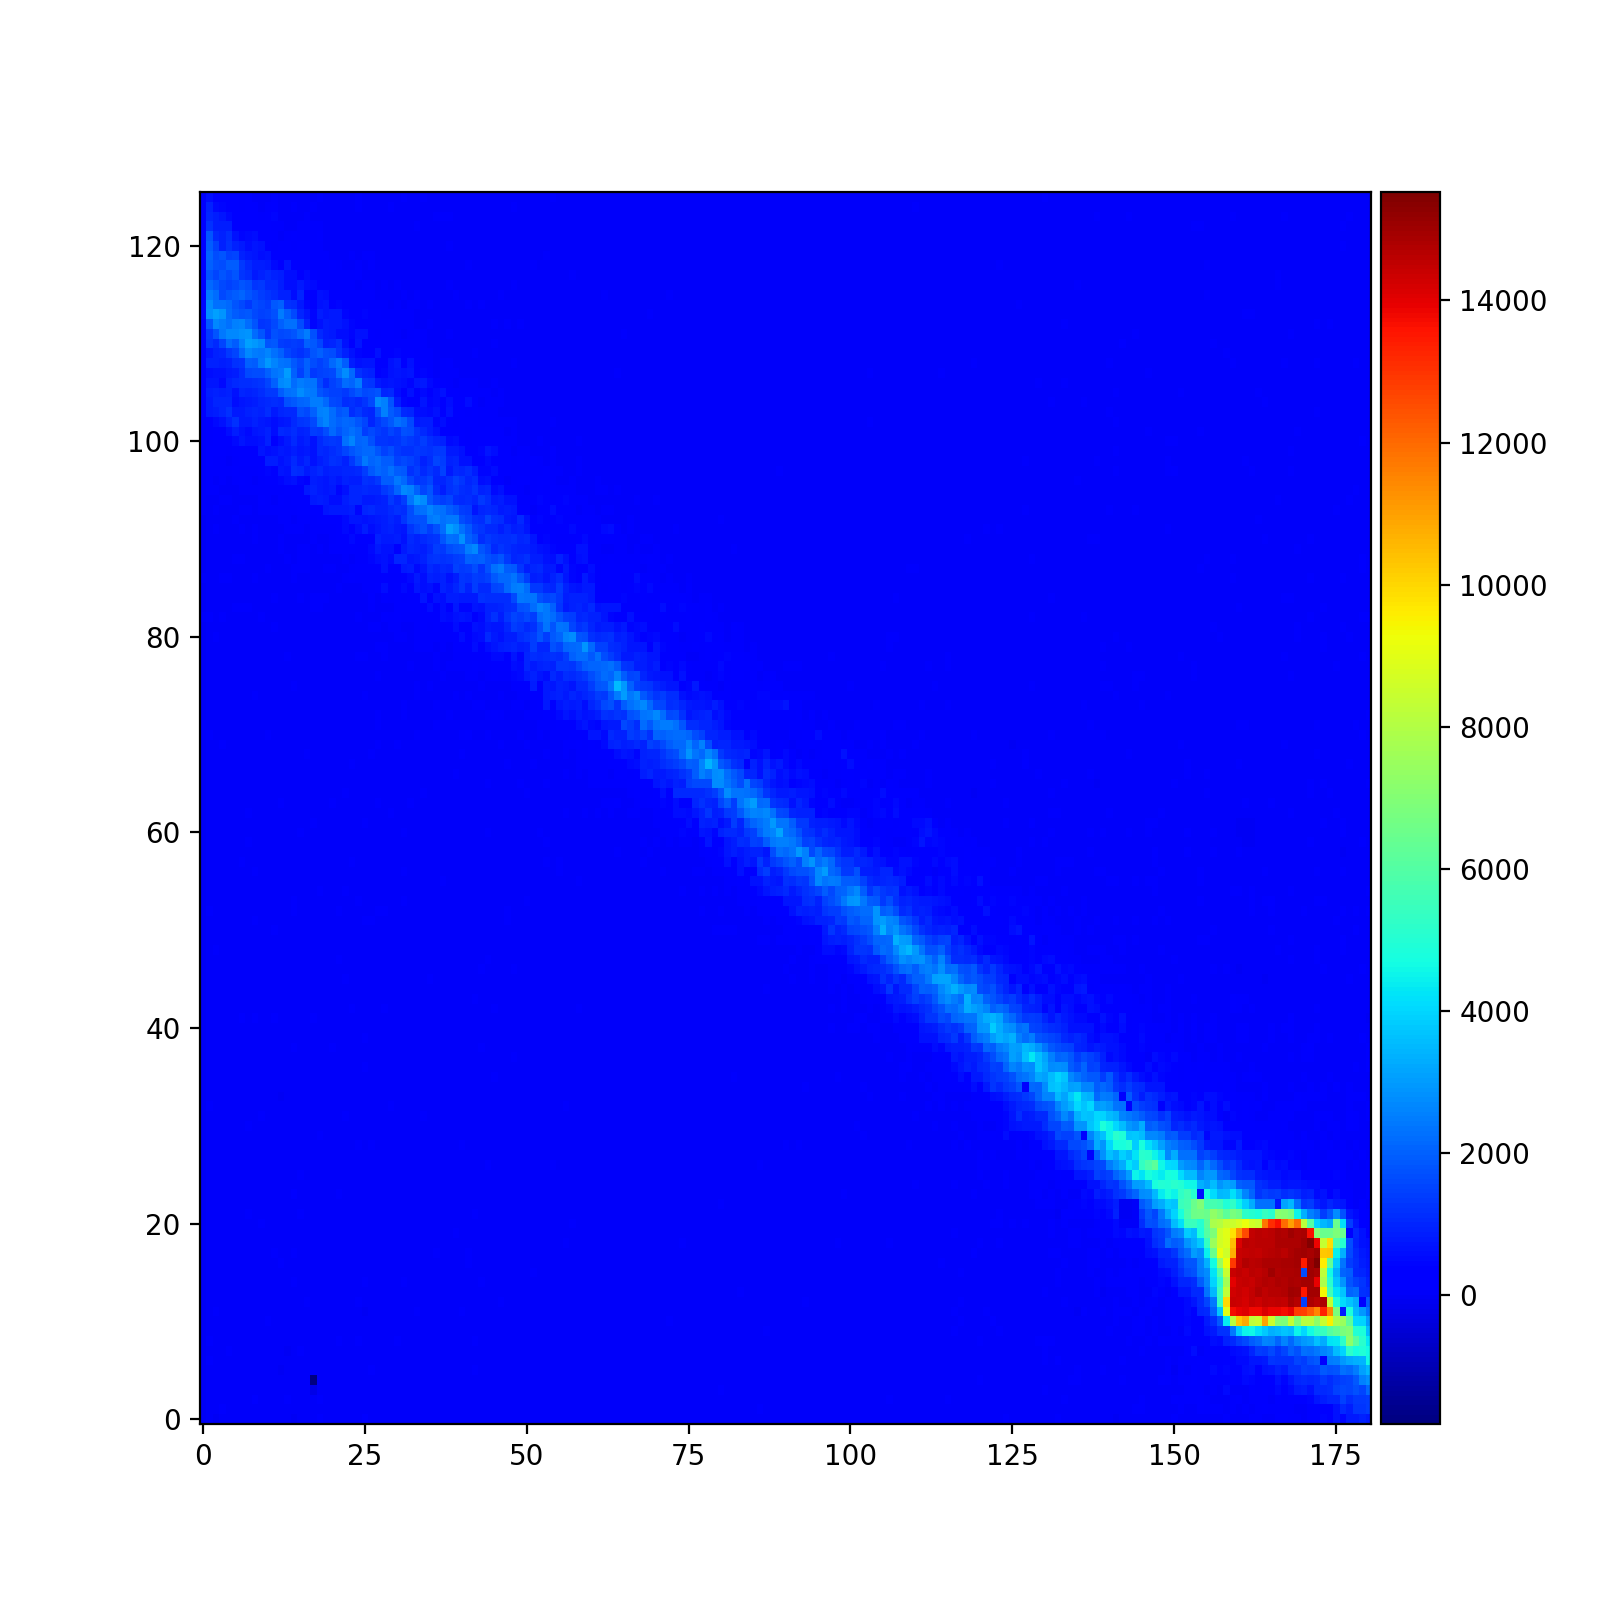

In [512]:
zx = specific_shots('r0173', 'LCLS_2011_Mar01_r0173_031702_173d0_cspad')['peaks'][5]
cm = specific_shots('r0173', 'LCLS_2011_Mar01_r0173_031702_173d0_cspad')['center_mass'][5]
blur = skimage.filters.gaussian(zx, sigma=3)

# perform adaptive thresholding
t = skimage.filters.threshold_otsu(blur)
mask = blur > t
fill_holes = binary_fill_holes(mask)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)

fig = plt.figure(figsize=[8,8])
ax = fig.gca()
'''
shifted = []
for p,i in enumerate(peak_regions):
    img_peak = np.zeros_like(zx)
    img_peak[i] = zx[i]
    cy_L,cx_L = centroid_com(img_peak)
    cy_t,cx_t = centroid_com(zx)
    diff_center = (cm[0] - cy_t, cm[1] - cx_t)
    new_center = np.array([(cy_L,cx_L)])+diff_center
    shifted.append(new_center)
    plt.plot(cy_L, cx_L, 'ko') 
    r,theta = convert_coordinates(new_center[0][0], new_center[0][1], center_of_detector_pixels)
    q_cm = pos2q(r,wavelength,detector_distance,pixel_size)
    qy, qx = pol2cart(q_cm, theta)
#cy_t,cx_t = centroid_com(zx[peak_regions[11]])
#plt.plot(cy_t, cx_t, 'mo') 
'''
im = ax.imshow(zx,cmap='jet', origin = 'lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

In [168]:
sp

[0.3170830455272233]

In [167]:
sp = []
for p,i in enumerate(peak_regions):
    contours,_= cv2.findContours(fill_holes[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if perimeter != 0:
            sp.append(4*np.pi*area/(perimeter**2))

<IPython.core.display.Javascript object>


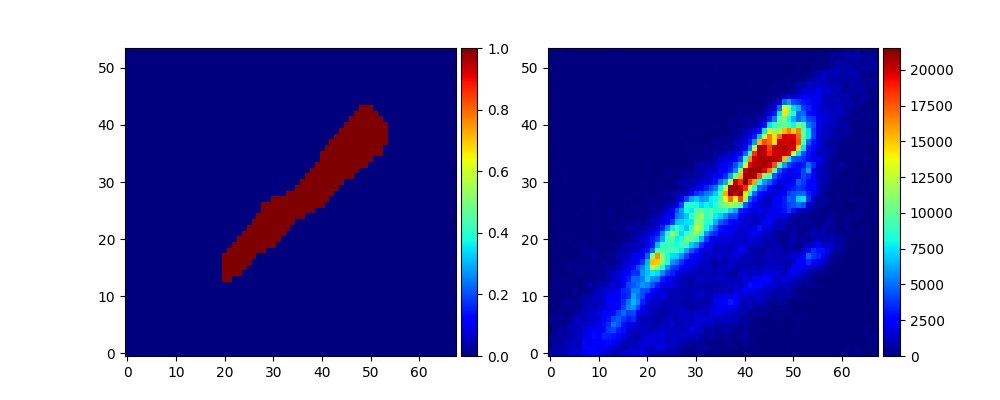

In [344]:
p_test = specific_shots('r0173','LCLS_2011_Mar01_r0173_031028_1496d_cspad')['peaks'][0]
blur = skimage.filters.gaussian(p_test, sigma=1)
t = skimage.filters.threshold_otsu(blur)
mask = blur > t
fill_holes = binary_fill_holes(mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
#p = fill_holes[peak_regions[0]]
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side


im1 = ax1.imshow(mask,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(p_test, cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
#plt.clim(vmin=0,vmax=400)
plt.show()

In [437]:
p6 = specific_shots('r0167','LCLS_2011_Mar01_r0167_003110_c62d_cspad')['peaks'][6]
h = p6.shape[0]
w = p6.shape[1]
# loop over the image, pixel by pixel
for y in range(0, h):
    for x in range(0, w):
        image[y, x] = 255 if image[y, x] >= T else 0

(35, 45)

In [ ]:
LCLS_2011_Mar01_r0167_003110_c62d_cspad, 

     'peak6': {'region1': {'sphericity': 0.7255305594341376,
     'area': 18.0,
     'area2': 27,
     'perimeter': 17.656854152679443,
     'shape': (5, 7)},
    'region2': {'sphericity': 0.5729177380728261,
     'area': 61.5,
     'area2': 79,
     'perimeter': 36.72792184352875,
     'shape': (15, 7)},
    'region3': {'sphericity': 0.720566996684918,
     'area': 27.5,
     'area2': 38,
     'perimeter': 21.899494767189026,
     'shape': (9, 6)}}},

In [ ]:
specific_shots('r0167', 'LCLS_2011_Mar01_r0167_003110_c62d_cspad')['No_of_peaks']

<IPython.core.display.Javascript object>


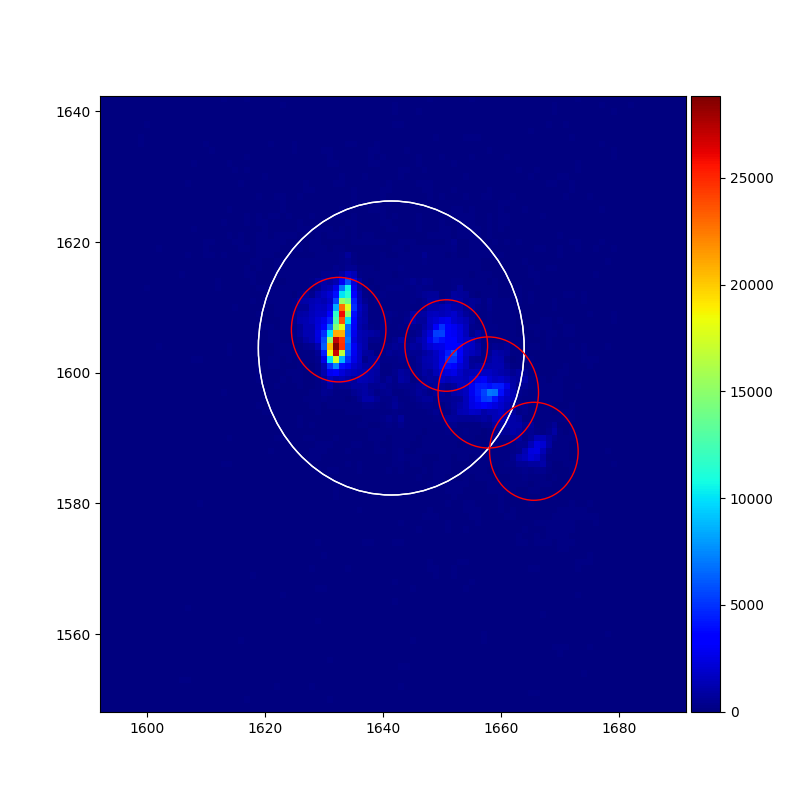

In [278]:
peak_number =specific_shots('r0167', 'LCLS_2011_Mar01_r0167_003110_c62d_cspad')['No_of_peaks']
Center = specific_shots('r0167', 'LCLS_2011_Mar01_r0167_003110_c62d_cspad')['center_mass']
Radius = specific_shots('r0167', 'LCLS_2011_Mar01_r0167_003110_c62d_cspad')['radiusInPixels']
f = h5py.File('LCLS_2011_Mar01_r0167_003110_c62d_cspad.h5', 'r')
d = f['data/data'][:]
fig = plt.figure(figsize=[8,8])
fig = plt.gcf()
ax = fig.gca()

circle1 = plt.Circle(Center[6], radius=Radius[6], color='w')
circle1.set_fill(False)
ax.add_patch(circle1)

for peak in range(peak_number):
    circle1 = plt.Circle(Center[peak], radius=Radius[peak], color='w')
    circle1.set_fill(False)
    ax.add_patch(circle1)
    #plt.text(Center[peak][0]+10, Center[peak][1]+10, round(dict_ex[tuple(Center_t[0])][tuple(Center_t[peak])],2), color = 'y', fontsize = 14)


for peak in range(len(centroids_in_regions)):
    #circle2 = plt.Circle(np.array(centroids_in_cnt)[peak] + (Center[6] - np.array(centroids_in_cnt)[peak]), radius=Radius[peak], color='r')
    circle2 = plt.Circle(np.array(centroids_in_regions)[peak]+diff_center, radius=Radius[peak], color='r')
    circle2.set_fill(False)
    ax.add_patch(circle2)


im = ax.imshow(d,cmap='jet', origin = 'lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [178]:
Center[6]

array([1641.39487777, 1603.78587425])

In [177]:
#np.array(centroids_in_cnt)+ (1760-1)/2

In [414]:
(Center[6] - np.array(centroids_in_cnt))

array([[1641.39487777, 1602.78587425],
       [1639.39487777, 1602.78587425],
       [1638.39487777, 1597.78587425],
       [1639.39487777, 1599.78587425]])

In [410]:
np.array(centroids_in_cnt) + (Center[6] - np.array(centroids_in_regions))

array([[1616.39487777, 1584.78587425],
       [1636.39487777, 1582.78587425],
       [1612.39487777, 1597.78587425],
       [1603.39487777, 1603.78587425]])

In [411]:
mc = np.array(centroids_in_regions) + [1616.39487777, 1584.78587425]

In [470]:
specific_shots('r0167','LCLS_2011_Mar01_r0167_003110_c62d_cspad')['center_mass'][6]

array([1641.39487777, 1603.78587425])

In [369]:
Center[6] - (25, 20)

array([1616.39487777, 1583.78587425])

In [382]:
for i in range(len(centroids)):
    print(centroids[i])

(0, 1)
(2, 1)
(3, 6)
(2, 4)
(0, 1)
(2, 1)
(3, 6)
(2, 4)
(0, 1)
(2, 1)
(3, 6)
(2, 4)


In [230]:
new_cm = np.array(centroids_in_cnt) + (np.array(centroids_in_regions) - np.array(centroids_in_cnt))

ValueError: operands could not be broadcast together with shapes (1,2) (0,) 

In [133]:
sphericity

[0.2858377706113328, 0.5390120920947209, 0.0]

In [232]:
'''
def gaussian(self, height, center_x, center_y, width_x, width_y, rotation):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)

        rotation = np.deg2rad(rotation)
        center_x = center_x * np.cos(rotation) - center_y * np.sin(rotation)
        center_y = center_x * np.sin(rotation) + center_y * np.cos(rotation)

        def rotgauss(x,y):
            xp = x * np.cos(rotation) - y * np.sin(rotation)
            yp = x * np.sin(rotation) + y * np.cos(rotation)
            g = height*np.exp(
                -(((center_x-xp)/width_x)**2+
                  ((center_y-yp)/width_y)**2)/2.)
            return g
        return rotgauss
'''
def moments(self, data):
    """Returns (amp, x0, y0, sigma_x, sigma_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y, 0.0

In [235]:
p = np.asarray(p6).astype('float')
w,h = np.shape(p6)
x, y = np.mgrid[0:h, 0:w]
np.shape(y)

(45, 35)

In [240]:
pea = twoD_Gaussian((x,y),28834,19.785874248979372,16.39487776779045,8.07848306753359,11.619066958224609,0.0)

<IPython.core.display.Javascript object>


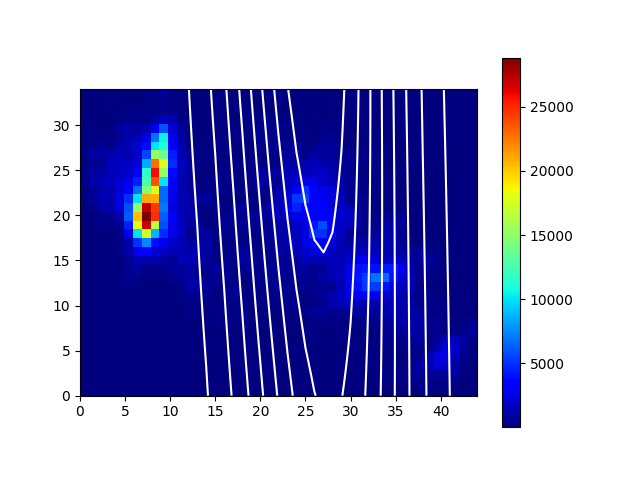

In [239]:
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()


# Create x and y indices

p = np.asarray(p6).astype('float')
w,h = np.shape(p6)
x, y = np.mgrid[0:h, 0:w]

#Fit 2D Gaussian
initial_guess = (28834,19.785874248979372,16.39487776779045,8.07848306753359,11.619066958224609,0.0)
popt, pcov = optimize.curve_fit(twoD_Gaussian, (x, y), p.ravel(), p0=initial_guess)
data_fitted = twoD_Gaussian((x, y), *popt)

#opt_params = optimize.fmin_powell(twoD_Gaussian, initial_guess,
#                                   args=(p6,data_fitted,28834,19.785874248979372,16.39487776779045,8.0784830675335,), xtol=1e-3, ftol=1e-3,
#                                   disp=0)

fig, ax = plt.subplots(1, 1)
cb = ax.imshow(p, cmap=plt.cm.jet, origin='lower',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(x.shape[0], y.shape[1]), 8, colors='w')


plt.colorbar(cb)
plt.show()

In [338]:
from skimage import morphology
import skimage

processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)

<IPython.core.display.Javascript object>


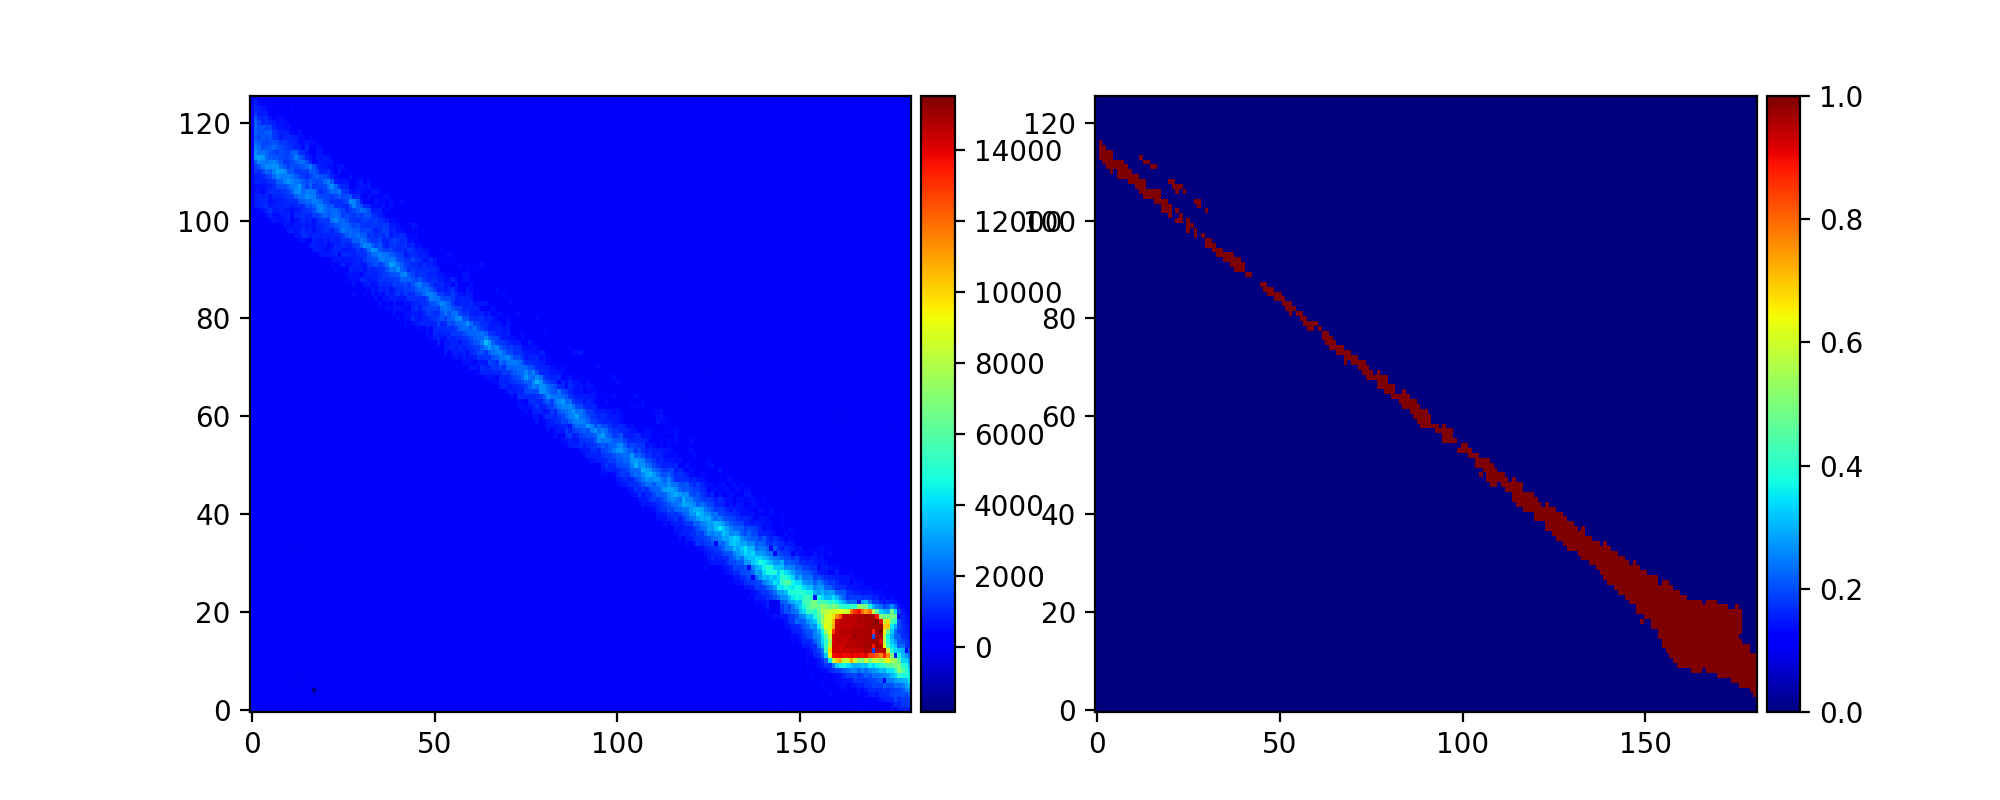

In [203]:
from scipy.ndimage import gaussian_filter
filtered = gaussian_filter(zx, sigma=1, mode='nearest', truncate =10)
p_sub = zx - BG_level
p_mask = p_sub > photon_threshold
fill_holes = binary_fill_holes(p_mask)
processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image, number_of_peaks = scipy.ndimage.label(processed.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
#p = fill_holes[peak_regions[4]]
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

im1 = ax1.imshow(zx,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(fill_holes, cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
#plt.clim(vmin=0,vmax=400)
plt.show()

<IPython.core.display.Javascript object>


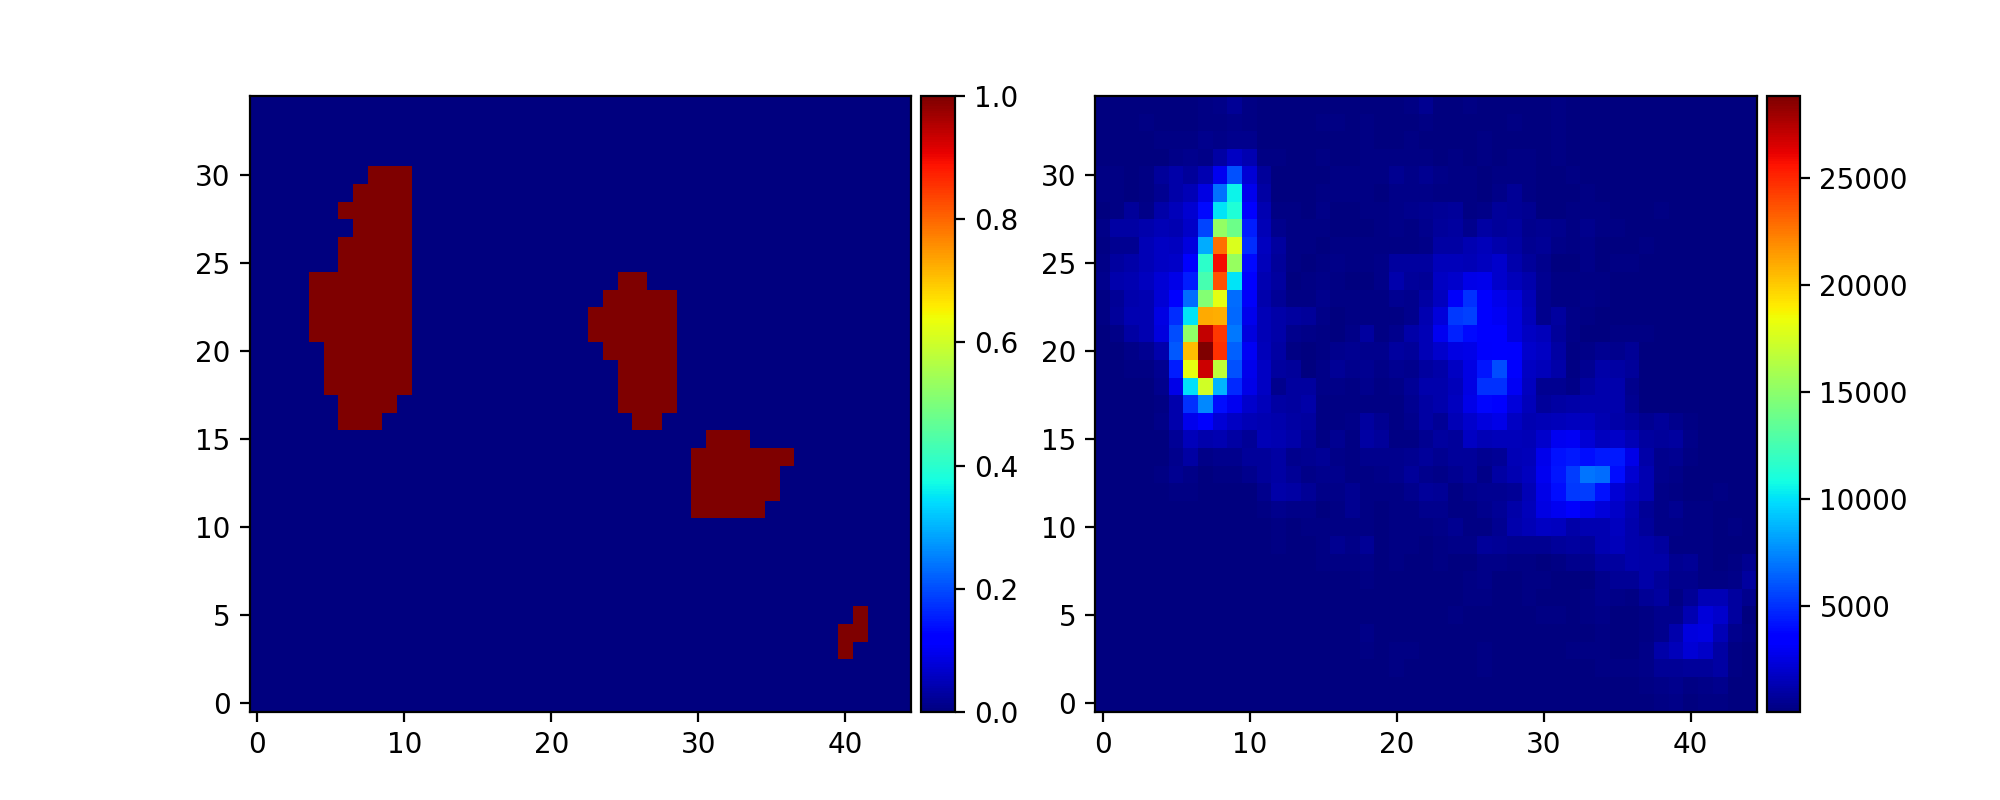

In [612]:
from scipy.ndimage import gaussian_filter
filtered = gaussian_filter(p6, sigma=2, mode='nearest', truncate = 10 )
p_sub = p6 - BG_level
p_mask = p_sub > photon_threshold
fill_holes = binary_fill_holes(p_mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
p = fill_holes[peak_regions[2]]
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

im1 = ax1.imshow(fill_holes,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(p6,cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
#plt.clim(vmin=0,vmax=400)
plt.show()

<IPython.core.display.Javascript object>


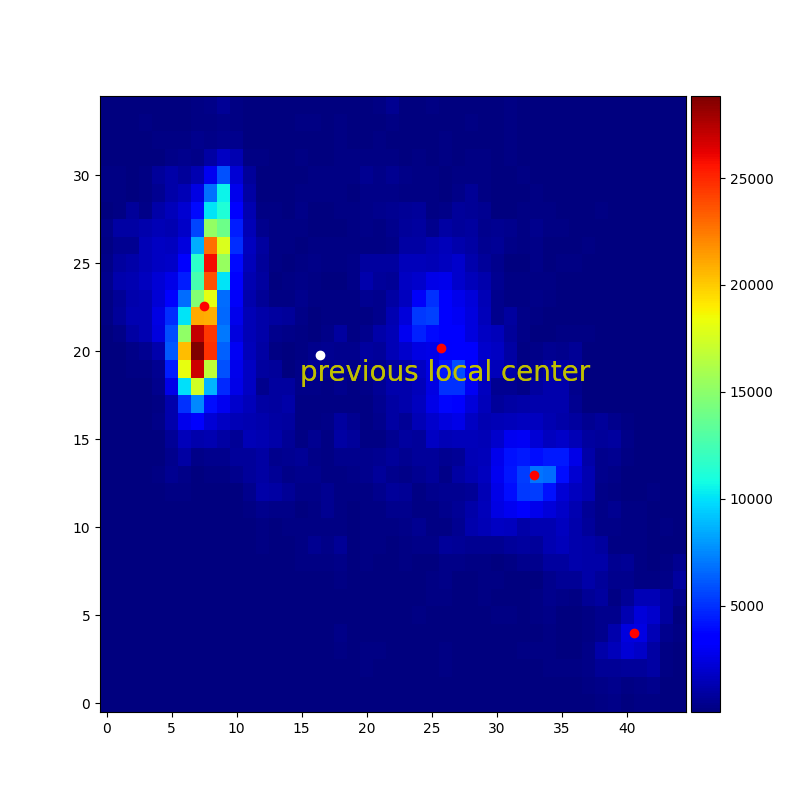

In [277]:
p_sub = p6 - BG_level
p_mask = p_sub > photon_threshold
fill_holes = binary_fill_holes(p_mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
#p = fill_holes[peak_regions[1]]
centroids_in_cnt = []
sphericity = []
centroids_in_regions = []

contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
for p,i in enumerate(peak_regions):
    img_peak = np.zeros_like(p6)
    img_peak[i] = p6[i]
    cx,cy = centroid_com(img_peak)
    centroids_in_regions.append((cx,cy))

'''
for p,i in enumerate(peak_regions):
    contours,_= cv2.findContours(fill_holes[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        M = cv2.moments(cnt)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        #centroids_in_cnt.append((cx,cy))
        if perimeter != 0:
            sphericity.append(4*np.pi*area/(perimeter**2))
'''                       
x_con = [contours[0][i][0][0] for i in range(len(contours[0]))]
y_con = [contours[0][i][0][1] for i in range(len(contours[0]))]
#x_con1 = [contours[1][i][0][0] for i in range(len(contours[1]))]
#y_con1 = [contours[1][i][0][1] for i in range(len(contours[1]))]
#x_con2 = [contours[2][i][0][0] for i in range(len(contours[2]))]
#y_con2 = [contours[2][i][0][1] for i in range(len(contours[2]))]
#x_con3 = [contours[3][i][0][0] for i in range(len(contours[3]))]
#y_con3 = [contours[3][i][0][1] for i in range(len(contours[3]))]

#x_con2.append(int(contours[2][0][0][0]))
#y_con2.append(int(contours[2][0][0][1]))
x_con.append(int(contours[0][0][0][0]))
y_con.append(int(contours[0][0][0][1]))
#x_con1.append(int(contours[1][0][0][0]))
#y_con1.append(int(contours[1][0][0][1]))
#x_con3.append(int(contours[3][0][0][0]))
#y_con3.append(int(contours[3][0][0][1]))            

fig = plt.figure(figsize=[8,8])
ax = fig.gca()
#plt.plot(x_con, y_con, 'y-')

qs = []


#for i in range(len(centroids_in_regions)):
    #r,theta = convert_coordinates(np.array(centroids_in_regions)[i][0]+diff_center[0], np.array(centroids_in_regions)[i][1]+diff_center[1], center_of_detector_pixels)
    #cx,cy =  pol2cart(r, theta)
    #q_cm = pos2q(r,wavelength,detector_distance,pixel_size)
    #qx, qy = pol2cart(q_cm, theta)
    #qs.append(q_cm)
    #plt.plot(centroids_in_cnt[i][0], centroids_in_cnt[i][1], 'yo')
    #print(np.array(centroids_in_regions)[i][0]+diff_center[0], np.array(centroids_in_regions)[i][1]+diff_center[1])

for i in range(len(centroids_in_regions)):
    plt.plot(centroids_in_regions[i][0], centroids_in_regions[i][1], 'ro')    

#for i in range(len(centroids_in_regions)):
#    plt.plot((np.array(centroids_in_regions) - np.array(centroids_in_cnt))[i][0], (np.array(centroids_in_regions) - np.array(centroids_in_cnt))[i][1], 'go')    
    
#for i in range(len(new_cm)):
#    plt.plot(new_cm[i][0], new_cm[i][1], 'mo')  
    
plt.plot(cy_L, cx_L, 'wo') 
plt.text(cy_L-1.5, cx_L-1.5, 'previous local center', color = 'y', fontsize = 20)
plt.text(cy_L-1.5, cx_L-1.5, 'previous local center', color = 'y', fontsize = 20)

#plt.plot(x_con1, y_con1, 'y-')
#plt.plot(x_con2, y_con2, 'y-')
#plt.plot(x_con3, y_con3, 'y-')
#plt.text(contours[0][0][0][0]-1.5, contours[0][0][0][1]-1.5, sphericity[0], color = 'y', fontsize = 20)
#plt.text(contours[1][0][0][0]-1.5, contours[1][0][0][1]-1.5, sphericity[1], color = 'y', fontsize = 20)
#plt.text(contours[2][0][0][0]-1.5, contours[2][0][0][1]-1.5, sphericity[2], color = 'y', fontsize = 20)
#plt.text(contours[3][0][0][0]-1.5, contours[3][0][0][1]-1.5, sphericity[3], color = 'y', fontsize = 20)
im = ax.imshow(p6,cmap='jet', origin = 'lower', aspect='auto')
#ax.contour(p_mask, extend='both',linewidths=2)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
#plt.clim(vmin=0,vmax=400)
plt.show()


In [481]:
specific_shots('r0167','LCLS_2011_Mar01_r0167_003110_c62d_cspad')['q_cm'][6]

array([3.2445843])

In [483]:
qs

[array([3.25597014]),
 array([3.23156667]),
 array([3.25528824]),
 array([3.25637594])]

In [172]:
Center[6] 

NameError: name 'Center' is not defined

In [276]:
cy_L,cx_L = centroid_com(p6)
diff_center = (Center[6][0] - cy_L, Center[6][1] - cx_L)

In [250]:
diff_center

(1625.0, 1584.0)

In [251]:
np.array([(cy_L,cx_L)])+diff_center

array([[1641.39487777, 1603.78587425]])

In [252]:
np.array([(cy_L,cx_L)])

array([[16.39487777, 19.78587425]])

In [362]:
for i in range(len(centroids)):
    r,theta = convert_coordinates(centroids[i][0], centroids[i][1], center_of_detector_pixels)
    q_cm = pos2q(r,wavelength,detector_distance,pixel_size)
    qx, qy = pol2cart(q_cm, theta)
    qs.append(q_cm)
    print(q_cm)

[3.5977657]


In [359]:
centroids

[(7, 7)]

In [345]:
specific_shots('r0167','LCLS_2011_Mar01_r0167_003110_c62d_cspad')['q_cm'], qs

([array([2.34146992]),
  array([1.60779959]),
  array([1.83156404]),
  array([2.58184979]),
  array([1.74452185]),
  array([1.77464616]),
  array([3.2445843])],
 [])

In [360]:
qs

[array([3.5977657])]

In [318]:
np.shape(contours)

(1, 33, 1, 2)

In [235]:
sphericity

[0.720566996684918, 0.5729177380728261, 0.7255305594341376, 0.5390120952601716]

In [295]:
x = centroids[0][0]
y = centroids[0][1]

In [296]:
# delta_cx = cx2 (old peak center in whole image 1760) - cx1 (old peak local center peak_region) # new_cx
# delta_cy = cy2 (old peak center in whole image 1760) - cy1 (old peak local center peak_region) # new_cx

In [297]:
x,y, r, theta

(25,
 20,
 array([1244.50793489, 1243.09372133, 1241.67950776, ..., 1240.2652942 ,
        1241.67950776, 1243.09372133]),
 array([-2.35619449, -2.35619449, -2.35619449, ...,  0.78539816,
         0.78539816,  0.78539816]))

In [298]:
r,theta = convert_coordinates(x, y, center_of_detector_pixels)
q_test = pos2q(r,wavelength,detector_distance,pixel_size)
x,y =pol2cart(q_test, theta)
list(zip(x,y))

[(-2.50871794345789, -2.5233888086243104)]

In [191]:
def cart2pol(x, y):
    '''
    cart2pol(x, y)
    
    x: x values
    y: y values
    
    Will convert cartesian coordinates into polar
    
    returns:
    r, theta
    '''
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta


def convert_coordinates(x, y, center=None):
    '''
    x is detector coordinate x
    y is detector coordinate y
    
    center is where the beam goes 
    through the detector in format (x,y)
    
    returns:
    
    r:      distance from center in pixels
    theta:  angle in the detector plane of x,y, measured counter-
            clockwise. 0 is at x larger than center[0], 
            and y == center[1]
    '''
    if center==None:
        error=True 
        #ADD SOME ERROR OR WARNING HERE LATER
    else:
        x_offset=np.subtract(x,center[0])
        y_offset=np.subtract(y,center[1])
        r,theta=cart2pol(x_offset,y_offset)
    return r,theta


def pos2q(r,wavelength_AA,distance_to_detector_m,pixel_size_m):
    '''
    r: distance in pixels from center, scalar or array
    wavelength_AA: wavelength in Angstrom
    distance_to_detector_m: distance to the center in meters
    pixel_size_m: size of a pixel in m
    '''
    
    r_array = np.atleast_1d(np.asarray(r))
    q = np.zeros(np.shape(r_array))   
    
    # 2d to q
    # q=2*pi/d or d= (2*pi)/q , 2 d = 4 pi / q

    # BRAGGS LAW:
    # 2*d sin(theta) = lambda
    # OR written as:
    # 4 pi sin(theta)/q = lambda
    # q = 4 pi sin(theta)/lambda

    # reflection angle noted with alpha
    # Also considering that theta = alpha /2 :
    # q = 4 pi sin(alpha/2)/lambda

    # distance from center = x
    # distance to detector = y
    # Also considering that tan(alpha) = x/y:
    # alpha= arctan(x/y)
    # q = 4 pi sin(arctan(x/y)/2)/lambda

    for r_index, r in enumerate(r_array):
        r_m = r*pixel_size_m
    # fraction of distance from center and distance to the detector
        fraction = np.divide(r_m, distance_to_detector_m)

        # the scattering angle, note that it's half the angle from the
        # reflection to the beam at the interaction point
        scattering_angle = np.arctan(fraction)/2.0

        #
        # in reverse Angstrom
        q[r_index] = 4*np.pi * \
            np.divide(np.sin(scattering_angle), wavelength_AA)

    return(q)

def pol2cart(r, theta):
    '''
    pol2cart(r, theta)
    
    r: r values
    theta: theta values
    
    Will convert polar coordimates into cartesian
    
    returns:
    x,y
    '''
    x = np.multiply(r,np.cos(theta))
    y = np.multiply(r,np.sin(theta))
    return x, y 


In [428]:
np.shape(d[:,0])

(1760,)

In [430]:
d[:,0][np.nonzero(d[:,0])]

array([], dtype=int16)

In [426]:
d[:][0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [435]:
def moments(data):
        """Returns (height, x, y, width_x, width_y)
        the gaussian parameters of a 2D distribution by calculating its
        moments """
        total = data.sum()
        X, Y = np.indices(data.shape)
        x = (X*data).sum()/total
        y = (Y*data).sum()/total
        col = data[:, int(y)]
        width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
        row = data[int(x), :]
        width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
        height = data.max()
        return height, x, y, width_x, width_y, 0.0

In [436]:
moments(d)

(28834,
 991.481566317285,
 940.9257738207139,
 589.9883339624306,
 647.2376730885431,
 0.0)

In [244]:
def gaussian(height, center_x, center_y, width_x, width_y, rotation):
        """Returns a gaussian function with the given parameters"""
        width_x = float(width_x)
        width_y = float(width_y)

        rotation = np.deg2rad(rotation)
        center_x = center_x * np.cos(rotation) - center_y * np.sin(rotation)
        center_y = center_x * np.sin(rotation) + center_y * np.cos(rotation)

        def rotgauss(x,y):
            xp = x * np.cos(rotation) - y * np.sin(rotation)
            yp = x * np.sin(rotation) + y * np.cos(rotation)
            g = height*np.exp(
                -(((center_x-xp)/width_x)**2+
                  ((center_y-yp)/width_y)**2)/2.)
            return g
        return rotgauss

In [247]:
#norm2d = gaussian(moments(d)[0], moments(d)[1], moments(d)[2], moments(d)[3], moments(d)[4], moments(d)[5])

In [248]:
def detect_peaks(img, int_threshold, peak_threshold, pixel_size = 110.E-6, detector_distance = 0.139, wavelength = 1.322e-10, mask=None, center=None):
    # detect_peaks # int_threshold is the number of standard deviations, and peak threshold is the number of pixels that we 
    peak_list = []
    threshold = int_threshold*(np.median(img)+np.std(img))
    image_thresholded = np.copy(img)
    # TODO: look at only non-masked pixels
    image_thresholded[img<threshold] = 0
    #find the peak regions and label all the pixels
    labeled_image, number_of_peaks = scipy.ndimage.label(image_thresholded)
    peak_regions = scipy.ndimage.find_objects(labeled_image)
    x = np.arange(img.shape[1])
    y = np.arange(img.shape[0])
    xx, yy = np.meshgrid(x, y)
    if center is None:
        xx = xx.astype(np.float64) - (img.shape[1]-1)/2
        yy = yy.astype(np.float64) - (img.shape[0]-1)/2
    else:
        xx -= center[1]
        yy -= center[0]
    qx = 2.*np.pi*2.*np.sin(0.5*np.arctan2(xx*pixel_size, detector_distance))/(wavelength)
    qy = 2.*np.pi*2.*np.sin(0.5*np.arctan2(yy*pixel_size, detector_distance))/(wavelength)
    for peak_region_i in peak_regions:
        ry = img[peak_region_i].shape[0]
        rx = img[peak_region_i].shape[1]
        qx_peak = qx[peak_region_i]
        qy_peak = qy[peak_region_i]
        if (ry>peak_threshold) and (rx>peak_threshold):
            img_peak = np.zeros_like(img)
            img_peak[peak_region_i] = img[peak_region_i]
            # TODO: improve peak width with 1D Gaussian fit
            if (ry > rx):
                r = ry/2. 
            else:
                r = rx/2.
                # current reference position is first element of 2D array (lower left corner), not center
                cy,cx = centroid_com(img_peak)
            #cy -= (img_peak.shape[0]-1)/2.
            #cx -= (img_peak.shape[1]-1)/2.
                peak_list.append([img[peak_region_i],(cy,cx),r,qx_peak,qy_peak])
    return peak_list

In [316]:
median_p = []
for i in np.arange(len(detect_peaks(d, 2, 10))):
    median_p.append(detect_peaks(d, 2, 10)[i][0])

In [318]:
np.shape(median_p)

(5,)

In [319]:
peak_number

9

In [367]:
len(median_p), len(mean_peaks)

(5, 7)